<a href="https://colab.research.google.com/github/Bovi-analytics/Hut-et-al-2022/blob/main/DefinitiveModelWalkingTime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook for Walking time

*   Load libraries
*   Create dataset walking grouped per 3/4/5
*   Descriptives dataset walking all cows
*   Run models walking grouped in 7 groups per 4
    * Create subsets walking
    * Descriptives lactating AMS/CMS and dry cows
    * Models linear mixed models (glmmTNB):
      1. THI mean
      2. THI max
      3. THI min
      4. THI mean 1 day before
      5. THI mean 2 days before
      6. Temperature mean
      7. Temperature max
      8. Temperature min
      9. Temperature mean 1 day before
      10. Temperature mean 2 days before
      a= lactating cows AMS farms
      b= lactating cows CMS farms
      c= dry cows
*   Walking time figures:
    * THI mean figures
    * Temperature mean figures

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [ ]:
%reload_ext rpy2.ipython

# Libraries

In [ ]:
%%R
lib_loc <- "/content/drive/Shareddrives/Bovi-Analytics/R-lib/"

In [ ]:
%%R
package_list <- c("glmmTMB",
                  "dplyr",
                  "ggplot2",
                  "emmeans",
                  "lsmeans", 
                  "plyr"
                  )

for (pkg in package_list) {
  if (pkg %in% rownames(.packages()) == FALSE)
  {library(pkg, lib.loc = lib_loc, character.only = TRUE)}

}

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: The 'lsmeans' package is now basically a front end for 'emmeans'.
Users are encouraged to switch the rest of the way.
See help('transition') for more information, including how to
convert old 'lsmeans' objects and scripts to work with 'emmeans'.

R[write to console]: ------------------------------------------------------------------------------

R[write to console]: You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

R[write to console]: ------------------------------------------------------------------------------

R[write to console]: 
Attaching package: ‘plyr’


R[write to 

# Create dataset walking grouped per 3/4/5

In [ ]:
%%R
url_walking <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/in/SensorData/ObservationType=WalkingTimeMinutesPerDay/part-00034-tid-7288064156538290647-292796ee-9893-4de2-a04f-ea381f27134d-142-1.c000.csv'
dataset_behaviour <- read.csv(url_walking, header = TRUE, sep = ",") %>% 
 dplyr::mutate(
    Date = as.Date(EventDate,"%Y-%m-%d")
    ) %>%
 dplyr::select(
     -c(EventDate, Hour)
    ) %>%
 mutate(DimCat = case_when(DaysInMilk <= 0 ~ 0, #condition 1
                         DaysInMilk <= 21  ~ 1, #condition 2
                         DaysInMilk <= 60  ~ 3, #condition 3
                         DaysInMilk <= 120 ~ 4, #condition 4
                         DaysInMilk <= 200 ~ 5, #condition 5
                         DaysInMilk >= 200 ~ 6
    )) %>%
  mutate(AutomaticMilking = case_when(HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314 ~ 1, 
                         HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888~ 0
    )) %>%
  mutate(CowLac = paste(LactationNumber, AnimalEartag))

In [ ]:
%%R
url_KNMI3 <-'/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/df_KNMI_per3.csv'
url_KNMI4 <-'/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/df_KNMI_per4.csv'
url_KNMI5 <-'/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/df_KNMI_per5.csv'

In [ ]:
%%R
dataset_KNMI3 <- read.csv(url_KNMI3, header = TRUE, sep = ",") %>% 
  dplyr::mutate(
      Date = as.Date(Date,"%Y-%m-%d")
  )
  dataset_KNMI4 <- read.csv(url_KNMI4, header = TRUE, sep = ",") %>% 
  dplyr::mutate(
      Date = as.Date(Date,"%Y-%m-%d")
  )
  dataset_KNMI5 <- read.csv(url_KNMI5, header = TRUE, sep = ",") %>% 
  dplyr::mutate(
      Date = as.Date(Date,"%Y-%m-%d")
  )

In [ ]:
%%R
df_joined_per4 <- dataset_behaviour %>%
  dplyr::left_join(dataset_KNMI4, by = c("HerdIdentifier", "Date")) %>%                                                              
  dplyr::filter(Year > 2016) %>%
  dplyr::filter(SensorValue > 0) %>%
  dplyr::filter(SensorValue <=1440) %>%
  dplyr::mutate(Day= as.numeric(Date)-min(as.numeric(Date))) %>%
  dplyr::mutate(LactationNumber= case_when(LactationNumber == 1 ~ 1,
                                            LactationNumber == 2 ~ 2,
                                            LactationNumber == 3 ~ 3,
                                            LactationNumber == 4 ~ 4,
                                            LactationNumber == 5 ~ 5,
                                            LactationNumber == 6 ~ 6,
                                            LactationNumber == 7 ~ 7,
                                            LactationNumber >= 8 ~ 8)) %>%
  dplyr::mutate(Parity = case_when(LactationNumber==1~0, LactationNumber>=2~1)) 

In [ ]:
%%R
df_joined_per3 <- dataset_behaviour %>%
  dplyr::left_join(dataset_KNMI3, by = c("HerdIdentifier", "Date")) %>%                                                              
  dplyr::filter(Year > 2016) %>%
  dplyr::filter(SensorValue > 0)%>%
  dplyr::filter(SensorValue <=1440) %>%
  dplyr::mutate(Day= as.numeric(Date)-min(as.numeric(Date))) %>%
  dplyr::mutate(LactationNumber= case_when(LactationNumber == 1 ~ 1,
                                            LactationNumber == 2 ~ 2,
                                            LactationNumber == 3 ~ 3,
                                            LactationNumber == 4 ~ 4,
                                            LactationNumber == 5 ~ 5,
                                            LactationNumber == 6 ~ 6,
                                            LactationNumber == 7 ~ 7,
                                            LactationNumber >= 8 ~ 8)) %>%
  dplyr::mutate(Parity = case_when(LactationNumber==1~0, LactationNumber>=2~1)) 

In [ ]:
%%R
df_joined_per5 <- dataset_behaviour %>%
  dplyr::left_join(dataset_KNMI5, by = c("HerdIdentifier", "Date")) %>%                                                              
  dplyr::filter(Year > 2016) %>%
  dplyr::filter(SensorValue > 0)%>%
  dplyr::filter(SensorValue <=1440) %>%
  dplyr::mutate(Day= as.numeric(Date)-min(as.numeric(Date))) %>%
  dplyr::mutate(LactationNumber= case_when(LactationNumber == 1 ~ 1,
                                            LactationNumber == 2 ~ 2,
                                            LactationNumber == 3 ~ 3,
                                            LactationNumber == 4 ~ 4,
                                            LactationNumber == 5 ~ 5,
                                            LactationNumber == 6 ~ 6,
                                            LactationNumber == 7 ~ 7,
                                            LactationNumber >= 8 ~ 8)) %>%
  dplyr::mutate(Parity = case_when(LactationNumber==1~0, LactationNumber>=2~1)) 

In [ ]:
%%R
write.csv(df_joined_per3, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/df_joined_per3_walking.csv', row.names = FALSE)
write.csv(df_joined_per4, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/df_joined_per4_walking.csv', row.names = FALSE)
write.csv(df_joined_per5, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/df_joined_per5_walking.csv', row.names = FALSE)

#Descriptives dataset walking all cows together

In [ ]:
## Count unique cowlactations in the dataset
%%R
length(unique(df_joined_per4$CowLac))

[1] 4617


In [ ]:
## Count number of measurements per lactationgroup in the dataset. 
%%R
table(df_joined_per4$LactationNumber)


     1      2      3      4      5      6      7      8 
247070 264078 207578 145178  87832  43721  17439  17851 


In [ ]:
## Days in each THI mean group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$ThiMeanCat)


     0      1      2      3      4      5      6 
 11398 617889 135743 133650  90386  30514  11167 


In [ ]:
## Days in each THI max group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$ThiMaxCat)


     0      1      2      3      4      5      6 
  1374 446611 113810 114431 137573 124067  92881 


In [ ]:
## Days in each THI min group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$ThiMinCat)


     0      1      2      3      4      5      6 
 67941 561936 134742 121013  94440  39913  10762 


In [ ]:
## Days in each THI mean 1daybefore group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$ThiMean1daybeforeCat)


     0      1      2      3      4      5      6 
 11421 617850 135682 133654  90405  30483  11148 


In [ ]:
## Days in each THI mean 2 daysbefore group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$ThiMean2daysbeforeCat)


     0      1      2      3      4      5      6 
 11445 618062 135648 133505  90214  30539  11125 


In [ ]:
## Days in each Temperature mean group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$TempMeanCat)


     0      1      2      3      4      5      6 
 37191 531311 195357 184648  63749  15566   2925 


In [ ]:
## Days in each Temperature max group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$TempMaxCat)


     0      1      2      3      4      5      6 
 12600 386572 166700 160072 167613  89733  47457 


In [ ]:
## Days in each Temperature min group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$TempMinCat)


     0      1      2      3      4      5      6 
135880 212260 245035 223053 173356  36536   4627 


In [ ]:
## Days in each Temperature mean 1daybefore group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$TempMean1daybeforeCat)


     0      1      2      3      4      5      6 
 37120 531321 195349 184518  63878  15538   2919 


In [ ]:
## Days in each Temperature mean 2 daysbefore group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$TempMean2daysbeforeCat)


     0      1      2      3      4      5      6 
 37179 531318 195400 184254  63969  15501   2917 


In [ ]:
## Days in each THI mean group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$ThiMeanCat)



     0      1      2      3      4      5      6      7 
 11398 649232 104400 102803  91103  40316  20328  11167 


In [ ]:
## Days in each THI max group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$ThiMaxCat)


     0      1      2      3      4      5      6      7 
  1374 476892  83529  84918  95788 109141  86224  92881 


In [ ]:
## Days in each THI min group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$ThiMinCat)


     0      1      2      3      4      5      6      7 
197981 325676 106220 102567  91742  90851  65035  50675 


In [ ]:
## Days in each THI mean 1daybefore group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$ThiMean1daybeforeCat)


     0      1      2      3      4      5      6      7 
 11421 649068 104464 102806  91082  40344  20310  11148 


In [ ]:
## Days in each THI mean 2daysbefore group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$ThiMean2daysbeforeCat)


     0      1      2      3      4      5      6      7 
 11445 649234 104476 102716  90834  40352  20356  11125 


In [ ]:
## Days in each Temperature mean group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$TempMeanCat)


     0      1      2      3      4      5      6      7 
 37191 572489 154179 148838  78510  27689   8926   2925 


In [ ]:
## Days in each Temperature max group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$TempMaxCat)


     0      1      2      3      4      5      6      7 
 12600 428623 124649 116208 131991 110205  59014  47457 


In [ ]:
## Days in each Temperature min group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$TempMinCat)


     0      1      2      3      4      5      6      7 
135880 212260 183456 175661 160312 122015  36536   4627 


In [ ]:
## Days in each Temperature mean 1daybefore group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$TempMean1daybeforeCat)


     0      1      2      3      4      5      6      7 
 37120 531321 195349 148882  78484  27653   8915   2919 


In [ ]:
## Days in each Temperature mean 2daysbefore group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$TempMean2daysbeforeCat)


     0      1      2      3      4      5      6      7 
 37179 531318 195400 148762  78352  27705   8905   2917 


In [ ]:
## Days in each THI mean group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$ThiMeanCat)


     0      1      2      3      4      5 
 11398 588881 164751 167314  75955  22448 


In [ ]:
## Days in each THI max group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$ThiMaxCat)


     0      1      2      3      4      5 
  1374 419033 141388 147192 178842 142918 


In [ ]:
## Days in each THI min group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$ThiMinCat)


     0      1      2      3      4      5 
 67941 455716 174730 154691 126994  50675 


In [ ]:
## Days in each THI mean 1daybefore group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$ThiMean1daybeforeCat)


     0      1      2      3      4      5 
 11421 588616 164916 167120  76158  22412 


In [ ]:
## Days in each THI mean 2daysbefore group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$ThiMean2daysbeforeCat)


     0      1      2      3      4      5 
 11445 588741 164969 166950  76061  22372 


In [ ]:
## Days in each Temperature mean group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$TempMeanCat)


     0      1      2      3      4      5 
 37191 440102 226087 245127  70389  11851 


In [ ]:
## Days in each Temperature max group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$TempMaxCat)


     0      1      2      3      4      5 
 12600 288787 219033 205524 198332 106471 


In [ ]:
## Days in each Temperature min group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$TempMinCat)


     0      1      2      3      4      5 
135880 275958 295419 252002  66861   4627 


In [ ]:
## Days in each Temperature mean 1daybefore group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$TempMean1daybeforeCat)


     0      1      2      3      4      5 
 37120 440096 226147 244945  70501  11834 


In [ ]:
## Days in each Temperature mean 2daysbefore group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$TempMean2daysbeforeCat)


     0      1      2      3      4      5 
 37179 440033 226368 244571  70565  11822 


In [ ]:
%%R
rm(dataset_behaviour)
rm(dataset_KNMI3)
rm(dataset_KNMI4)
rm(dataset_KNMI5)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2382293  127.3    6362260  339.8   5503344  294.0
Vcells 190576353 1454.0  443716130 3385.3 443716130 3385.3


# Run models Walking grouped in 7 groups per 4

## Create sub datasets walking

In [ ]:
## load dataset
%%R 
url4 <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/df_joined_per4_walking.csv'

dataset_per4 <- read.csv(url4, header = TRUE, sep = ",")[ ,c('SensorValue','DimCat','LactationNumber','ThiMeanCat','TempMeanCat','ThiMaxCat','TempMinCat','ThiMinCat', 'Parity',
                                                       'ThiMean1daybeforeCat', 'TempMean1daybeforeCat', 'ThiMean2daysbeforeCat', 'TempMean2daysbeforeCat','CowLac',  
                                                        'TempMaxCat','Year', 'Month', 'HerdIdentifier','Day','AnimalEartag','CowLac', 'Temp6Hrs16','Thi6Hrs60')]
## Change categorized data to factor and relevel 
dataset<-dataset_per4
dataset$fDimCat <- factor(dataset$DimCat)
dataset$Parity <-factor(dataset$Parity)
dataset$fHerdIdentifier <- factor(dataset$HerdIdentifier)
dataset$fYear <- factor(dataset$Year)
dataset$fMonth <- factor(dataset$Month)
dataset$fThiMeanCat <- factor(dataset$ThiMeanCat)
dataset$fThiMaxCat <- factor(dataset$ThiMaxCat)
dataset$fThiMinCat <- factor(dataset$ThiMinCat)
dataset$fTempMeanCat <- factor(dataset$TempMeanCat)
dataset$fTempMaxCat <- factor(dataset$TempMaxCat)
dataset$fTempMinCat <- factor(dataset$TempMinCat)
dataset$fThiMean1daybeforeCat <- factor(dataset$ThiMean1daybeforeCat)
dataset$fThiMean2daysbeforeCat <- factor(dataset$ThiMean2daysbeforeCat)
dataset$fTempMean2daysbeforeCat <- factor(dataset$TempMean2daysbeforeCat)
dataset$fTempMean1daybeforeCat <- factor(dataset$TempMean1daybeforeCat)
dataset$fTemp6Hrs16 <- factor(dataset$Temp6Hrs16)
dataset$fThi6Hrs60 <- factor(dataset$Thi6Hrs60)
dataset$fLactationNumberCat <- factor(dataset$LactationNumber)
dataset$SensorValue<- log(dataset$SensorValue)
dataset <- within(dataset, fThiMeanCat <- relevel(fThiMeanCat, ref = "1"))
dataset <- within(dataset, fThiMinCat <- relevel(fThiMinCat, ref = "1"))
dataset <- within(dataset, fThiMaxCat <- relevel(fThiMaxCat, ref = "1"))
dataset <- within(dataset, fTempMeanCat <- relevel(fTempMeanCat, ref = "1"))
dataset <- within(dataset, fTempMinCat <- relevel(fTempMinCat, ref = "1"))
dataset <- within(dataset, fTempMaxCat <- relevel(fTempMaxCat, ref = "1"))
dataset <- within(dataset, fThiMean1daybeforeCat <- relevel(fThiMean1daybeforeCat, ref = "1"))
dataset <- within(dataset, fTempMean1day1beforeCat <- relevel(fTempMean1daybeforeCat, ref = "1"))
dataset <- within(dataset, fThiMean2daysbeforeCat <- relevel(fThiMean2daysbeforeCat, ref = "1"))
dataset <- within(dataset, fTempMean2daysbeforeCat <- relevel(fTempMean2daysbeforeCat, ref = "1"))

In [ ]:
%%R
dataset_milk <- filter(dataset, fDimCat==1|fDimCat==2|fDimCat==3|fDimCat==4|fDimCat==5|fDimCat==6)
dataset_dry <- filter(dataset, fDimCat==0)
dataset_AMS <- filter(dataset_milk, HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314)
dataset_CMS <- filter(dataset_milk, HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888)
dataset_dry_AMS <- filter(dataset_dry, HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314)
dataset_dry_CMS <- filter(dataset_dry, HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888)

In [ ]:
%%R
write.csv(dataset_AMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/dataset_per4_walking_AMS.csv', row.names = FALSE)
write.csv(dataset_CMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/dataset_per4_walking_CMS.csv', row.names = FALSE)
write.csv(dataset_dry, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/dataset_per4_walking_DRY.csv', row.names = FALSE)
write.csv(dataset_milk, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/dataset_per4_walking_milk.csv', row.names = FALSE)
write.csv(dataset_dry_AMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/dataset_per4_walking_DRY_AMS.csv', row.names = FALSE)
write.csv(dataset_dry_CMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/dataset_per4_walking_DRY_CMS.csv', row.names = FALSE)


## Descriptives lactating AMS/CMS, dry cow

In [ ]:
%%R
data_count_AMS_cowlac <- dataset_AMS %>%                              # Appwalking group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_AMS_cowlac

  count
1  1316


In [ ]:
%%R
data_count_AMS_cow <- dataset_AMS %>%                              # Appwalking group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_AMS_cow

  count
1   557


In [ ]:
%%R
data_count_CMS_cowlac <- dataset_CMS %>%                              # Appwalking group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_CMS_cowlac

  count
1  2817


In [ ]:
%%R
data_count_dry_CMS <- dataset_CMS %>%                              # Appwalking group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_dry_CMS

  count
1  1286


In [ ]:
%%R
data_count_dry_cowlac <- dataset_dry %>%                              # Appwalking group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_dry_cowlac

  count
1  3599


In [ ]:
%%R
data_count_dry_cow <- dataset_dry %>%                              # Appwalking group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_dry_cow

  count
1  1875


In [ ]:
%%R
table(dataset_AMS$ThiMeanCat)


     0      1      2      3      4      5      6 
  1713 179792  36706  39157  26005   7829   2652 


In [ ]:
%%R
table(dataset_AMS$ThiMaxCat)


     0      1      2      3      4      5      6 
   110 132896  31550  32925  39086  33608  23679 


In [ ]:
%%R
table(dataset_AMS$ThiMinCat)


     0      1      2      3      4      5      6 
 14831 159762  36512  34774  30784  14037   3154 


In [ ]:
%%R
table(dataset_AMS$ThiMean1daybeforeCat)


     0      1      2      3      4      5      6 
  1719 179835  36706  39156  25980   7812   2646 


In [ ]:
%%R
table(dataset_AMS$ThiMean2daysbeforeCat)


     0      1      2      3      4      5      6 
  1720 180078  36742  39013  25878   7785   2638 


In [ ]:
%%R
table(dataset_AMS$TempMeanCat)


     0      1      2      3      4      5      6 
  9036 156330  53085  54623  16827   3380    573 


In [ ]:
%%R
table(dataset_AMS$TempMaxCat)


     0      1      2      3      4      5      6 
  2912 115160  47562  48129  45380  24000  10711 


In [ ]:
%%R
table(dataset_AMS$TempMinCat)


    0     1     2     3     4     5     6 
31071 61184 72272 60691 54498 13056  1082 


In [ ]:
%%R
table(dataset_AMS$TempMean1daybeforeCat)


     0      1      2      3      4      5      6 
  9031 156344  53132  54591  16816   3365    575 


In [ ]:
%%R
table(dataset_AMS$TempMean2daysbeforeCat)


     0      1      2      3      4      5      6 
  8984 156535  53172  54433  16805   3351    574 


In [ ]:
%%R
table(dataset_CMS$ThiMeanCat)


     0      1      2      3      4      5      6 
  8766 396395  88524  83320  56720  20235   7594 


In [ ]:
%%R
table(dataset_CMS$ThiMaxCat)


     0      1      2      3      4      5      6 
  1158 284066  74321  72696  87531  80189  61593 


In [ ]:
%%R
table(dataset_CMS$ThiMinCat)


     0      1      2      3      4      5      6 
 48295 363915  88197  76290  55634  22518   6705 


In [ ]:
%%R
table(dataset_CMS$ThiMean1daybeforeCat)


     0      1      2      3      4      5      6 
  8765 396288  88550  83280  56755  20232   7590 


In [ ]:
%%R
table(dataset_CMS$ThiMean2daysbeforeCat)


     0      1      2      3      4      5      6 
  8766 396273  88491  83295  56644  20304   7593 


In [ ]:
%%R
table(dataset_CMS$TempMeanCat)


     0      1      2      3      4      5      6 
 25453 339466 127387 114559  41686  10920   2083 


In [ ]:
%%R
table(dataset_CMS$TempMaxCat)


     0      1      2      3      4      5      6 
  8721 245937 107507  99395 108699  58409  32886 


In [ ]:
%%R
table(dataset_CMS$TempMinCat)


     0      1      2      3      4      5      6 
 95553 136777 156032 145436 104242  20371   3143 


In [ ]:
%%R
table(dataset_CMS$TempMean1daybeforeCat)


     0      1      2      3      4      5      6 
 25372 339446 127404 114456  41781  10917   2084 


In [ ]:
%%R
table(dataset_CMS$TempMean2daysbeforeCat)


     0      1      2      3      4      5      6 
 25464 339253 127438 114344  41868  10906   2093 


In [ ]:
%%R
table(dataset_dry$ThiMeanCat)


    0     1     2     3     4     5     6 
  919 41702 10513 11173  7661  2450   921 


In [ ]:
%%R
table(dataset_dry$ThiMaxCat)


    0     1     2     3     4     5     6 
  106 29649  7939  8810 10956 10270  7609 


In [ ]:
%%R
table(dataset_dry$ThiMinCat)


    0     1     2     3     4     5     6 
 4815 38259 10033  9949  8022  3358   903 


In [ ]:
%%R
table(dataset_dry$ThiMean1daybeforeCat)


    0     1     2     3     4     5     6 
  937 41727 10426 11218  7670  2439   912 


In [ ]:
%%R
table(dataset_dry$ThiMean2daysbeforeCat)


    0     1     2     3     4     5     6 
  959 41711 10415 11197  7692  2450   894 


In [ ]:
%%R
table(dataset_dry$TempMeanCat)


    0     1     2     3     4     5     6 
 2702 35515 14885 15466  5236  1266   269 


In [ ]:
%%R
table(dataset_dry$TempMaxCat)


    0     1     2     3     4     5     6 
  967 25475 11631 12548 13534  7324  3860 


In [ ]:
%%R
table(dataset_dry$TempMinCat)


    0     1     2     3     4     5     6 
 9256 14299 16731 16926 14616  3109   402 


In [ ]:
%%R
table(dataset_dry$TempMean1daybeforeCat)


    0     1     2     3     4     5     6 
 2717 35531 14813 15471  5281  1256   260 


In [ ]:
%%R
table(dataset_dry$TempMean2daysbeforeCat)


    0     1     2     3     4     5     6 
 2731 35530 14790 15477  5296  1244   250 


## Model THI mean

### AMS Parity (0-1)

In [ ]:
%%R
##AMS with Parity included in the model (1 vs > 1)
fit.1aa <- glmmTMB(SensorValue ~ fDimCat + Parity + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model1aa <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMeanAMS_par.R'
save(fit.1aa, file= url_model1aa)
summary(fit.1aa)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + Parity + fThiMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
168412.5 168751.4 -84174.2 168348.5   293822 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.145e-01 0.5608465       
              Day         5.847e-07 0.0007647 -0.65 
 Residual                 1.017e-01 0.3189480       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.102 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          3.676449   0.032681  112.50  < 2e-16 ***
fDimCat3            -0.132958   0.002891  -45.99  < 2e-16 ***
fDimCat4            -0.151673   0.002740  -55.36  < 2e-16 ***
fDimCat5            -0.193230   0.002697  -71.64  < 2e-16 ***
fDimCat6            -0.213851   0.002

In [ ]:
%%R
drop1(fit.1aa)

Single term deletions

Model:
SensorValue ~ fDimCat + Parity + fThiMeanCat + fYear + fMonth + 
    fHerdIdentifier + (1 + Day | AnimalEartag)
                Df    AIC
<none>             168412
fDimCat          4 175110
Parity           1 168411
fThiMeanCat      6 168593
fYear            3 169070
fMonth          11 172254
fHerdIdentifier  2 168417


### AMS Parity (0-1) and interaction

In [ ]:
%%R
##AMS with Parity (1 vs > 1) and interaction ThiMean and Parity (1 vs >1)
fit.1aai <- glmmTMB(SensorValue ~ fDimCat + Parity + fThiMeanCat:Parity + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model1aai <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMeanAMS_parint.R'
save(fit.1aai, file= url_model1aai)
summary(fit.1aai)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + Parity + fThiMeanCat:Parity + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
168314.3 168716.7 -84119.1 168238.3   293816 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.139e-01 0.5602532       
              Day         5.849e-07 0.0007648 -0.65 
 Residual                 1.017e-01 0.3188869       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.102 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.683337   0.032714  112.59  < 2e-16 ***
fDimCat3             -0.132765   0.002891  -45.93  < 2e-16 ***
fDimCat4             -0.151346   0.002739  -55.25  < 2e-16 ***
fDimCat5             -0.193239   0.002697  -71.66  < 2e-16 ***
fDimCat6             -0.2

In [ ]:
%%R
drop1(fit.1aai)

Single term deletions

Model:
SensorValue ~ fDimCat + Parity + fThiMeanCat:Parity + fYear + 
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
                   Df    AIC
<none>                168314
fDimCat             4 174999
fYear               3 168965
fMonth             11 172144
fHerdIdentifier     2 168319
Parity:fThiMeanCat 12 168593


### AMS Parity (1-8)

In [ ]:
%%R
##AMS with Parity (1-8) included in the model= "fLactationNumberCat"
fit.1a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model1a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMeanAMS.R'
save(fit.1a, file= url_model1a)
summary(fit.1a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167994.8 168397.3 -83959.4 167918.8   293816 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 5.238e-01 0.7237089       
              Day         6.292e-07 0.0007932 -0.63 
 Residual                 1.015e-01 0.3185290       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.568033   0.042802   83.36  < 2e-16 ***
fDimCat3             -0.124686   0.002938  -42.43  < 2e-16 ***
fDimCat4             -0.129429   0.003099  -41.77  < 2e-16 ***
fDimCat5             -0.151873   0.003804  -39.93  < 2e-16 ***
fDimCat6           

In [ ]:
%%R
drop1(fit.1a)

Single term deletions

Model:
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + 
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
                    Df    AIC
<none>                 167995
fDimCat              4 170365
fLactationNumberCat  7 168411
fThiMeanCat          6 168178
fYear                3 168849
fMonth              11 171983
fHerdIdentifier      2 167999


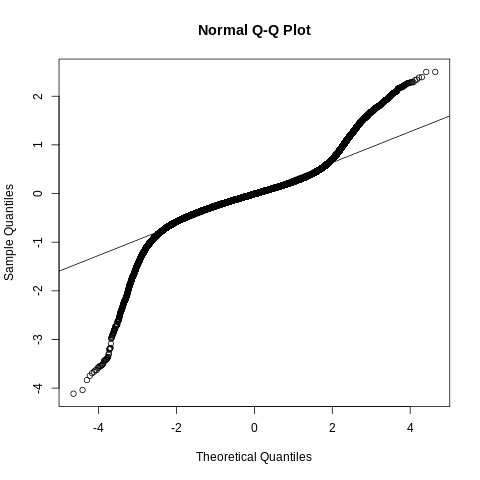

In [ ]:
%%R
qqnorm(residuals(fit.1a))
abline(0,sd(residuals(fit.1a)))

In [ ]:
%%R
confint(fit.1a)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.4841422296  3.6519234513  3.5680328405
fDimCat3             -0.1304449904 -0.1189269012 -0.1246859458
fDimCat4             -0.1355020944 -0.1233552903 -0.1294286924
fDimCat5             -0.1593276244 -0.1444176254 -0.1518726249
fDimCat6             -0.1575866629 -0.1377298817 -0.1476582723
fLactationNumberCat2  0.0981481743  0.1285000410  0.1133241076
fLactationNumberCat3  0.2244271545  0.2824723646  0.2534497596
fLactationNumberCat4  0.2967852814  0.3820414750  0.3394133782
fLactationNumberCat5  0.3877640990  0.5008266741  0.4442953865
fLactationNumberCat6  0.4393674430  0.5809346722  0.5101510576
fLactationNumberCat7  0.5102404345  0.6789348063  0.5945876204
fLactationNumberCat8  0.5151910123  0.7118087033  0.6134998578
fThiMeanCat0          0.0162130171  0.0472179471  0.0317154821
fThiMeanCat2          0.0121353124  0.0213413941  0.0167383532
fThiMeanCat3          0.0164151336  0.0268732466  0.021

In [ ]:
%%R
rm(fit.1a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2429070  129.8    6544737  349.6   5455844  291.4
Vcells 241450274 1842.2  456366874 3481.9 403341224 3077.3


### CMS parity (0-1)

In [ ]:
%%R
##CMS with Parity included in the model (1 vs > 1)

fit.1bb <- glmmTMB(SensorValue ~ fDimCat + Parity + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model1bb <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMeanCMS_par.R'
save(fit.1bb, file= url_model1bb)
summary(fit.1bb)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + Parity + fThiMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 494926.7  495314.4 -247429.4  494858.7    661520 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.491e-01 0.5908716       
              Day         5.178e-07 0.0007196 -0.74 
 Residual                 1.213e-01 0.3483065       
Number of obs: 661554, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          3.677646   0.031071  118.36  < 2e-16 ***
fDimCat3            -0.055079   0.002009  -27.42  < 2e-16 ***
fDimCat4            -0.078555   0.001913  -41.07  < 2e-16 ***
fDimCat5            -0.088025   0.001906  -46.18  < 2e-16 ***
fDimCat6            -0.113

In [ ]:
%%R
drop1(fit.1bb)

Single term deletions

Model:
SensorValue ~ fDimCat + Parity + fThiMeanCat + fYear + fMonth + 
    fHerdIdentifier + (1 + Day | AnimalEartag)
                Df    AIC
<none>             494927
fDimCat          4 498599
Parity           1 495009
fThiMeanCat      6 498509
fYear            3 495741
fMonth          11 629563
fHerdIdentifier  4 495047


### CMS Parity (0-1) and interaction

In [ ]:
%%R
##CMS with Parity (1 vs > 1) and interaction ThiMean and Parity (1 vs >1)
fit.1bbi <- glmmTMB(SensorValue ~ fDimCat + Parity + fThiMeanCat:Parity + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model1bbi <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMeanCMS_int.R'
save(fit.1bbi, file= url_model1bbi)
summary(fit.1bbi)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + Parity + fThiMeanCat:Parity + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 494822.8  495278.9 -247371.4  494742.8    661514 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.482e-01 0.5900751       
              Day         5.085e-07 0.0007131 -0.74 
 Residual                 1.213e-01 0.3482821       
Number of obs: 661554, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.657814   0.031338  116.72  < 2e-16 ***
fDimCat3             -0.054887   0.002009  -27.33  < 2e-16 ***
fDimCat4             -0.078123   0.001913  -40.83  < 2e-16 ***
fDimCat5             -0.087552   0.001907  -45.90  < 2e-16 ***
fDimCat6      

In [ ]:
%%R
drop1(fit.1bbi)

Single term deletions

Model:
SensorValue ~ fDimCat + Parity + fThiMeanCat:Parity + fYear + 
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
                   Df    AIC
<none>                494823
fDimCat             4 498466
fYear               3 495636
fMonth             11 629215
fHerdIdentifier     4 494942
Parity:fThiMeanCat 12 498509


### CMS Parity (1-8)

In [ ]:
%%R
##CMS with Parity (1-8) included in the model= "fLactationNumberCat"
fit.1b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model1b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMeanCMS.R'
save(fit.1b, file= url_model1b)
summary(fit.1b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 494580.1  495036.2 -247250.0  494500.1    661514 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.437e-01 0.5862457       
              Day         5.173e-07 0.0007192 -0.75 
 Residual                 1.213e-01 0.3482226       
Number of obs: 661554, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.670396   0.030912  118.74  < 2e-16 ***
fDimCat3             -0.055633   0.002024  -27.48  < 2e-16 ***
fDimCat4             -0.080092   0.002028  -39.49  < 2e-16 ***
fDimCat5             -0.090788   0.002296  -39.54  < 2e-16 ***
fDimCat6

In [ ]:
%%R
drop1(fit.1b)

Single term deletions

Model:
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + 
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
                    Df    AIC
<none>                 494580
fDimCat              4 496372
fLactationNumberCat  7 495009
fThiMeanCat          6 498152
fYear                3 495538
fMonth              11 629052
fHerdIdentifier      4 494704


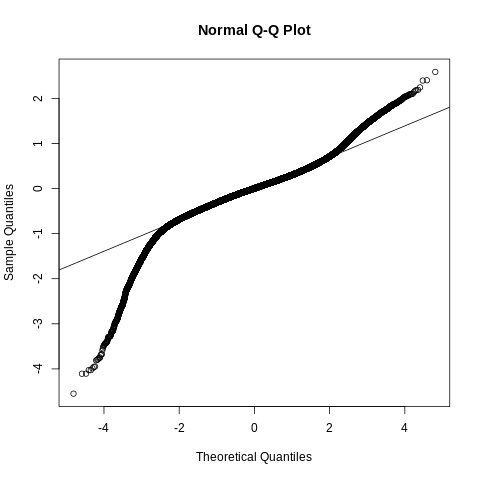

In [ ]:
%%R
qqnorm(residuals(fit.1b))
abline(0,sd(residuals(fit.1b)))

In [ ]:
%%R
confint(fit.1b)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.6098099493  3.7309811419  3.6703955456
fDimCat3             -0.0595999635 -0.0516654246 -0.0556326940
fDimCat4             -0.0840671833 -0.0761165545 -0.0800918689
fDimCat5             -0.0952888612 -0.0862880054 -0.0907884333
fDimCat6             -0.1231798395 -0.1120714016 -0.1176256206
fLactationNumberCat2 -0.0328080903 -0.0168351560 -0.0248216232
fLactationNumberCat3 -0.0263688088  0.0029038275 -0.0117324907
fLactationNumberCat4 -0.0536851477 -0.0108822115 -0.0322836796
fLactationNumberCat5 -0.0840449766 -0.0272153750 -0.0556301758
fLactationNumberCat6 -0.1171380287 -0.0443589102 -0.0807484695
fLactationNumberCat7 -0.2509350018 -0.1603869336 -0.2056609677
fLactationNumberCat8 -0.3161873618 -0.2047854621 -0.2604864120
fThiMeanCat0          0.0160926946  0.0314554271  0.0237740608
fThiMeanCat2          0.0133350143  0.0197841918  0.0165596030
fThiMeanCat3          0.0121273611  0.0197504971  0.015

In [ ]:
%%R
rm(fit.1b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2798485  149.5    6544737  349.6   6544737  349.6
Vcells 337905041 2578.1  665190489 5075.1 664659359 5071.0


In [ ]:
%%R
##DRY 
fit.1c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model1c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMeanDRY.R'
save(fit.1c, file= url_model1c)
summary(fit.1c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102225.3 102585.3 -51073.7 102147.3    75300 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.658e-01 0.5155975       
              Day         5.039e-07 0.0007099 -0.76 
 Residual                 2.031e-01 0.4506602       
Number of obs: 75339, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.619126   0.030812  117.46  < 2e-16 ***
fLactationNumberCat2 -0.183206   0.011173  -16.40  < 2e-16 ***
fLactationNumberCat3 -0.304000   0.014966  -20.31  < 2e-16 ***
fLactationNumberCat4 -0.382121   0.018042  -21.18  < 2e-16 ***
fLactationNumberCat5 -0.47764

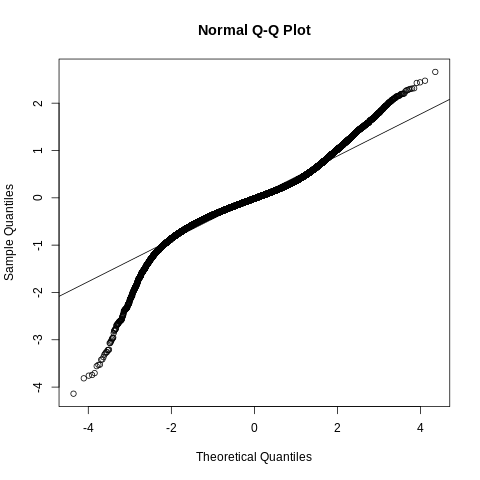

In [ ]:
%%R
qqnorm(residuals(fit.1c))
abline(0,sd(residuals(fit.1c)))

In [ ]:
%%R
confint(fit.1c)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.5587354898  3.6795169212  3.6191262055
fLactationNumberCat2 -0.2051053788 -0.1613065060 -0.1832059424
fLactationNumberCat3 -0.3333332966 -0.2746657040 -0.3039995003
fLactationNumberCat4 -0.4174825183 -0.3467589978 -0.3821207580
fLactationNumberCat5 -0.5193389534 -0.4359598011 -0.4776493773
fLactationNumberCat6 -0.6185074096 -0.5174020622 -0.5679547359
fLactationNumberCat7 -0.6449209181 -0.5121327606 -0.5785268393
fLactationNumberCat8 -0.8709453100 -0.6878686856 -0.7794069978
fThiMeanCat0          0.0253514596  0.0900705623  0.0577110109
fThiMeanCat2          0.0495114438  0.0755730062  0.0625422250
fThiMeanCat3          0.0607213501  0.0907312403  0.0757262952
fThiMeanCat4          0.0357036620  0.0690979525  0.0524008072
fThiMeanCat5          0.0244894121  0.0706369305  0.0475631713
fThiMeanCat6         -0.0725301341 -0.0043297423 -0.0384299382
fYear2018            -0.0861429319 -0.0480226340 -0.067

In [ ]:
%%R
rm(fit.1c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2798178  149.5    6544737  349.6   6544737  349.6
Vcells 281798633 2150.0  665190489 5075.1 664659359 5071.0


## Model THI max

In [ ]:
%%R
##AMS
fit.2a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model2a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMaxAMS.R'
save(fit.2a, file= url_model2a)
summary(fit.2a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
168003.7 168406.2 -83963.9 167927.7   293816 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 5.207e-01 0.7216193       
              Day         6.270e-07 0.0007918 -0.63 
 Residual                 1.015e-01 0.3185374       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.5710750  0.0426354   83.76  < 2e-16 ***
fDimCat3             -0.1249429  0.0029383  -42.52  < 2e-16 ***
fDimCat4             -0.1295533  0.0030985  -41.81  < 2e-16 ***
fDimCat5             -0.1522828  0.0038030  -40.04  < 2e-16 ***
fDimCat6       

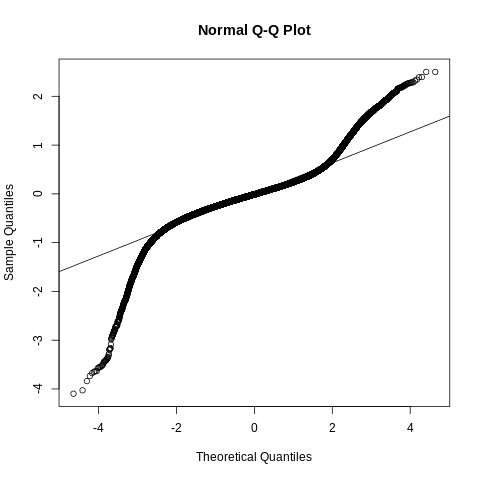

In [ ]:
%%R
qqnorm(residuals(fit.2a))
abline(0,sd(residuals(fit.2a)))

In [ ]:
%%R
confint(fit.2a)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.4875112181  3.6546388110  3.5710750145
fDimCat3             -0.1307018269 -0.1191840440 -0.1249429355
fDimCat4             -0.1356261927 -0.1234803739 -0.1295532833
fDimCat5             -0.1597366436 -0.1448290240 -0.1522828338
fDimCat6             -0.1582809886 -0.1384291016 -0.1483550451
fLactationNumberCat2  0.0968116307  0.1271552086  0.1119834196
fLactationNumberCat3  0.2219750800  0.2800010959  0.2509880879
fLactationNumberCat4  0.2935398866  0.3787651848  0.3361525357
fLactationNumberCat5  0.3835777615  0.4965961060  0.4400869337
fLactationNumberCat6  0.4347362553  0.5762443647  0.5054903100
fLactationNumberCat7  0.5045232451  0.6731451420  0.5888341936
fLactationNumberCat8  0.5088351482  0.7053682349  0.6071016916
fThiMaxCat0           0.0234241317  0.1431369507  0.0832805412
fThiMaxCat2          -0.0062638733  0.0029126001 -0.0016756366
fThiMaxCat3           0.0006640600  0.0112265914  0.005

In [ ]:
%%R
rm(fit.2a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2395392  128.0    6362260  339.8   6359933  339.7
Vcells 188838556 1440.8  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.2b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model2b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMaxCMS.R'
save(fit.2b, file= url_model2b)
summary(fit.2b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 494001.6  494457.7 -246960.8  493921.6    661514 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.374e-01 0.5808204       
              Day         5.103e-07 0.0007143 -0.75 
 Residual                 1.212e-01 0.3480772       
Number of obs: 661554, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.6721873  0.0306472  119.82  < 2e-16 ***
fDimCat3             -0.0557798  0.0020231  -27.57  < 2e-16 ***
fDimCat4             -0.0802533  0.0020260  -39.61  < 2e-16 ***
fDimCat5             -0.0912038  0.0022911  -39.81  < 2e-16 ***
fDim

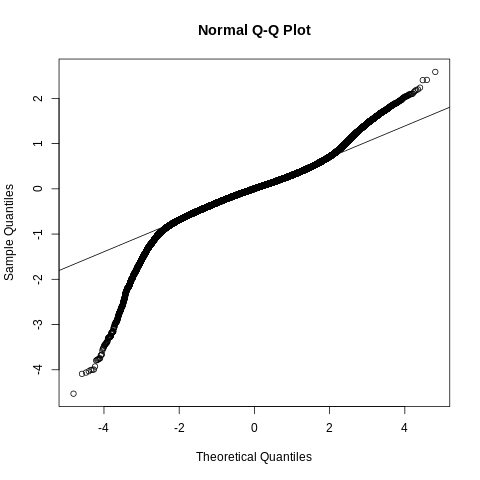

In [ ]:
%%R
qqnorm(residuals(fit.2b))
abline(0,sd(residuals(fit.2b)))

In [ ]:
%%R
confint(fit.2b)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.6121198185  3.732255e+00  3.6721873039
fDimCat3             -0.0597450047 -5.181452e-02 -0.0557797612
fDimCat4             -0.0842242489 -7.628228e-02 -0.0802532650
fDimCat5             -0.0956942639 -8.671336e-02 -0.0912038119
fDimCat6             -0.1235835047 -1.125114e-01 -0.1180474550
fLactationNumberCat2 -0.0345853357 -1.867282e-02 -0.0266290763
fLactationNumberCat3 -0.0291760330 -2.858352e-05 -0.0146023083
fLactationNumberCat4 -0.0570570333 -1.444658e-02 -0.0357518069
fLactationNumberCat5 -0.0874507416 -3.088218e-02 -0.0591664585
fLactationNumberCat6 -0.1200809746 -4.763056e-02 -0.0838557660
fLactationNumberCat7 -0.2535550472 -1.633911e-01 -0.2084730878
fLactationNumberCat8 -0.3177870297 -2.068102e-01 -0.2622986117
fThiMaxCat0          -0.0216313294  1.887071e-02 -0.0013803073
fThiMaxCat2          -0.0030508956  3.651514e-03  0.0003003094
fThiMaxCat3           0.0284395629  3.617658e-02  0.032

In [ ]:
%%R
rm(fit.2b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763261  147.6    6362260  339.8   6359933  339.7
Vcells 207114046 1580.2  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.2c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model2c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMaxDRY.R'
save(fit.2c, file= url_model2c)
summary(fit.2c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMaxCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102098.4 102458.4 -51010.2 102020.4    75300 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.627e-01 0.5125747       
              Day         4.968e-07 0.0007049 -0.76 
 Residual                 2.028e-01 0.4503388       
Number of obs: 75339, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.619024   0.030677  117.97  < 2e-16 ***
fLactationNumberCat2 -0.183130   0.011143  -16.43  < 2e-16 ***
fLactationNumberCat3 -0.304022   0.014921  -20.38  < 2e-16 ***
fLactationNumberCat4 -0.382775   0.017989  -21.28  < 2e-16 ***
fLactationNumberCat5 -0.478303

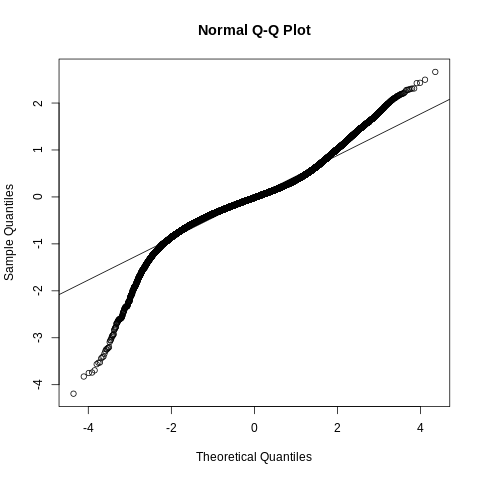

In [ ]:
%%R
qqnorm(residuals(fit.2c))
abline(0,sd(residuals(fit.2c)))

In [ ]:
%%R
confint(fit.2c)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.5588975196  3.6791505080  3.6190240138
fLactationNumberCat2 -0.2049699764 -0.1612904902 -0.1831302333
fLactationNumberCat3 -0.3332657561 -0.2747783848 -0.3040220705
fLactationNumberCat4 -0.4180327675 -0.3475166658 -0.3827747167
fLactationNumberCat5 -0.5198780134 -0.4367278442 -0.4783029288
fLactationNumberCat6 -0.6176789833 -0.5168327170 -0.5672558501
fLactationNumberCat7 -0.6415826149 -0.5091057172 -0.5753441661
fLactationNumberCat8 -0.8709881447 -0.6883558734 -0.7796720091
fThiMaxCat0          -0.1006397264  0.0753285705 -0.0126555780
fThiMaxCat2           0.0305009625  0.0585296488  0.0445153057
fThiMaxCat3           0.0922538143  0.1242659824  0.1082598984
fThiMaxCat4           0.1182041915  0.1522652414  0.1352347165
fThiMaxCat5           0.1165796783  0.1522120577  0.1343958680
fThiMaxCat6           0.0795403718  0.1183658484  0.0989531101
fYear2018            -0.0900738275 -0.0520905025 -0.071

In [ ]:
%%R
rm(fit.2c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2177201  116.3    6362260  339.8   6359933  339.7
Vcells 178932795 1365.2  443929596 3387.0 443929596 3387.0


## Model THI min

In [ ]:
%%R
##AMS
fit.3a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model3a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIminAMS.R'
save(fit.3a, file= url_model3a)
summary(fit.3a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167989.6 168392.0 -83956.8 167913.6   293816 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 5.266e-01 0.725690       
              Day         6.288e-07 0.000793 -0.63 
 Residual                 1.015e-01 0.318525       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.570555   0.042858   83.31  < 2e-16 ***
fDimCat3             -0.124777   0.002938  -42.47  < 2e-16 ***
fDimCat4             -0.129513   0.003099  -41.80  < 2e-16 ***
fDimCat5             -0.151805   0.003804  -39.91  < 2e-16 ***
fDimCat6             -0.

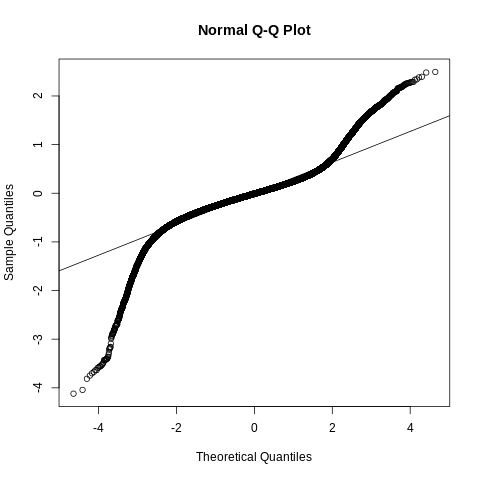

In [ ]:
%%R
qqnorm(residuals(fit.3a))
abline(0,sd(residuals(fit.3a)))

In [ ]:
%%R
confint(fit.3a)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.486555e+00  3.654554e+00  3.5705547131
fDimCat3             -1.305363e-01 -1.190185e-01 -0.1247774207
fDimCat4             -1.355863e-01 -1.234396e-01 -0.1295129625
fDimCat5             -1.592608e-01 -1.443501e-01 -0.1518054407
fDimCat6             -1.574745e-01 -1.376155e-01 -0.1475450179
fLactationNumberCat2  9.972302e-02  1.300918e-01  0.1149074139
fLactationNumberCat3  2.270434e-01  2.851192e-01  0.2560813250
fLactationNumberCat4  2.997659e-01  3.850581e-01  0.3424119653
fLactationNumberCat5  3.908541e-01  5.039577e-01  0.4474059131
fLactationNumberCat6  4.422535e-01  5.838637e-01  0.5130585790
fLactationNumberCat7  5.123212e-01  6.810610e-01  0.5966910625
fLactationNumberCat8  5.161771e-01  7.128395e-01  0.6145083077
fThiMinCat0           1.466736e-02  2.577760e-02  0.0202224813
fThiMinCat2           1.197753e-05  8.262703e-03  0.0041373401
fThiMinCat3          -1.083498e-02 -1.116868e-03 -0.005

In [ ]:
%%R
rm(fit.3a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2395562  128.0    6362260  339.8   6359933  339.7
Vcells 188840083 1440.8  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.3b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model3b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMinCMS.R'
save(fit.3b, file= url_model3b)
summary(fit.3b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 495650.0  496106.1 -247785.0  495570.0    661514 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.441e-01 0.586632       
              Day         5.198e-07 0.000721 -0.75 
 Residual                 1.215e-01 0.348508       
Number of obs: 661554, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.684573   0.030816  119.57  < 2e-16 ***
fDimCat3             -0.055511   0.002026  -27.40  < 2e-16 ***
fDimCat4             -0.080140   0.002029  -39.49  < 2e-16 ***
fDimCat5             -0.090720   0.002296  -39.51  < 2e-16 ***
fDimCat6     

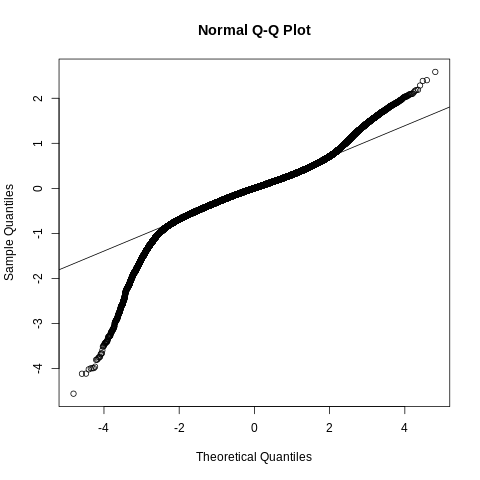

In [ ]:
%%R
qqnorm(residuals(fit.3b))
abline(0,sd(residuals(fit.3b)))

In [ ]:
%%R
confint(fit.3b)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.6241741149  3.744972e+00  3.6845732174
fDimCat3             -0.0594808682 -5.154024e-02 -0.0555105560
fDimCat4             -0.0841176060 -7.616275e-02 -0.0801401799
fDimCat5             -0.0952207689 -8.621961e-02 -0.0907201880
fDimCat6             -0.1232032749 -1.120993e-01 -0.1176513019
fLactationNumberCat2 -0.0326494421 -1.668487e-02 -0.0246671561
fLactationNumberCat3 -0.0264816887  2.768567e-03 -0.0118565607
fLactationNumberCat4 -0.0541397075 -1.137651e-02 -0.0327581101
fLactationNumberCat5 -0.0847975518 -2.802531e-02 -0.0564114332
fLactationNumberCat6 -0.1184528190 -4.574705e-02 -0.0820999366
fLactationNumberCat7 -0.2534305581 -1.629641e-01 -0.2081973242
fLactationNumberCat8 -0.3184599774 -2.071365e-01 -0.2627982480
fThiMinCat0          -0.0069237630 -1.812837e-05 -0.0034709457
fThiMinCat2          -0.0155608445 -9.731128e-03 -0.0126459861
fThiMinCat3          -0.0415960182 -3.491060e-02 -0.038

In [ ]:
%%R
rm(fit.3b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763279  147.6    6362260  339.8   6362260  339.8
Vcells 207115471 1580.2  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.3c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model3c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMinDRY.R'
save(fit.3c, file= url_model3c)
summary(fit.3c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMinCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102349.7 102709.7 -51135.9 102271.7    75300 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.674e-01 0.517150       
              Day         5.084e-07 0.000713 -0.76 
 Residual                 2.034e-01 0.451001       
Number of obs: 75339, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.633165   0.030890  117.62  < 2e-16 ***
fLactationNumberCat2 -0.183586   0.011195  -16.40  < 2e-16 ***
fLactationNumberCat3 -0.304897   0.014996  -20.33  < 2e-16 ***
fLactationNumberCat4 -0.382987   0.018077  -21.19  < 2e-16 ***
fLactationNumberCat5 -0.476329   0

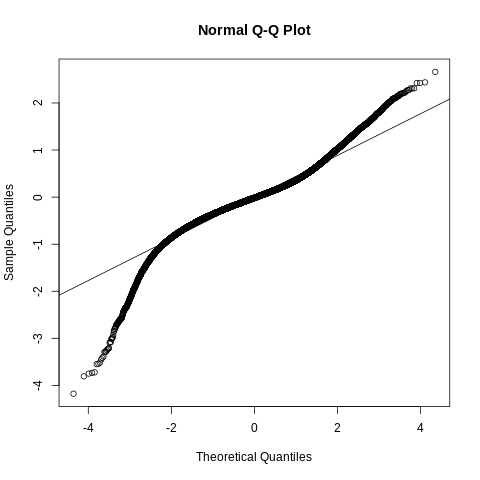

In [ ]:
%%R
qqnorm(residuals(fit.3c))
abline(0,sd(residuals(fit.3c)))

In [ ]:
%%R
confint(fit.3c)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.5726229697  3.6937080265  3.6331654981
fLactationNumberCat2 -0.2055272056 -0.1616449040 -0.1835860548
fLactationNumberCat3 -0.3342889761 -0.2755055433 -0.3048972597
fLactationNumberCat4 -0.4184171599 -0.3475576536 -0.3829874067
fLactationNumberCat5 -0.5180940252 -0.4345630500 -0.4763285376
fLactationNumberCat6 -0.6163123364 -0.5150365150 -0.5656744257
fLactationNumberCat7 -0.6432335120 -0.5102283026 -0.5767309073
fLactationNumberCat8 -0.8739532677 -0.6905717360 -0.7822625019
fThiMinCat0          -0.0271549716  0.0035240315 -0.0118154700
fThiMinCat2           0.0153976876  0.0387961208  0.0270969042
fThiMinCat3          -0.0088927801  0.0172367530  0.0041719864
fThiMinCat4           0.0041142089  0.0328343242  0.0184742665
fThiMinCat5          -0.0301294911  0.0087590352 -0.0106852280
fThiMinCat6          -0.0792634576 -0.0134159750 -0.0463397163
fYear2018            -0.0876906889 -0.0495165247 -0.068

In [ ]:
%%R
rm(fit.3c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2177366  116.3    6362260  339.8   6362260  339.8
Vcells 178934311 1365.2  443929596 3387.0 443929596 3387.0


## Model THI mean 1 day before

In [ ]:
%%R
##AMS
fit.4a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model4a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMean1daybeforeAMS.R'
save(fit.4a, file= url_model4a)
summary(fit.4a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167793.1 168195.6 -83858.5 167717.1   293816 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 5.288e-01 0.727162       
              Day         6.304e-07 0.000794 -0.63 
 Residual                 1.014e-01 0.318415       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             3.580104   0.043078   83.11  < 2e-16 ***
fDimCat3               -0.124532   0.002937  -42.40  < 2e-16 ***
fDimCat4               -0.129119   0.003098  -41.67  < 2e-16 ***
fDimCat5               -0.151242   0.003804  -39.76  < 2e-16 ***
fDi

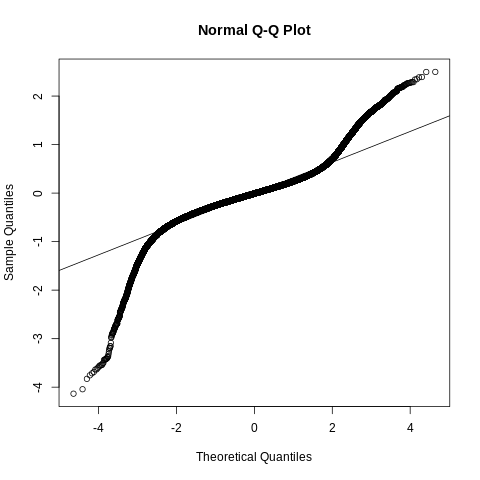

In [ ]:
%%R
qqnorm(residuals(fit.4a))
abline(0,sd(residuals(fit.4a)))

In [ ]:
%%R
confint(fit.4a)

                               2.5 %        97.5 %      Estimate
(Intercept)             3.4956721375  3.6645351627  3.5801036501
fDimCat3               -0.1302893485 -0.1187748679 -0.1245321082
fDimCat4               -0.1351917752 -0.1230467934 -0.1291192843
fDimCat5               -0.1586984065 -0.1437865804 -0.1512424934
fDimCat6               -0.1564348735 -0.1365712998 -0.1465030866
fLactationNumberCat2    0.0999938240  0.1303552818  0.1151745529
fLactationNumberCat3    0.2282341250  0.2863041452  0.2572691351
fLactationNumberCat4    0.3027107043  0.3880103307  0.3453605175
fLactationNumberCat5    0.3958983795  0.5090245177  0.4524614486
fLactationNumberCat6    0.4498058042  0.5914566169  0.5206312105
fLactationNumberCat7    0.5226064549  0.6913990876  0.6070027713
fLactationNumberCat8    0.5291525907  0.7258768501  0.6275147204
fThiMean1daybeforeCat0  0.0163750714  0.0471794597  0.0317772655
fThiMean1daybeforeCat2  0.0064365582  0.0156546658  0.0110456120
fThiMean1daybeforeCat3 -0

In [ ]:
%%R
rm(fit.4a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2395737  128.0    6362260  339.8   6362260  339.8
Vcells 188841623 1440.8  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.4b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model4b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelThiMean1daybeforeCMS.R'
save(fit.4b, file= url_model4b)
summary(fit.4b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 493540.8  493996.8 -246730.4  493460.8    661420 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.446e-01 0.5870683       
              Day         5.183e-07 0.0007199 -0.75 
 Residual                 1.211e-01 0.3479713       
Number of obs: 661460, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             3.681620   0.030844  119.36  < 2e-16 ***
fDimCat3               -0.055587   0.002023  -27.48  < 2e-16 ***
fDimCat4               -0.079994   0.002027  -39.47  < 2e-16 ***
fDimCat5               -0.090890   0.002294  -39.62  

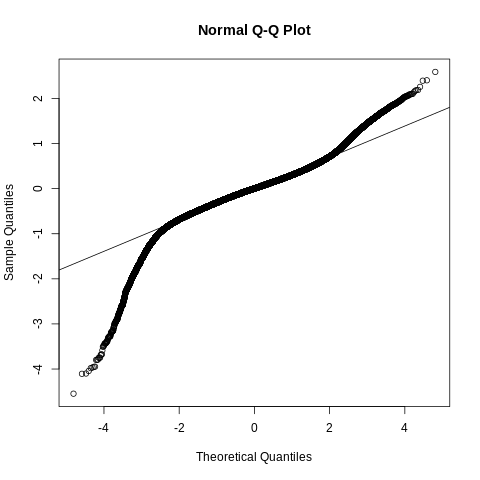

In [ ]:
%%R
qqnorm(residuals(fit.4b))
abline(0,sd(residuals(fit.4b)))

In [ ]:
%%R
confint(fit.4b)

                               2.5 %        97.5 %      Estimate
(Intercept)             3.6211668505  3.7420729876  3.6816199191
fDimCat3               -0.0595512312 -0.0516220734 -0.0555866523
fDimCat4               -0.0839666279 -0.0760221287 -0.0799943783
fDimCat5               -0.0953860987 -0.0863939278 -0.0908900132
fDimCat6               -0.1233690867 -0.1122739710 -0.1178215288
fLactationNumberCat2   -0.0329895315 -0.0170359306 -0.0250127311
fLactationNumberCat3   -0.0269247155  0.0023076766 -0.0123085195
fLactationNumberCat4   -0.0546162059 -0.0118758591 -0.0332460325
fLactationNumberCat5   -0.0852281877 -0.0284852086 -0.0568566982
fLactationNumberCat6   -0.1187280808 -0.0460618972 -0.0823949890
fLactationNumberCat7   -0.2530933497 -0.1626828087 -0.2078880792
fLactationNumberCat8   -0.3187848739 -0.2075434451 -0.2631641595
fThiMean1daybeforeCat0  0.0192911823  0.0346206235  0.0269559029
fThiMean1daybeforeCat2 -0.0003365158  0.0061068187  0.0028851514
fThiMean1daybeforeCat3  0

In [ ]:
%%R
rm(fit.4b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763505  147.6    6362260  339.8   6362260  339.8
Vcells 207443501 1582.7  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.4c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model4c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMean1daybeforeDRY.R'
save(fit.4c, file= url_model4c)
summary(fit.4c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMean1daybeforeCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
  102266   102626   -51094   102188    75290 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.664e-01 0.5161453       
              Day         5.049e-07 0.0007106 -0.76 
 Residual                 2.032e-01 0.4508176       
Number of obs: 75329, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             3.624787   0.030833  117.56  < 2e-16 ***
fLactationNumberCat2   -0.182814   0.011180  -16.35  < 2e-16 ***
fLactationNumberCat3   -0.303303   0.014977  -20.25  < 2e-16 ***
fLactationNumberCat4   -0.381892   0.018054  -21.15  < 2e-16 ***
fLactatio

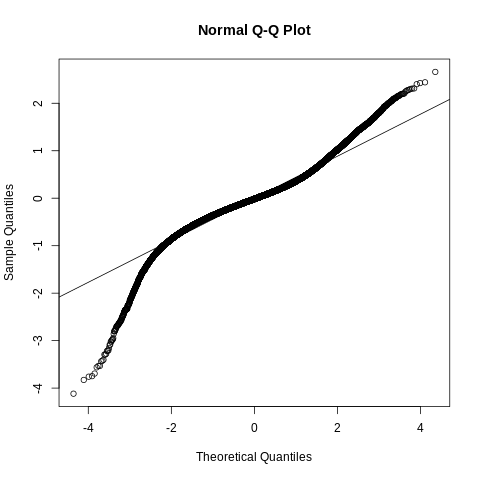

In [ ]:
%%R
qqnorm(residuals(fit.4c))
abline(0,sd(residuals(fit.4c)))

In [ ]:
%%R
confint(fit.4c)

                               2.5 %        97.5 %     Estimate
(Intercept)             3.5643557377  3.6852192301  3.624787484
fLactationNumberCat2   -0.2047263233 -0.1609010847 -0.182813704
fLactationNumberCat3   -0.3326577354 -0.2739480652 -0.303302900
fLactationNumberCat4   -0.4172778074 -0.3465071300 -0.381892469
fLactationNumberCat5   -0.5191935242 -0.4357641055 -0.477478815
fLactationNumberCat6   -0.6177940272 -0.5166335473 -0.567213787
fLactationNumberCat7   -0.6433669698 -0.5105145739 -0.576940772
fLactationNumberCat8   -0.8694411582 -0.6862743320 -0.777857745
fThiMean1daybeforeCat0 -0.0104948551  0.0535764964  0.021540821
fThiMean1daybeforeCat2  0.0245641986  0.0507786601  0.037671429
fThiMean1daybeforeCat3  0.0279692314  0.0582278787  0.043098555
fThiMean1daybeforeCat4 -0.0003657616  0.0332386696  0.016436454
fThiMean1daybeforeCat5 -0.0272850334  0.0192407444 -0.004022145
fThiMean1daybeforeCat6 -0.1277962336 -0.0590695052 -0.093432869
fYear2018              -0.0854770135 -0.

In [ ]:
%%R
rm(fit.4c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2177529  116.3    6362260  339.8   6362260  339.8
Vcells 178973061 1365.5  443929596 3387.0 443929596 3387.0


##Model THI mean 2 days before

In [ ]:
%%R
##AMS
fit.5a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model5a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMean2daysbeforeAMS.R'
save(fit.5a, file= url_model5a)
summary(fit.5a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167669.3 168071.7 -83796.6 167593.3   293816 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 5.302e-01 0.7281762       
              Day         6.315e-07 0.0007947 -0.63 
 Residual                 1.013e-01 0.3183476       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              3.581447   0.043124   83.05  < 2e-16 ***
fDimCat3                -0.124448   0.002937  -42.37  < 2e-16 ***
fDimCat4                -0.128977   0.003098  -41.64  < 2e-16 ***
fDimCat5                -0.150999   0.003803  -39.70  < 2e-

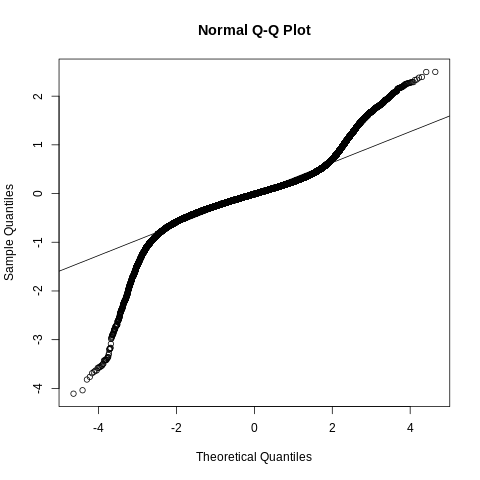

In [ ]:
%%R
qqnorm(residuals(fit.5a))
abline(0,sd(residuals(fit.5a)))

In [ ]:
%%R
confint(fit.5a)

                                2.5 %        97.5 %      Estimate
(Intercept)              3.4969260502  3.6659687284  3.5814473893
fDimCat3                -0.1302036199 -0.1186915102 -0.1244475650
fDimCat4                -0.1350481002 -0.1229055320 -0.1289768161
fDimCat5                -0.1584537817 -0.1435445733 -0.1509991775
fDimCat6                -0.1561022677 -0.1362423842 -0.1461723260
fLactationNumberCat2     0.1004093180  0.1307650308  0.1155871744
fLactationNumberCat3     0.2289874339  0.2870462161  0.2580168250
fLactationNumberCat4     0.3038128288  0.3890961911  0.3464545100
fLactationNumberCat5     0.3973347606  0.5104393699  0.4538870653
fLactationNumberCat6     0.4514109319  0.5930348512  0.5222228915
fLactationNumberCat7     0.5244271322  0.6931872523  0.6088071922
fLactationNumberCat8     0.5308985463  0.7275848035  0.6292416749
fThiMean2daysbeforeCat0  0.0366723660  0.0674624367  0.0520674013
fThiMean2daysbeforeCat2  0.0007663746  0.0099752446  0.0053708096
fThiMean2d

In [ ]:
%%R
rm(fit.5a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2395784  128.0    6362260  339.8   6362260  339.8
Vcells 188841755 1440.8  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.5b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model5b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelThiMean2daysbeforeCMS.R'
save(fit.5b, file= url_model5b)
summary(fit.5b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 493363.4  493819.5 -246641.7  493283.4    661326 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.421e-01 0.584873       
              Day         5.156e-07 0.000718 -0.75 
 Residual                 1.211e-01 0.347946       
Number of obs: 661366, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              3.675570   0.030803  119.32  < 2e-16 ***
fDimCat3                -0.055581   0.002023  -27.48  < 2e-16 ***
fDimCat4                -0.080092   0.002026  -39.53  < 2e-16 ***
fDimCat5                -0.091154   0.002293  -39.76

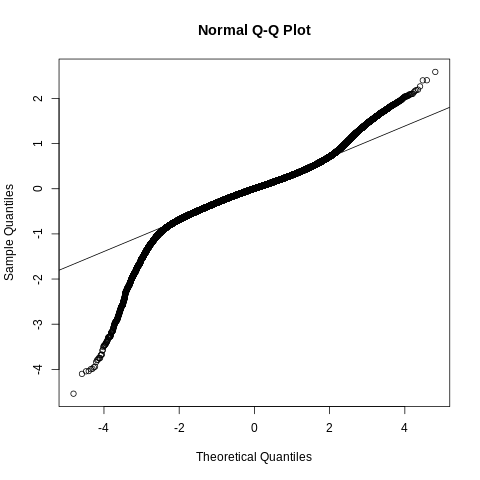

In [ ]:
%%R
qqnorm(residuals(fit.5b))
abline(0,sd(residuals(fit.5b)))

In [ ]:
%%R
confint(fit.5b)

                                2.5 %       97.5 %      Estimate
(Intercept)              3.6151969137  3.735943757  3.6755703352
fDimCat3                -0.0595451366 -0.051616401 -0.0555807688
fDimCat4                -0.0840635107 -0.076120995 -0.0800922530
fDimCat5                -0.0956473437 -0.086660712 -0.0911540281
fDimCat6                -0.1237966038 -0.112712155 -0.1182543795
fLactationNumberCat2    -0.0340140251 -0.018079470 -0.0260467477
fLactationNumberCat3    -0.0286461185  0.000546650 -0.0140497343
fLactationNumberCat4    -0.0568676436 -0.014187147 -0.0355273955
fLactationNumberCat5    -0.0878850143 -0.031221307 -0.0595531609
fLactationNumberCat6    -0.1218492631 -0.049280373 -0.0855648183
fLactationNumberCat7    -0.2563875175 -0.166087777 -0.2112376471
fLactationNumberCat8    -0.3222469667 -0.211125379 -0.2666861731
fThiMean2daysbeforeCat0  0.0077742672  0.023096691  0.0154354792
fThiMean2daysbeforeCat2  0.0202891224  0.026706378  0.0234977500
fThiMean2daysbeforeCat3  

In [ ]:
%%R
rm(fit.5b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763298  147.6    6362260  339.8   6362260  339.8
Vcells 207438939 1582.7  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.5c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model5c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMean2daysbeforeDRY.R'
save(fit.5c, file= url_model5c)
summary(fit.5c)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102251.1 102611.0 -51086.5 102173.1    75279 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.661e-01 0.5158714       
              Day         5.052e-07 0.0007107 -0.76 
 Residual                 2.032e-01 0.4508191       
Number of obs: 75318, groups:  AnimalEartag, 1874

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              3.626692   0.030852  117.55  < 2e-16 ***
fLactationNumberCat2    -0.183027   0.011179  -16.37  < 2e-16 ***
fLactationNumberCat3    -0.303596   0.014976  -20.27  < 2e-16 ***
fLactationNumberCat4    -0.382094   0.018052  -21.17  < 2e-16 ***
fLac

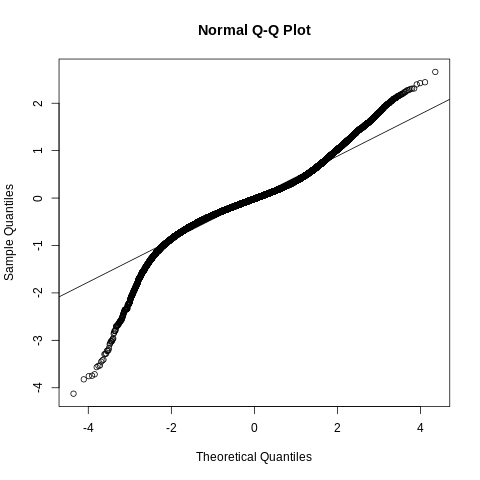

In [ ]:
%%R
qqnorm(residuals(fit.5c))
abline(0,sd(residuals(fit.5c)))

In [ ]:
%%R
confint(fit.5c)

                               2.5 %        97.5 %      Estimate
(Intercept)              3.566223301  3.6871608186  3.6266920599
fLactationNumberCat2    -0.204937497 -0.1611168060 -0.1830271514
fLactationNumberCat3    -0.332948783 -0.2742428816 -0.3035958323
fLactationNumberCat4    -0.417475761 -0.3467118424 -0.3820938018
fLactationNumberCat5    -0.519318536 -0.4358941440 -0.4776063399
fLactationNumberCat6    -0.617598135 -0.5164374933 -0.5670178141
fLactationNumberCat7    -0.643175749 -0.5103156833 -0.5767457161
fLactationNumberCat8    -0.870418319 -0.6872318014 -0.7788250603
fThiMean2daysbeforeCat0 -0.039836011  0.0237121381 -0.0080619367
fThiMean2daysbeforeCat2  0.029034800  0.0552303461  0.0421325730
fThiMean2daysbeforeCat3  0.016886217  0.0472306069  0.0320584119
fThiMean2daysbeforeCat4 -0.014311395  0.0193831711  0.0025358878
fThiMean2daysbeforeCat5 -0.032596055  0.0139673370 -0.0093143591
fThiMean2daysbeforeCat6 -0.124804357 -0.0554161478 -0.0901102525
fYear2018               -

In [ ]:
%%R
rm(fit.5c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2177557  116.3    6362260  339.8   6362260  339.8
Vcells 178972589 1365.5  443929596 3387.0 443929596 3387.0


## Model Temp mean

In [ ]:
%%R
##AMS
fit.6a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model6a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMeanAMS.R'
save(fit.6a, file= url_model6a)
summary(fit.6a)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167978.0 168380.4 -83951.0 167902.0   293816 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 5.266e-01 0.725703       
              Day         6.384e-07 0.000799 -0.63 
 Residual                 1.015e-01 0.318523       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.563549   0.042752   83.35  < 2e-16 ***
fDimCat3             -0.124879   0.002938  -42.50  < 2e-16 ***
fDimCat4             -0.129521   0.003098  -41.80  < 2e-16 ***
fDimCat5             -0.151968   0.003803  -39.96  < 2e-16 ***
fDimCat6             -0

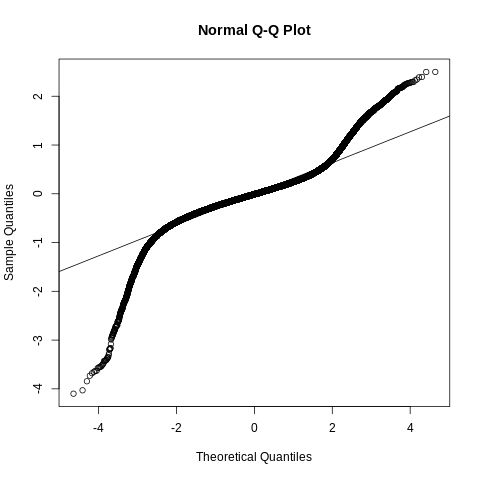

In [ ]:
%%R
qqnorm(residuals(fit.6a))
abline(0,sd(residuals(fit.6a)))

In [ ]:
%%R
confint(fit.6a)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.4797567623  3.6473414127  3.5635490875
fDimCat3             -0.1306379505 -0.1191205778 -0.1248792641
fDimCat4             -0.1355935559 -0.1234481804 -0.1295208682
fDimCat5             -0.1594211622 -0.1445144294 -0.1519677958
fDimCat6             -0.1579959183 -0.1381464244 -0.1480711714
fLactationNumberCat2  0.0981370115  0.1284833167  0.1133101641
fLactationNumberCat3  0.2239383111  0.2819659345  0.2529521228
fLactationNumberCat4  0.2955426255  0.3807637756  0.3381532006
fLactationNumberCat5  0.3850667586  0.4980736793  0.4415702189
fLactationNumberCat6  0.4350819939  0.5765710354  0.5058265146
fLactationNumberCat7  0.5037036294  0.6723015381  0.5880025837
fLactationNumberCat8  0.5061758804  0.7026838240  0.6044298522
fTempMeanCat0         0.0276545157  0.0417888328  0.0347216742
fTempMeanCat2         0.0014064493  0.0102499759  0.0058282126
fTempMeanCat3         0.0150220532  0.0255851151  0.020

In [ ]:
%%R
rm(fit.6a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2395972  128.0    6362260  339.8   6362260  339.8
Vcells 188843472 1440.8  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.6b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model6b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMeanCMS.R'
save(fit.6b, file= url_model6b)
summary(fit.6b)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 492014.5  492470.6 -245967.2  491934.5    661514 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.457e-01 0.5879977       
              Day         5.174e-07 0.0007193 -0.75 
 Residual                 1.208e-01 0.3475531       
Number of obs: 661554, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.680425   0.030887  119.16  < 2e-16 ***
fDimCat3             -0.055686   0.002020  -27.56  < 2e-16 ***
fDimCat4             -0.079832   0.002025  -39.42  < 2e-16 ***
fDimCat5             -0.090448   0.002294  -39.43  < 2e-16 ***
fDimCat6

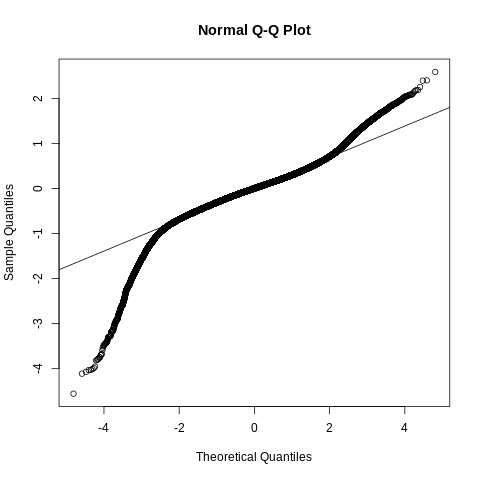

In [ ]:
%%R
qqnorm(residuals(fit.6b))
abline(0,sd(residuals(fit.6b)))

In [ ]:
%%R
confint(fit.6b)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.6198875522  3.7409631486  3.6804253504
fDimCat3             -0.0596460699 -0.0517263078 -0.0556861889
fDimCat4             -0.0838012329 -0.0758631739 -0.0798322034
fDimCat5             -0.0949434212 -0.0859518829 -0.0904476521
fDimCat6             -0.1225841811 -0.1114817655 -0.1170329733
fLactationNumberCat2 -0.0319742987 -0.0160018014 -0.0239880501
fLactationNumberCat3 -0.0245871157  0.0046886312 -0.0099492422
fLactationNumberCat4 -0.0510706721 -0.0082645609 -0.0296676165
fLactationNumberCat5 -0.0805778927 -0.0237477265 -0.0521628096
fLactationNumberCat6 -0.1126949174 -0.0399225718 -0.0763087446
fLactationNumberCat7 -0.2449789734 -0.1544542232 -0.1997165983
fLactationNumberCat8 -0.3087188335 -0.1973695831 -0.2530442083
fTempMeanCat0         0.0134320757  0.0228511180  0.0181415969
fTempMeanCat2         0.0037260088  0.0098065462  0.0067662775
fTempMeanCat3         0.0059438854  0.0134211603  0.009

In [ ]:
%%R
rm(fit.6b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763836  147.7    6362260  339.8   6362260  339.8
Vcells 207118951 1580.2  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.6c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model6c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMeanDRY.R'
save(fit.6c, file= url_model6c)
summary(fit.6c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102078.7 102438.6 -51000.3 102000.7    75300 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.638e-01 0.5136499       
              Day         5.005e-07 0.0007075 -0.76 
 Residual                 2.027e-01 0.4502404       
Number of obs: 75339, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.617118   0.030806  117.42  < 2e-16 ***
fLactationNumberCat2 -0.182176   0.011155  -16.33  < 2e-16 ***
fLactationNumberCat3 -0.302215   0.014940  -20.23  < 2e-16 ***
fLactationNumberCat4 -0.381504   0.018011  -21.18  < 2e-16 ***
fLactationNumberCat5 -0.4791

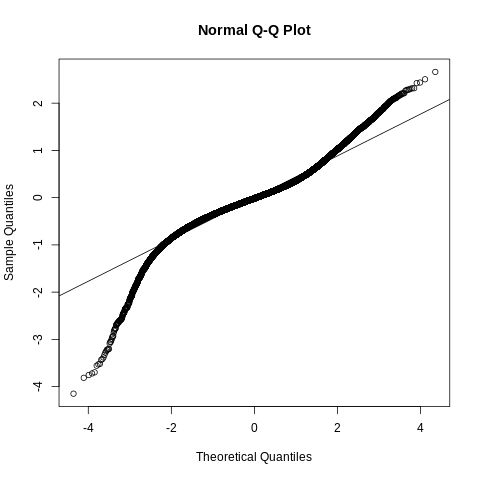

In [ ]:
%%R
qqnorm(residuals(fit.6c))
abline(0,sd(residuals(fit.6c)))

In [ ]:
%%R
confint(fit.6c)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.5567392519  3.6774959338  3.6171175928
fLactationNumberCat2 -0.2040399818 -0.1603118688 -0.1821759253
fLactationNumberCat3 -0.3314965854 -0.2729341448 -0.3022153651
fLactationNumberCat4 -0.4168059782 -0.3462029500 -0.3815044641
fLactationNumberCat5 -0.5208061152 -0.4375522622 -0.4791791887
fLactationNumberCat6 -0.6195787963 -0.5186096751 -0.5690942357
fLactationNumberCat7 -0.6434168852 -0.5107855923 -0.5771012387
fLactationNumberCat8 -0.8687020162 -0.6858471824 -0.7772745993
fTempMeanCat0        -0.0028557405  0.0380942423  0.0176192509
fTempMeanCat2         0.0768473564  0.1023295815  0.0895884690
fTempMeanCat3         0.0915470322  0.1219758997  0.1067614660
fTempMeanCat4         0.0660588056  0.1041178027  0.0850883042
fTempMeanCat5        -0.0203788479  0.0405120366  0.0100665943
fTempMeanCat6        -0.1670942062 -0.0514393437 -0.1092667749
fYear2018            -0.0876851475 -0.0496527702 -0.068

In [ ]:
%%R
rm(fit.6c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2177776  116.4    6362260  339.8   6362260  339.8
Vcells 178937700 1365.2  443929596 3387.0 443929596 3387.0


## Model Temp max

In [ ]:
%%R
##AMS
fit.7a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model7a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMaxAMS.R'
save(fit.7a, file= url_model7a)
summary(fit.7a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167850.9 168253.4 -83887.5 167774.9   293816 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 5.215e-01 0.7221485       
              Day         6.285e-07 0.0007928 -0.63 
 Residual                 1.014e-01 0.3184546       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.5693713  0.0426123   83.76  < 2e-16 ***
fDimCat3             -0.1251064  0.0029375  -42.59  < 2e-16 ***
fDimCat4             -0.1296340  0.0030974  -41.85  < 2e-16 ***
fDimCat5             -0.1523422  0.0038014  -40.07  < 2e-16 ***
fDimCat6      

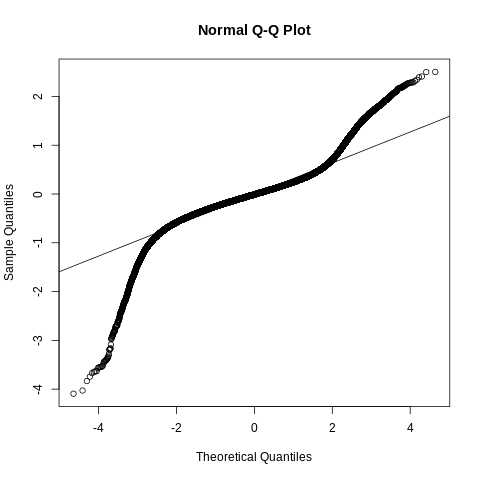

In [ ]:
%%R
qqnorm(residuals(fit.7a))
abline(0,sd(residuals(fit.7a)))

In [ ]:
%%R
confint(fit.7a)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.4858527959  3.6528897990  3.5693712975
fDimCat3             -0.1308637322 -0.1193490238 -0.1251063780
fDimCat4             -0.1357047331 -0.1235632265 -0.1296339798
fDimCat5             -0.1597928342 -0.1448915012 -0.1523421677
fDimCat6             -0.1584681591 -0.1386259727 -0.1485470659
fLactationNumberCat2  0.0966913915  0.1270220703  0.1118567309
fLactationNumberCat3  0.2216532248  0.2796519278  0.2506525763
fLactationNumberCat4  0.2928891056  0.3780719045  0.3354805050
fLactationNumberCat5  0.3823848985  0.4953448089  0.4388648537
fLactationNumberCat6  0.4330582337  0.5744915265  0.5037748801
fLactationNumberCat7  0.5027583368  0.6712900299  0.5870241834
fLactationNumberCat8  0.5068329590  0.7032629901  0.6050479745
fTempMaxCat0          0.0408124537  0.0644529210  0.0526326873
fTempMaxCat2         -0.0050256095  0.0032149853 -0.0009053121
fTempMaxCat3          0.0023223020  0.0127695624  0.007

In [ ]:
%%R
rm(fit.7a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2396459  128.0    6362260  339.8   6362260  339.8
Vcells 188848773 1440.9  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.7b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model7b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMaxCMS.R'
save(fit.7b, file= url_model7b)
summary(fit.7b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 492372.7  492828.8 -246146.4  492292.7    661514 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.374e-01 0.5808654       
              Day         5.078e-07 0.0007126 -0.75 
 Residual                 1.209e-01 0.3476512       
Number of obs: 661554, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.677560   0.030663  119.94  < 2e-16 ***
fDimCat3             -0.055892   0.002021  -27.66  < 2e-16 ***
fDimCat4             -0.080083   0.002024  -39.57  < 2e-16 ***
fDimCat5             -0.091097   0.002290  -39.78  < 2e-16 ***
fDimCat6

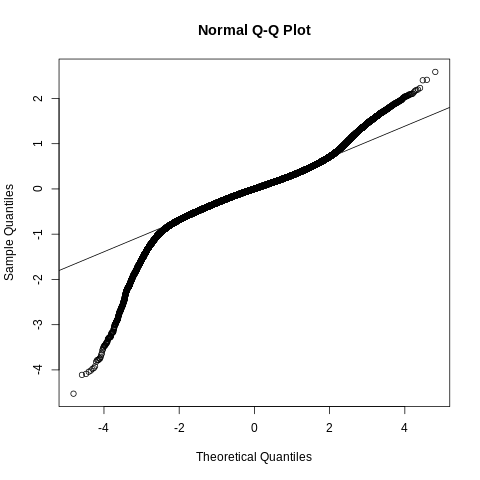

In [ ]:
%%R
qqnorm(residuals(fit.7b))
abline(0,sd(residuals(fit.7b)))

In [ ]:
%%R
confint(fit.7b)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.6174622962  3.7376579041  3.6775601002
fDimCat3             -0.0598528818 -0.0519317280 -0.0558923049
fDimCat4             -0.0840501521 -0.0761159343 -0.0800830432
fDimCat5             -0.0955846696 -0.0866089003 -0.0910967849
fDimCat6             -0.1234645528 -0.1123950173 -0.1179297851
fLactationNumberCat2 -0.0345117920 -0.0186005063 -0.0265561492
fLactationNumberCat3 -0.0288124542  0.0003383362 -0.0142370590
fLactationNumberCat4 -0.0559195109 -0.0133003997 -0.0346099553
fLactationNumberCat5 -0.0851528810 -0.0285697303 -0.0568613056
fLactationNumberCat6 -0.1168221544 -0.0443522819 -0.0805872181
fLactationNumberCat7 -0.2489332343 -0.1587510574 -0.2038421458
fLactationNumberCat8 -0.3114201925 -0.2004364454 -0.2559283190
fTempMaxCat0          0.0019461207  0.0170716030  0.0095088619
fTempMaxCat2          0.0022139733  0.0083003328  0.0052571530
fTempMaxCat3          0.0416643505  0.0493306948  0.045

In [ ]:
%%R
rm(fit.7b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763861  147.7    6362260  339.8   6362260  339.8
Vcells 207118831 1580.2  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.7c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model7c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMaxDRY.R'
save(fit.7c, file= url_model7c)
summary(fit.7c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMaxCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102074.2 102434.2 -50998.1 101996.2    75300 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.625e-01 0.5123190       
              Day         4.954e-07 0.0007039 -0.76 
 Residual                 2.028e-01 0.4502777       
Number of obs: 75339, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.616780   0.030687  117.86  < 2e-16 ***
fLactationNumberCat2 -0.182999   0.011140  -16.43  < 2e-16 ***
fLactationNumberCat3 -0.303503   0.014915  -20.35  < 2e-16 ***
fLactationNumberCat4 -0.382379   0.017981  -21.27  < 2e-16 ***
fLactationNumberCat5 -0.47817

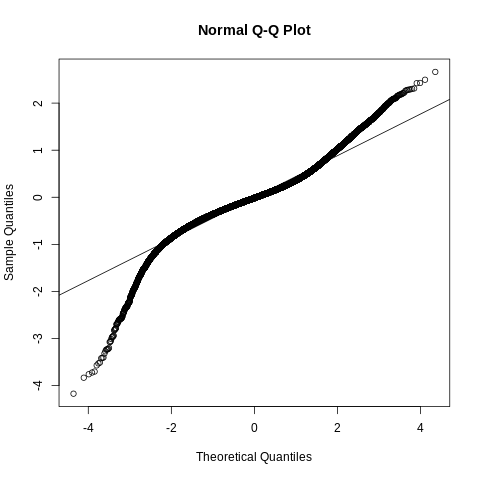

In [ ]:
%%R
qqnorm(residuals(fit.7c))
abline(0,sd(residuals(fit.7c)))

In [ ]:
%%R
confint(fit.7c)

                             2.5 %       97.5 %     Estimate
(Intercept)           3.5566358776  3.676924929  3.616780403
fLactationNumberCat2 -0.2048315925 -0.161165455 -0.182998524
fLactationNumberCat3 -0.3327355445 -0.274270174 -0.303502859
fLactationNumberCat4 -0.4176218229 -0.347135784 -0.382378804
fLactationNumberCat5 -0.5197308553 -0.436617227 -0.478174041
fLactationNumberCat6 -0.6169703103 -0.516175550 -0.566572930
fLactationNumberCat7 -0.6408541695 -0.508450865 -0.574652517
fLactationNumberCat8 -0.8695149886 -0.686991503 -0.778253246
fTempMaxCat0         -0.0125131862  0.048569688  0.018028251
fTempMaxCat2          0.0275740916  0.053430123  0.040502107
fTempMaxCat3          0.0996092533  0.131875437  0.115742345
fTempMaxCat4          0.1246719713  0.159100894  0.141886433
fTempMaxCat5          0.0960508005  0.134388302  0.115219551
fTempMaxCat6          0.0535610759  0.098885436  0.076223256
fYear2018            -0.0896851374 -0.051713988 -0.070699563
fYear2019            -0.

In [ ]:
%%R
rm(fit.7c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2177801  116.4    6362260  339.8   6362260  339.8
Vcells 178937580 1365.2  443929596 3387.0 443929596 3387.0


## Model Temp min

In [ ]:
%%R
##AMS
fit.8a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model8a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMinAMS.R'
save(fit.8a, file= url_model8a)
summary(fit.8a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
168023.9 168426.4 -83974.0 167947.9   293816 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 5.283e-01 0.7268215       
              Day         6.361e-07 0.0007976 -0.63 
 Residual                 1.015e-01 0.3185407       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.563e+00  4.286e-02   83.15  < 2e-16 ***
fDimCat3             -1.247e-01  2.938e-03  -42.45  < 2e-16 ***
fDimCat4             -1.295e-01  3.099e-03  -41.79  < 2e-16 ***
fDimCat5             -1.518e-01  3.804e-03  -39.91  < 2e-16 ***
fDimCat6      

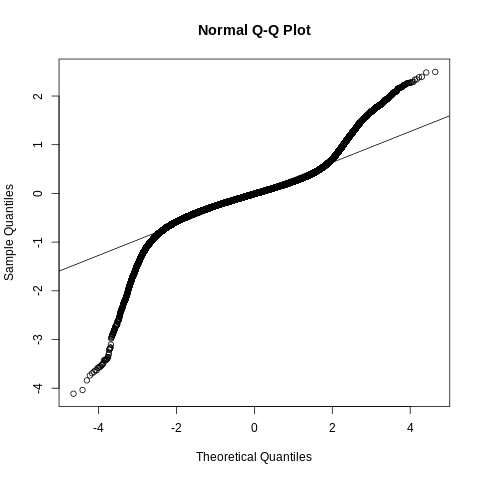

In [ ]:
%%R
qqnorm(residuals(fit.8a))
abline(0,sd(residuals(fit.8a)))

In [ ]:
%%R
confint(fit.8a)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.4794456943  3.6474370786  3.563441e+00
fDimCat3             -0.1304860596 -0.1189675996 -1.247268e-01
fDimCat4             -0.1355708258 -0.1234233733 -1.294971e-01
fDimCat5             -0.1592813841 -0.1443695742 -1.518255e-01
fDimCat6             -0.1575631609 -0.1377031881 -1.476332e-01
fLactationNumberCat2  0.0993168336  0.1296865864  1.145017e-01
fLactationNumberCat3  0.2262127687  0.2842894529  2.552511e-01
fLactationNumberCat4  0.2986586108  0.3839519164  3.413053e-01
fLactationNumberCat5  0.3894293566  0.5025327998  4.459811e-01
fLactationNumberCat6  0.4405665643  0.5821746132  5.113706e-01
fLactationNumberCat7  0.5104813987  0.6792163358  5.948489e-01
fLactationNumberCat8  0.5140031089  0.7106593147  6.123312e-01
fTempMinCat0          0.0138516337  0.0227790100  1.831532e-02
fTempMinCat2         -0.0046717377  0.0023992606 -1.136239e-03
fTempMinCat3         -0.0043104593  0.0044767732  8.315

In [ ]:
%%R
rm(fit.8a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2396479  128.0    6362260  339.8   6362260  339.8
Vcells 188848648 1440.9  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.8b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model8b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMinCMS.R'
save(fit.8b, file= url_model8b)
summary(fit.8b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 495983.7  496439.8 -247951.8  495903.7    661514 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.449e-01 0.5872735       
              Day         5.214e-07 0.0007221 -0.75 
 Residual                 1.215e-01 0.3485951       
Number of obs: 661554, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.122 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.679398   0.030844  119.29  < 2e-16 ***
fDimCat3             -0.055487   0.002026  -27.38  < 2e-16 ***
fDimCat4             -0.080138   0.002030  -39.48  < 2e-16 ***
fDimCat5             -0.090653   0.002297  -39.46  < 2e-16 ***
fDimCat6

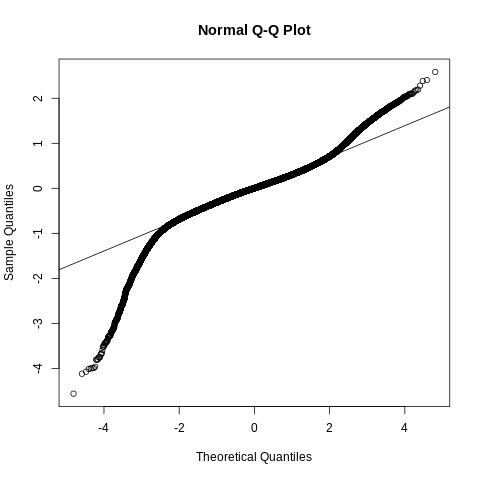

In [ ]:
%%R
qqnorm(residuals(fit.8b))
abline(0,sd(residuals(fit.8b)))

In [ ]:
%%R
confint(fit.8b)

                            2.5 %        97.5 %      Estimate
(Intercept)           3.618945008  3.7398518163  3.6793984121
fDimCat3             -0.059457868 -0.0515152164 -0.0554865421
fDimCat4             -0.084116569 -0.0761593552 -0.0801379621
fDimCat5             -0.095155043 -0.0861505305 -0.0906527866
fDimCat6             -0.123013297 -0.1119041770 -0.1174587372
fLactationNumberCat2 -0.032433657 -0.0164598415 -0.0244467492
fLactationNumberCat3 -0.026092144  0.0031751594 -0.0114584923
fLactationNumberCat4 -0.053571829 -0.0107832489 -0.0321775388
fLactationNumberCat5 -0.084179558 -0.0273747589 -0.0557771587
fLactationNumberCat6 -0.117666711 -0.0449214685 -0.0812940898
fLactationNumberCat7 -0.252683798 -0.1621722718 -0.2074280351
fLactationNumberCat8 -0.317968634 -0.2065955280 -0.2622820812
fTempMinCat0         -0.006513990 -0.0005986870 -0.0035563387
fTempMinCat2          0.002475295  0.0077490192  0.0051121572
fTempMinCat3         -0.017512022 -0.0111996538 -0.0143558379
fTempMin

In [ ]:
%%R
rm(fit.8b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763902  147.7    6362260  339.8   6362260  339.8
Vcells 207118943 1580.2  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.8c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model8c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMinDRY.R'
save(fit.8c, file= url_model8c)
summary(fit.8c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMinCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102305.7 102665.7 -51113.8 102227.7    75300 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.665e-01 0.5162172       
              Day         5.078e-07 0.0007126 -0.76 
 Residual                 2.033e-01 0.4508757       
Number of obs: 75339, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.624012   0.030970  117.02  < 2e-16 ***
fLactationNumberCat2 -0.183112   0.011184  -16.37  < 2e-16 ***
fLactationNumberCat3 -0.304475   0.014982  -20.32  < 2e-16 ***
fLactationNumberCat4 -0.382935   0.018061  -21.20  < 2e-16 ***
fLactationNumberCat5 -0.47678

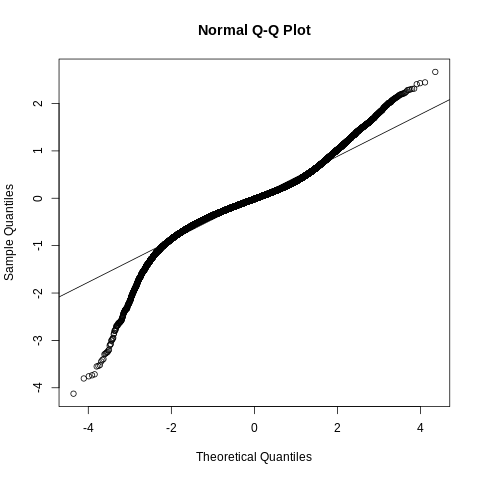

In [ ]:
%%R
qqnorm(residuals(fit.8c))
abline(0,sd(residuals(fit.8c)))

In [ ]:
%%R
confint(fit.8c)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.5633124759  3.6847117815  3.6240121287
fLactationNumberCat2 -0.2050324454 -0.1611916515 -0.1831120484
fLactationNumberCat3 -0.3338384757 -0.2751111152 -0.3044747955
fLactationNumberCat4 -0.4183329265 -0.3475367280 -0.3829348273
fLactationNumberCat5 -0.5185174562 -0.4350549299 -0.4767861931
fLactationNumberCat6 -0.6160299756 -0.5148164581 -0.5654232168
fLactationNumberCat7 -0.6433991330 -0.5104547300 -0.5769269315
fLactationNumberCat8 -0.8731160020 -0.6898092459 -0.7814626240
fTempMinCat0         -0.0194843282  0.0060360999 -0.0067241142
fTempMinCat2          0.0145710272  0.0361020816  0.0253365544
fTempMinCat3          0.0346340816  0.0608227014  0.0477283915
fTempMinCat4          0.0215609801  0.0519689962  0.0367649882
fTempMinCat5         -0.0067970544  0.0371599988  0.0151814722
fTempMinCat6         -0.1178073124 -0.0224974058 -0.0701523591
fYear2018            -0.0875344210 -0.0493696580 -0.068

In [ ]:
%%R
rm(fit.8c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2177840  116.4    6362260  339.8   6362260  339.8
Vcells 178937655 1365.2  443929596 3387.0 443929596 3387.0


## Model Temp mean 1 day before

In [ ]:
%%R
##AMS
fit.9a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model9a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMean1daybeforeAMS.R'
save(fit.9a, file= url_model9a)
summary(fit.9a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167840.5 168243.0 -83882.3 167764.5   293816 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 5.285e-01 0.7269623       
              Day         6.309e-07 0.0007943 -0.63 
 Residual                 1.014e-01 0.3184418       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              3.603099   0.043083   83.63  < 2e-16 ***
fDimCat3                -0.124616   0.002938  -42.42  < 2e-16 ***
fDimCat4                -0.129167   0.003098  -41.69  < 2e-16 ***
fDimCat5                -0.151340   0.003803  -39.79  < 2e-

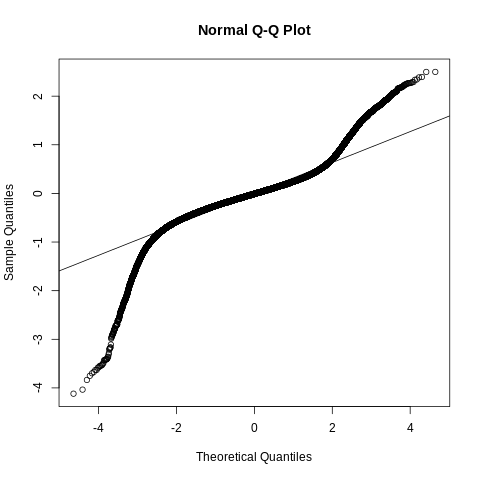

In [ ]:
%%R
qqnorm(residuals(fit.9a))
abline(0,sd(residuals(fit.9a)))

In [ ]:
%%R
confint(fit.9a)

                                2.5 %        97.5 %      Estimate
(Intercept)              3.5186584080  3.6875389679  3.6030986880
fDimCat3                -0.1303737142 -0.1188589158 -0.1246163150
fDimCat4                -0.1352391842 -0.1230949818 -0.1291670830
fDimCat5                -0.1587942190 -0.1438854902 -0.1513398546
fDimCat6                -0.1568767254 -0.1370204723 -0.1469485988
fLactationNumberCat2     0.0994586261  0.1298139819  0.1146363040
fLactationNumberCat3     0.2267896659  0.2848409977  0.2558153318
fLactationNumberCat4     0.3001575176  0.3854208127  0.3427891651
fLactationNumberCat5     0.3917740859  0.5048434342  0.4483087600
fLactationNumberCat6     0.4437692147  0.5853418573  0.5145555360
fLactationNumberCat7     0.5149371773  0.6836355304  0.5992863539
fLactationNumberCat8     0.5195503653  0.7161696673  0.6178600163
fTempMean1daybeforeCat1 -0.0329685196 -0.0188755072 -0.0259220134
fTempMean1daybeforeCat2 -0.0253680113 -0.0087239561 -0.0170459837
fTempMean1

In [ ]:
%%R
rm(fit.9a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2396518  128.0    6362260  339.8   6362260  339.8
Vcells 188848737 1440.9  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.9b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model9b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMean1daybeforeCMS.R'
save(fit.9b, file= url_model9b)
summary(fit.9b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 492156.2  492612.3 -246038.1  492076.2    661420 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.449e-01 0.5873074       
              Day         5.170e-07 0.0007191 -0.75 
 Residual                 1.208e-01 0.3476028       
Number of obs: 661460, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              3.706296   0.030956  119.73  < 2e-16 ***
fDimCat3                -0.055593   0.002021  -27.51  < 2e-16 ***
fDimCat4                -0.079850   0.002025  -39.43  < 2e-16 ***
fDimCat5                -0.090538   0.002294  -3

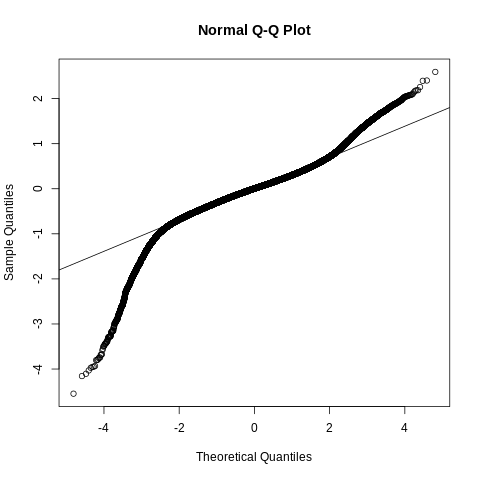

In [ ]:
%%R
qqnorm(residuals(fit.9b))
abline(0,sd(residuals(fit.9b)))

In [ ]:
%%R
confint(fit.9b)

                                2.5 %        97.5 %      Estimate
(Intercept)              3.6456232576  3.7669681370  3.7062956973
fDimCat3                -0.0595533257 -0.0516320919 -0.0555927088
fDimCat4                -0.0838197168 -0.0758809828 -0.0798503498
fDimCat5                -0.0950334811 -0.0860427723 -0.0905381267
fDimCat6                -0.1228190489 -0.1117188994 -0.1172689742
fLactationNumberCat2    -0.0318990519 -0.0159297481 -0.0239144000
fLactationNumberCat3    -0.0249998404  0.0042669827 -0.0103664288
fLactationNumberCat4    -0.0521840066 -0.0093925249 -0.0307882657
fLactationNumberCat5    -0.0827485701 -0.0259387777 -0.0543436739
fLactationNumberCat6    -0.1161895427 -0.0434423893 -0.0798159660
fLactationNumberCat7    -0.2495913953 -0.1590932788 -0.2043423370
fLactationNumberCat8    -0.3146119687 -0.2032883025 -0.2589501356
fTempMean1daybeforeCat1 -0.0317660788 -0.0223604347 -0.0270632568
fTempMean1daybeforeCat2 -0.0277353461 -0.0165489711 -0.0221421586
fTempMean1

In [ ]:
%%R
rm(fit.9b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763841  147.7    6362260  339.8   6362260  339.8
Vcells 207447133 1582.7  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.9c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model9c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMean1daybeforeDRY.R'
save(fit.9c, file= url_model9c)
summary(fit.9c)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102094.5 102454.5 -51008.3 102016.5    75290 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.648e-01 0.5145501       
              Day         5.018e-07 0.0007083 -0.76 
 Residual                 2.028e-01 0.4503146       
Number of obs: 75329, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              3.627180   0.031771  114.17  < 2e-16 ***
fLactationNumberCat2    -0.181358   0.011163  -16.25  < 2e-16 ***
fLactationNumberCat3    -0.301399   0.014954  -20.16  < 2e-16 ***
fLactationNumberCat4    -0.380697   0.018028  -21.12  < 2e-16 ***
fLac

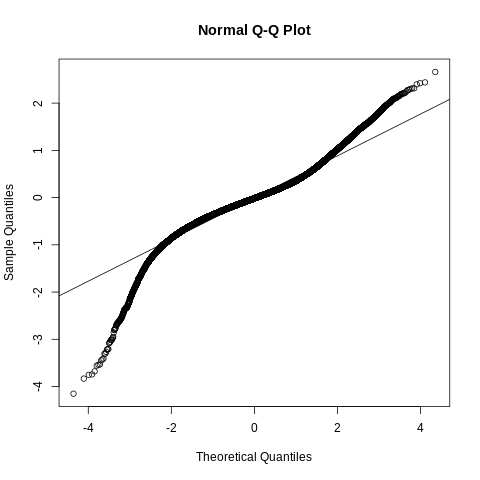

In [ ]:
%%R
qqnorm(residuals(fit.9c))
abline(0,sd(residuals(fit.9c)))

In [ ]:
%%R
confint(fit.9c)

                                2.5 %        97.5 %      Estimate
(Intercept)              3.5649094507  3.6894501557  3.6271798032
fLactationNumberCat2    -0.2032382612 -0.1594785500 -0.1813584056
fLactationNumberCat3    -0.3307082028 -0.2720905967 -0.3013993997
fLactationNumberCat4    -0.4160315021 -0.3453633701 -0.3806974361
fLactationNumberCat5    -0.5201339553 -0.4368097726 -0.4784718640
fLactationNumberCat6    -0.6176994812 -0.5166515398 -0.5671755105
fLactationNumberCat7    -0.6416693826 -0.5089461508 -0.5753077667
fLactationNumberCat8    -0.8686444065 -0.6856677289 -0.7771560677
fTempMean1daybeforeCat1 -0.0276384859  0.0131619279 -0.0072382790
fTempMean1daybeforeCat2  0.0355212607  0.0836290113  0.0595751360
fTempMean1daybeforeCat3  0.0385455428  0.0894786213  0.0640120821
fTempMean1daybeforeCat4 -0.0025553316  0.0532059038  0.0253252861
fTempMean1daybeforeCat5 -0.0615709946  0.0120076740 -0.0247816603
fTempMean1daybeforeCat6 -0.3406261867 -0.2162116732 -0.2784189300
fYear2018 

In [ ]:
%%R
rm(fit.9c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2178012  116.4    6362260  339.8   6362260  339.8
Vcells 178976784 1365.5  443929596 3387.0 443929596 3387.0


## Model Temp mean 2 days before

In [ ]:
%%R
##AMS
fit.10a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model10a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMean2daysbeforeAMS.R'
save(fit.10a, file= url_model10a)
summary(fit.10a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167665.9 168068.4 -83795.0 167589.9   293816 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 5.277e-01 0.7264466       
              Day         6.317e-07 0.0007948 -0.63 
 Residual                 1.013e-01 0.3183457       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               3.575843   0.042990   83.18  < 2e-16 ***
fDimCat3                 -0.124594   0.002937  -42.43  < 2e-16 ***
fDimCat4                 -0.129168   0.003097  -41.70  < 2e-16 ***
fDimCat5                 -0.151310   0.003802  -39.79 

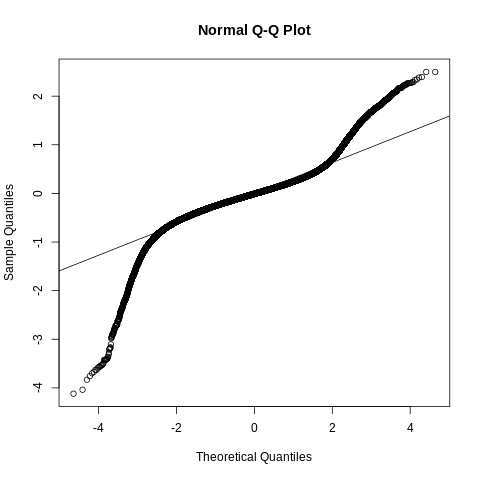

In [ ]:
%%R
qqnorm(residuals(fit.10a))
abline(0,sd(residuals(fit.10a)))

In [ ]:
%%R
confint(fit.10a)

                                 2.5 %        97.5 %     Estimate
(Intercept)               3.4915828030  3.6601022301  3.575842517
fDimCat3                 -0.1303491943 -0.1188379535 -0.124593574
fDimCat4                 -0.1352384082 -0.1230975036 -0.129167956
fDimCat5                 -0.1587625512 -0.1438570888 -0.151309820
fDimCat6                 -0.1567437304 -0.1368912829 -0.146817507
fLactationNumberCat2      0.0993953045  0.1297441256  0.114569715
fLactationNumberCat3      0.2267845196  0.2848245281  0.255804524
fLactationNumberCat4      0.3003355289  0.3855842095  0.342959869
fLactationNumberCat5      0.3922868319  0.5053390390  0.448812935
fLactationNumberCat6      0.4445979169  0.5861512958  0.515374606
fLactationNumberCat7      0.5163379102  0.6850135714  0.600675741
fLactationNumberCat8      0.5212612213  0.7178540742  0.619557648
fTempMean2daysbeforeCat0  0.0162271798  0.0303212276  0.023274204
fTempMean2daysbeforeCat2  0.0077665374  0.0166695012  0.012218019
fTempMean2

In [ ]:
%%R
rm(fit.10a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2396708  128.0    6362260  339.8   6362260  339.8
Vcells 188850664 1440.9  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.10b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model10b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMean2daysbeforeCMS.R'
save(fit.10b, file= url_model10b)
summary(fit.10b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 491769.0  492225.1 -245844.5  491689.0    661326 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.461e-01 0.5882964       
              Day         5.176e-07 0.0007195 -0.75 
 Residual                 1.208e-01 0.3475194       
Number of obs: 661366, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               3.682535   0.030898  119.18  < 2e-16 ***
fDimCat3                 -0.055546   0.002020  -27.49  < 2e-16 ***
fDimCat4                 -0.079733   0.002025  -39.37  < 2e-16 ***
fDimCat5                 -0.090424   0.0022

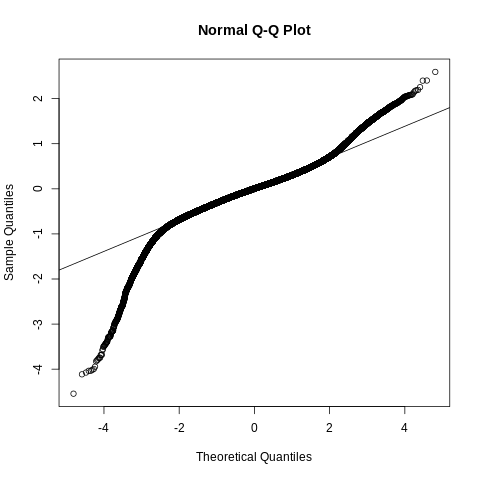

In [ ]:
%%R
qqnorm(residuals(fit.10b))
abline(0,sd(residuals(fit.10b)))

In [ ]:
%%R
confint(fit.10b)

                                 2.5 %        97.5 %      Estimate
(Intercept)               3.6219764097  3.7430932673  3.6825348385
fDimCat3                 -0.0595055517 -0.0515857042 -0.0555456280
fDimCat4                 -0.0837014183 -0.0757636489 -0.0797325336
fDimCat5                 -0.0949191004 -0.0859285306 -0.0904238155
fDimCat6                 -0.1226389765 -0.1115378967 -0.1170884366
fLactationNumberCat2     -0.0316712958 -0.0156985317 -0.0236849138
fLactationNumberCat3     -0.0244423555  0.0048310078 -0.0098056738
fLactationNumberCat4     -0.0513581113 -0.0085572873 -0.0299576993
fLactationNumberCat5     -0.0816033936 -0.0247822724 -0.0531928330
fLactationNumberCat6     -0.1147949075 -0.0420363441 -0.0784156258
fLactationNumberCat7     -0.2479233518 -0.1574159637 -0.2026696577
fLactationNumberCat8     -0.3127249993 -0.2013968393 -0.2570609193
fTempMean2daysbeforeCat0  0.0233537507  0.0327183750  0.0280360628
fTempMean2daysbeforeCat2  0.0085025244  0.0145906357  0.011546

In [ ]:
%%R
rm(fit.10b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2764069  147.7    6362260  339.8   6362260  339.8
Vcells 207444359 1582.7  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.10c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model10c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMean2daysbeforeDRY.R'
save(fit.10c, file= url_model10c)
summary(fit.10c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102129.3 102489.3 -51025.7 102051.3    75279 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.652e-01 0.5149513       
              Day         5.024e-07 0.0007088 -0.76 
 Residual                 2.029e-01 0.4504632       
Number of obs: 75318, groups:  AnimalEartag, 1874

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               3.623780   0.030874  117.37  < 2e-16 ***
fLactationNumberCat2     -0.181876   0.011169  -16.28  < 2e-16 ***
fLactationNumberCat3     -0.302020   0.014962  -20.19  < 2e-16 ***
fLactationNumberCat4     -0.380794   0.018037  -21.11  < 2e-16 *

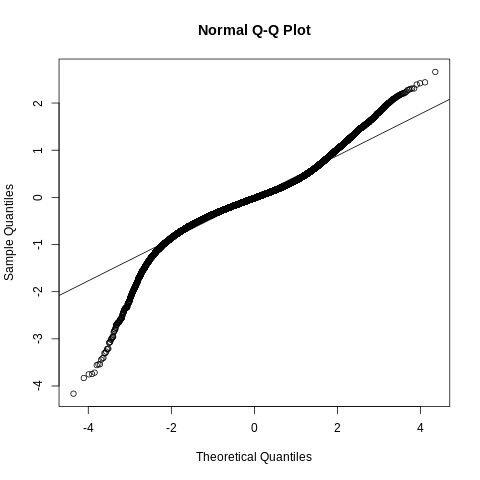

In [ ]:
%%R
qqnorm(residuals(fit.10c))
abline(0,sd(residuals(fit.10c)))

In [ ]:
%%R
confint(fit.10c)

                                2.5 %        97.5 %      Estimate
(Intercept)               3.563267489  3.6842929226  3.6237802057
fLactationNumberCat2     -0.203766598 -0.1599860476 -0.1818763229
fLactationNumberCat3     -0.331345537 -0.2726947534 -0.3020201451
fLactationNumberCat4     -0.416145535 -0.3454423423 -0.3807939384
fLactationNumberCat5     -0.519915893 -0.4365573596 -0.4782366263
fLactationNumberCat6     -0.616957707 -0.5158732030 -0.5664154548
fLactationNumberCat7     -0.641480515 -0.5087137153 -0.5750971150
fLactationNumberCat8     -0.870053412 -0.6870156665 -0.7785345391
fTempMean2daysbeforeCat0 -0.029460232  0.0112820785 -0.0090890769
fTempMean2daysbeforeCat2  0.041891445  0.0675713136  0.0547313794
fTempMean2daysbeforeCat3  0.038602239  0.0693410880  0.0539716637
fTempMean2daysbeforeCat4 -0.009391173  0.0288793991  0.0097441130
fTempMean2daysbeforeCat5 -0.048309906  0.0134053131 -0.0174522966
fTempMean2daysbeforeCat6 -0.339662875 -0.2197053122 -0.2796840939
fYear2018 

In [ ]:
%%R
rm(fit.10c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2178171  116.4    6362260  339.8   6362260  339.8
Vcells 178977900 1365.5  443929596 3387.0 443929596 3387.0


## Model THI mean primi

In [ ]:
%%R
##AMS primi
fit.11a <- glmmTMB(SensorValue ~ fDimCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS_primi, REML=FALSE)
url_model11a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMeanAMS_primi.R'
save(fit.11a, file= url_model11a)
summary(fit.11a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +  
    (1 + Day | AnimalEartag)
Data: dataset_AMS_primi

     AIC      BIC   logLik deviance df.resid 
 13293.3  13569.9  -6615.7  13231.3    55335 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.904e-01 0.83092        
              Day         2.162e-06 0.00147  -0.83 
 Residual                 7.101e-02 0.26648        
Number of obs: 55366, groups:  AnimalEartag, 274

Dispersion estimate for gaussian family (sigma^2): 0.071 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          4.108979   0.057936   70.92  < 2e-16 ***
fDimCat3            -0.198144   0.008096  -24.47  < 2e-16 ***
fDimCat4            -0.279908   0.008617  -32.48  < 2e-16 ***
fDimCat5            -0.280176   0.010353  -27.06  < 2e-16 ***
fDimCat6            -0.279769   0.013004  -21

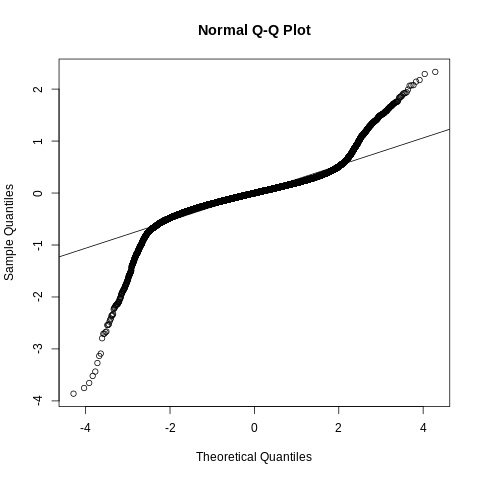

In [ ]:
%%R
qqnorm(residuals(fit.11a))
abline(0,sd(residuals(fit.11a)))

In [ ]:
%%R
confint(fit.11a)

                            2.5 %       97.5 %     Estimate
(Intercept)          3.9954271651  4.222531777  4.108979471
fDimCat3            -0.2140116974 -0.182276340 -0.198144019
fDimCat4            -0.2967972943 -0.263018517 -0.279907906
fDimCat5            -0.3004678579 -0.259885016 -0.280176437
fDimCat6            -0.3052562837 -0.254281948 -0.279769116
fThiMeanCat0        -0.0082791737  0.043922605  0.017821715
fThiMeanCat2        -0.0010625734  0.017749263  0.008343345
fThiMeanCat3         0.0001777826  0.021819092  0.010998437
fThiMeanCat4         0.0179063975  0.043243277  0.030574837
fThiMeanCat5        -0.0020379103  0.033584405  0.015773247
fThiMeanCat6         0.0316117535  0.092481106  0.062046430
fYear2018           -0.2374430016 -0.120842069 -0.179142535
fYear2019           -0.4927132638 -0.262505227 -0.377609245
fYear2020           -0.7050010263 -0.357234020 -0.531117523
fMonth2             -0.0279693478 -0.006314667 -0.017142007
fMonth3             -0.0631649191 -0.036

In [ ]:
%%R
rm(fit.11a)
gc()

           used  (Mb) gc trigger   (Mb)  max used  (Mb)
Ncells  2158134 115.3    3870851  206.8   3870851 206.8
Vcells 96107362 733.3  151063366 1152.6 125819472 960.0


In [ ]:
%%R
##CMS_primi 
fit.11b <- glmmTMB(SensorValue ~ fDimCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS_primi, REML=FALSE)
url_model11b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMeanCMS_primi.R'
save(fit.11b, file= url_model11b)
summary(fit.11b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +  
    (1 + Day | AnimalEartag)
Data: dataset_CMS_primi

     AIC      BIC   logLik deviance df.resid 
100590.6 100924.0 -50262.3 100524.6   180445 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.316e+00 1.147066       
              Day         2.127e-06 0.001458 -0.81 
 Residual                 9.794e-02 0.312949       
Number of obs: 180478, groups:  AnimalEartag, 764

Dispersion estimate for gaussian family (sigma^2): 0.0979 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          3.905538   0.078144   49.98  < 2e-16 ***
fDimCat3            -0.076182   0.003699  -20.60  < 2e-16 ***
fDimCat4            -0.118147   0.004159  -28.41  < 2e-16 ***
fDimCat5            -0.118454   0.005517  -21.47  < 2e-16 ***
fDimCat6            -0.090836   0.007591  -

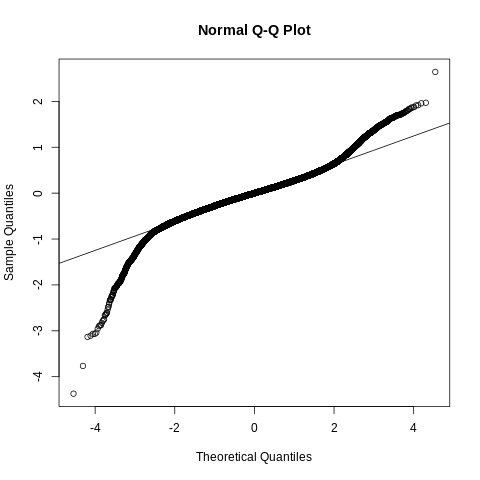

In [ ]:
%%R
qqnorm(residuals(fit.11b))
abline(0,sd(residuals(fit.11b)))

In [ ]:
%%R
confint(fit.11b)

                           2.5 %       97.5 %    Estimate
(Intercept)          3.752379577  4.058696806  3.90553819
fDimCat3            -0.083430706 -0.068932623 -0.07618166
fDimCat4            -0.126298265 -0.109996197 -0.11814723
fDimCat5            -0.129266590 -0.107641112 -0.11845385
fDimCat6            -0.105714064 -0.075957041 -0.09083555
fThiMeanCat0         0.016554980  0.042719767  0.02963737
fThiMeanCat2         0.015150281  0.026327042  0.02073866
fThiMeanCat3         0.013716481  0.026817805  0.02026714
fThiMeanCat4        -0.021053101 -0.006495541 -0.01377432
fThiMeanCat5        -0.068318278 -0.048515099 -0.05841669
fThiMeanCat6        -0.148244865 -0.118483861 -0.13336436
fYear2018           -0.213433961 -0.138765385 -0.17609967
fYear2019           -0.443466960 -0.298823922 -0.37114544
fYear2020           -0.624101679 -0.409215577 -0.51665863
fMonth2             -0.039561513 -0.023713237 -0.03163737
fMonth3             -0.052235488 -0.032937641 -0.04258656
fMonth4       

In [ ]:
%%R
rm(fit.11b)
gc()

            used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2283562 122.0    3870851  206.8   3870851  206.8
Vcells 101767021 776.5  181356039 1383.7 161440147 1231.7


In [ ]:
%%R
##DRY_primi 
fit.11c <- glmmTMB(SensorValue ~ fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry_primi, REML=FALSE)
url_model11c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMeanDRY_primi.R'
save(fit.11c, file= url_model11c)
summary(fit.11c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fThiMeanCat + fYear + fMonth + fHerdIdentifier +  
    (1 + Day | AnimalEartag)
Data: dataset_dry_primi

     AIC      BIC   logLik deviance df.resid 
 17409.0  17643.4  -8672.5  17345.0    11194 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.172e-01 0.5631818       
              Day         4.691e-07 0.0006849 -0.85 
 Residual                 2.392e-01 0.4891143       
Number of obs: 11226, groups:  AnimalEartag, 703

Dispersion estimate for gaussian family (sigma^2): 0.239 

Conditional model:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)          3.66111    0.06598   55.49  < 2e-16 ***
fThiMeanCat0         0.12361    0.03884    3.18 0.001462 ** 
fThiMeanCat2         0.07526    0.01868    4.03 5.60e-05 ***
fThiMeanCat3         0.08359    0.02209    3.78 0.000155 ***
fThiMeanCat4         0.06140    0.02505    2.45 0.014231

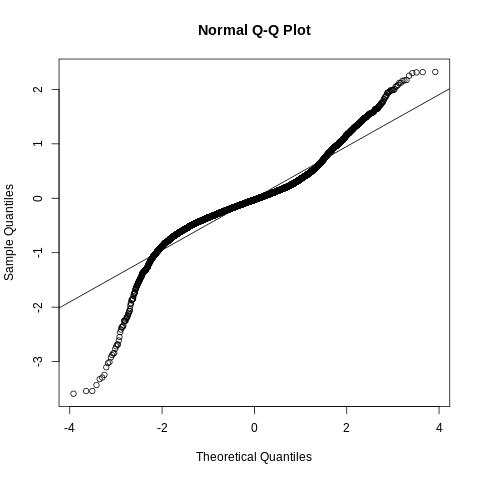

In [ ]:
%%R
qqnorm(residuals(fit.11c))
abline(0,sd(residuals(fit.11c)))

In [ ]:
%%R
confint(fit.11c)

                            2.5 %        97.5 %      Estimate
(Intercept)          3.5318009764  3.7904257479  3.6611133621
fThiMeanCat0         0.0474755508  0.1997389012  0.1236072260
fThiMeanCat2         0.0386510038  0.1118692340  0.0752601189
fThiMeanCat3         0.0402838932  0.1268904450  0.0835871691
fThiMeanCat4         0.0123089669  0.1104955279  0.0614022474
fThiMeanCat5         0.0194527460  0.1699331382  0.0946929421
fThiMeanCat6        -0.0219197477  0.2048272867  0.0914537695
fYear2018           -0.2101601719 -0.0474667926 -0.1288134823
fYear2019           -0.1749068218  0.0021672452 -0.0863697883
fYear2020           -0.1571118277  0.0710862773 -0.0430127752
fMonth2             -0.0078029028  0.1321448997  0.0621709985
fMonth3              0.0501667634  0.2166614328  0.1334140981
fMonth4              0.0375577789  0.2158236250  0.1266907019
fMonth5              0.2437385677  0.4235512799  0.3336449238
fMonth6              0.3451134768  0.5385282678  0.4418208723
fMonth7 

In [ ]:
%%R
rm(fit.11c)
gc()

           used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells  2114462 113.0    3870851  206.8   3870851  206.8
Vcells 94814906 723.4  181356039 1383.7 161440147 1231.7


## Model THI mean multi

In [ ]:
%%R
##AMS_multiparous
fit.12a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS_multi, REML=FALSE)
url_model12a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMeanAMS_multi.R'
save(fit.12a, file= url_model12a)
summary(fit.12a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS_multi

     AIC      BIC   logLik deviance df.resid 
144871.5 145255.7 -72398.8 144797.5   238451 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 6.988e-01 0.8359367       
              Day         6.236e-07 0.0007897 -0.73 
 Residual                 1.050e-01 0.3240247       
Number of obs: 238488, groups:  AnimalEartag, 510

Dispersion estimate for gaussian family (sigma^2): 0.105 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.6626997  0.0492603   74.35  < 2e-16 ***
fDimCat3             -0.1215641  0.0031585  -38.49  < 2e-16 ***
fDimCat4             -0.1178696  0.0033708  -34.97  < 2e-16 ***
fDimCat5             -0.1467616  0.0041662  -35.23  < 2e-16 ***
fDimCat6

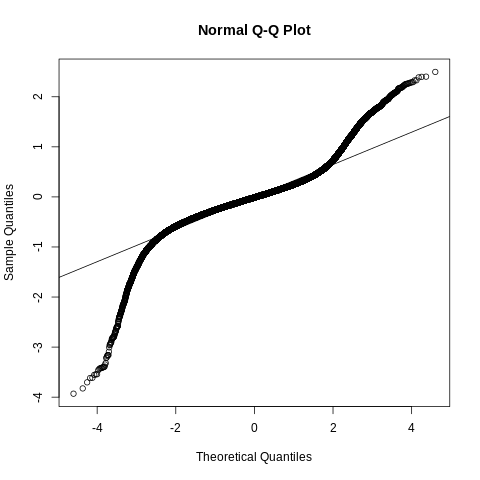

In [ ]:
%%R
qqnorm(residuals(fit.12a))
abline(0,sd(residuals(fit.12a)))

In [ ]:
%%R
confint(fit.12a)

                             2.5 %       97.5 %      Estimate
(Intercept)           3.5661513467  3.759248041  3.6626996939
fDimCat3             -0.1277545223 -0.115373626 -0.1215640740
fDimCat4             -0.1244763478 -0.111262872 -0.1178696096
fDimCat5             -0.1549271869 -0.138596077 -0.1467616318
fDimCat6             -0.1556930116 -0.133921340 -0.1448071757
fLactationNumberCat3  0.0983786065  0.131722890  0.1150507484
fLactationNumberCat4  0.1615775512  0.225456434  0.1935169926
fLactationNumberCat5  0.2471297251  0.341783685  0.2944567053
fLactationNumberCat6  0.3019698626  0.427851883  0.3649108730
fLactationNumberCat7  0.3738200882  0.529372856  0.4515964722
fLactationNumberCat8  0.3872329651  0.573047072  0.4801400187
fThiMeanCat0          0.0140534373  0.050486073  0.0322697550
fThiMeanCat2          0.0128045626  0.023086828  0.0179456954
fThiMeanCat3          0.0156750241  0.027338067  0.0215065455
fThiMeanCat4         -0.0094757245  0.004167098 -0.0026543130
fThiMean

In [ ]:
%%R
rm(fit.12a)
gc()

            used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2341461 125.1    5080777  271.4   4771164  254.9
Vcells 105085768 801.8  181356039 1383.7 170673724 1302.2


In [ ]:
%%R
##CMS 
fit.12b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS_multi, REML=FALSE)
url_model12b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMeanCMS_multi.R'
save(fit.12b, file= url_model12b)
summary(fit.12b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS_multi

      AIC       BIC    logLik  deviance  df.resid 
 371970.2  372402.5 -185946.1  371892.2    481037 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.660e-01 0.6049787       
              Day         5.903e-07 0.0007683 -0.73 
 Residual                 1.242e-01 0.3524702       
Number of obs: 481076, groups:  AnimalEartag, 1003

Dispersion estimate for gaussian family (sigma^2): 0.124 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.494139   0.037944   92.09  < 2e-16 ***
fDimCat3             -0.039882   0.002385  -16.73  < 2e-16 ***
fDimCat4             -0.043404   0.002444  -17.76  < 2e-16 ***
fDimCat5             -0.038467   0.002879  -13.36  < 2e-16 ***
fD

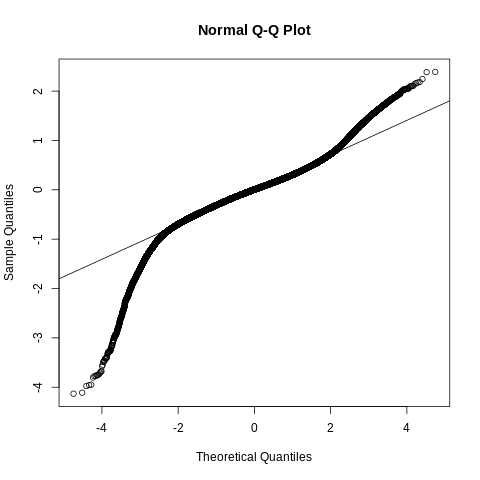

In [ ]:
%%R
qqnorm(residuals(fit.12b))
abline(0,sd(residuals(fit.12b)))

In [ ]:
%%R
confint(fit.12b)

                             2.5 %        97.5 %     Estimate
(Intercept)           3.4197706952  3.5685073566  3.494139026
fDimCat3             -0.0445556688 -0.0352085222 -0.039882096
fDimCat4             -0.0481948757 -0.0386133182 -0.043404097
fDimCat5             -0.0441093020 -0.0328254106 -0.038467356
fDimCat6             -0.0694576033 -0.0549789212 -0.062218262
fLactationNumberCat3  0.0565413623  0.0776394286  0.067090395
fLactationNumberCat4  0.0834163355  0.1238279045  0.103622120
fLactationNumberCat5  0.1154896582  0.1754783737  0.145484016
fLactationNumberCat6  0.1485020738  0.2295396956  0.189020885
fLactationNumberCat7  0.0772231039  0.1801872470  0.128705175
fLactationNumberCat8  0.0723492097  0.1992411667  0.135795188
fThiMeanCat0          0.0152885741  0.0336809460  0.024484760
fThiMeanCat2          0.0108369765  0.0184800211  0.014658499
fThiMeanCat3          0.0092922017  0.0183599734  0.013826088
fThiMeanCat4         -0.0405468960 -0.0304101185 -0.035478507
fThiMean

In [ ]:
%%R
rm(fit.12b)
gc()

            used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2584213 138.1    5080777  271.4   4803047  256.6
Vcells 117515029 896.6  217707246 1661.0 217706410 1661.0


In [ ]:
%%R
##DRY 
fit.12c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry_multi, REML=FALSE)
url_model12c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMeanDRY_multi.R'
save(fit.12c, file= url_model12c)
summary(fit.12c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry_multi

     AIC      BIC   logLik deviance df.resid 
 83738.0  84082.6 -41831.0  83662.0    64075 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.604e-01 0.5103179       
              Day         4.726e-07 0.0006874 -0.74 
 Residual                 1.929e-01 0.4391667       
Number of obs: 64113, groups:  AnimalEartag, 1573

Dispersion estimate for gaussian family (sigma^2): 0.193 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.444102   0.034381  100.17  < 2e-16 ***
fLactationNumberCat3 -0.138665   0.010178  -13.62  < 2e-16 ***
fLactationNumberCat4 -0.238874   0.015574  -15.34  < 2e-16 ***
fLactationNumberCat5 -0.353940   0.020326  -17.41  < 2e-16 ***
fLactationNumberCat6 -0

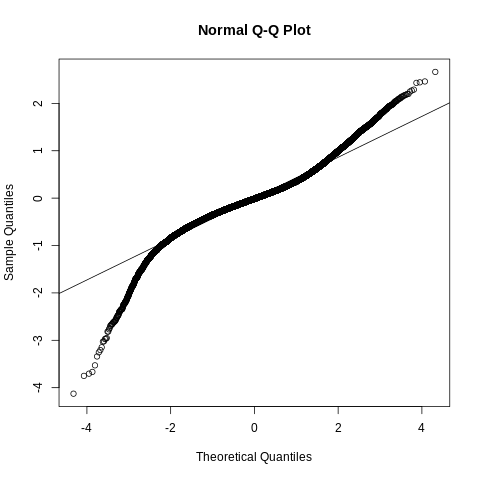

In [ ]:
%%R
qqnorm(residuals(fit.12c))
abline(0,sd(residuals(fit.12c)))

In [ ]:
%%R
confint(fit.12c)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.3767161457  3.5114879900  3.4441020678
fLactationNumberCat3 -0.1586137932 -0.1187162744 -0.1386650338
fLactationNumberCat4 -0.2693975422 -0.2083502404 -0.2388738913
fLactationNumberCat5 -0.3937770891 -0.3141023359 -0.3539397125
fLactationNumberCat6 -0.4935377634 -0.3935112994 -0.4435245314
fLactationNumberCat7 -0.5170298729 -0.3842501402 -0.4506400065
fLactationNumberCat8 -0.7356121435 -0.5522656802 -0.6439389119
fThiMeanCat0          0.0027199861  0.0741103656  0.0384151758
fThiMeanCat2          0.0445399587  0.0721690042  0.0583544815
fThiMeanCat3          0.0550418955  0.0867333923  0.0708876439
fThiMeanCat4          0.0326521526  0.0678336934  0.0502429230
fThiMeanCat5          0.0192623599  0.0672770655  0.0432697127
fThiMeanCat6         -0.0956739152 -0.0250043180 -0.0603391166
fYear2018            -0.0677017230 -0.0260115405 -0.0468566318
fYear2019            -0.0665778345  0.0023867788 -0.032

In [ ]:
%%R
rm(fit.12c)
gc()

           used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells  2167253 115.8    5080777  271.4   4803047  256.6
Vcells 97884627 746.9  217707246 1661.0 217706410 1661.0


## Model Temperature mean primi

In [ ]:
%%R
##AMS primi
fit.13a <- glmmTMB(SensorValue ~ fDimCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS_primi, REML=FALSE)
url_model13a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMeanAMS_primi.R'
save(fit.13a, file= url_model13a)
summary(fit.13a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +  
    (1 + Day | AnimalEartag)
Data: dataset_AMS_primi

     AIC      BIC   logLik deviance df.resid 
 13260.1  13536.7  -6599.0  13198.1    55335 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.923e-01 0.832034       
              Day         2.170e-06 0.001473 -0.83 
 Residual                 7.097e-02 0.266397       
Number of obs: 55366, groups:  AnimalEartag, 274

Dispersion estimate for gaussian family (sigma^2): 0.071 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          4.099982   0.057882   70.83  < 2e-16 ***
fDimCat3            -0.198454   0.008095  -24.52  < 2e-16 ***
fDimCat4            -0.279889   0.008616  -32.49  < 2e-16 ***
fDimCat5            -0.280425   0.010351  -27.09  < 2e-16 ***
fDimCat6            -0.280450   0.013001  -2

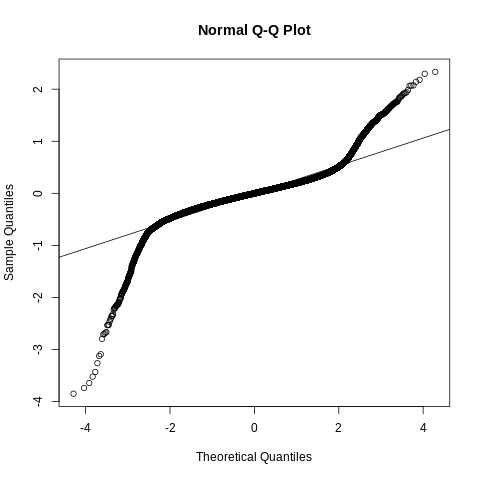

In [ ]:
%%R
qqnorm(residuals(fit.13a))
abline(0,sd(residuals(fit.13a)))

In [ ]:
%%R
confint(fit.13a)

                           2.5 %       97.5 %     Estimate
(Intercept)          3.986536128  4.213428283  4.099982205
fDimCat3            -0.214318915 -0.182588510 -0.198453712
fDimCat4            -0.296775782 -0.263003081 -0.279889432
fDimCat5            -0.300713600 -0.260137161 -0.280425381
fDimCat6            -0.305930893 -0.254968152 -0.280449523
fTempMeanCat0        0.014439279  0.038694760  0.026567020
fTempMeanCat2       -0.015657570  0.002259090 -0.006699240
fTempMeanCat3        0.004260120  0.025870519  0.015065320
fTempMeanCat4        0.020936986  0.049267683  0.035102335
fTempMeanCat5        0.016082791  0.070310443  0.043196617
fTempMeanCat6       -0.014791315  0.102370390  0.043789538
fYear2018           -0.231145178 -0.114527334 -0.172836256
fYear2019           -0.479370645 -0.249103319 -0.364236982
fYear2020           -0.681181787 -0.333292674 -0.507237230
fMonth2             -0.027267599 -0.005736913 -0.016502256
fMonth3             -0.060154254 -0.033180031 -0.0466671

In [ ]:
%%R
rm(fit.13a)
gc()

           used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells  2158823 115.3    5080777  271.4   4803047  256.6
Vcells 97030280 740.3  217707246 1661.0 217706410 1661.0


In [ ]:
%%R
##CMS_primi 
fit.13b <- glmmTMB(SensorValue ~ fDimCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS_primi, REML=FALSE)
url_model13b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMeanCMS_primi.R'
save(fit.13b, file= url_model13b)
summary(fit.13b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +  
    (1 + Day | AnimalEartag)
Data: dataset_CMS_primi

     AIC      BIC   logLik deviance df.resid 
100012.1 100345.5 -49973.0  99946.1   180445 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.315e+00 1.146555       
              Day         2.110e-06 0.001452 -0.81 
 Residual                 9.762e-02 0.312448       
Number of obs: 180478, groups:  AnimalEartag, 764

Dispersion estimate for gaussian family (sigma^2): 0.0976 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          3.919272   0.078116   50.17  < 2e-16 ***
fDimCat3            -0.075712   0.003693  -20.50  < 2e-16 ***
fDimCat4            -0.117345   0.004154  -28.25  < 2e-16 ***
fDimCat5            -0.117195   0.005511  -21.27  < 2e-16 ***
fDimCat6            -0.089315   0.007584  

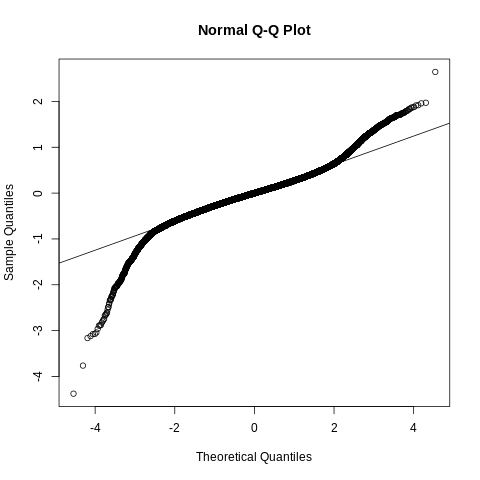

In [ ]:
%%R
qqnorm(residuals(fit.13b))
abline(0,sd(residuals(fit.13b)))

In [ ]:
%%R
confint(fit.13b)

                           2.5 %      97.5 %     Estimate
(Intercept)          3.766168488  4.07237593  3.919272211
fDimCat3            -0.082950272 -0.06847384 -0.075712057
fDimCat4            -0.125485649 -0.10920418 -0.117344914
fDimCat5            -0.127996523 -0.10639351 -0.117195015
fDimCat6            -0.104178358 -0.07445079 -0.089314576
fTempMeanCat0        0.013154722  0.02963614  0.021395432
fTempMeanCat2        0.005375199  0.01594170  0.010658447
fTempMeanCat3        0.008803083  0.02167039  0.015236735
fTempMeanCat4       -0.057398000 -0.04125618 -0.049327091
fTempMeanCat5       -0.177097670 -0.15120255 -0.164150111
fTempMeanCat6       -0.215154437 -0.16307529 -0.189114865
fYear2018           -0.225421396 -0.15109552 -0.188258456
fYear2019           -0.464612349 -0.32061886 -0.392615605
fYear2020           -0.653934519 -0.44002279 -0.546978657
fMonth2             -0.041118007 -0.02541557 -0.033266790
fMonth3             -0.053212519 -0.03397796 -0.043595239
fMonth4       

In [ ]:
%%R
rm(fit.13b)
gc()

            used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2283502 122.0    5080777  271.4   4803047  256.6
Vcells 102290644 780.5  217707246 1661.0 217706410 1661.0


In [ ]:
%%R
##DRY_primi 
fit.13c <- glmmTMB(SensorValue ~ fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry_primi, REML=FALSE)
url_model13c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMeanDRY_primi.R'
save(fit.13c, file= url_model13c)
summary(fit.13c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fTempMeanCat + fYear + fMonth + fHerdIdentifier +  
    (1 + Day | AnimalEartag)
Data: dataset_dry_primi

     AIC      BIC   logLik deviance df.resid 
 17402.0  17636.5  -8669.0  17338.0    11194 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.158e-01 0.5619770       
              Day         4.673e-07 0.0006836 -0.85 
 Residual                 2.391e-01 0.4889925       
Number of obs: 11226, groups:  AnimalEartag, 703

Dispersion estimate for gaussian family (sigma^2): 0.239 

Conditional model:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)          3.65603    0.06614   55.28  < 2e-16 ***
fTempMeanCat0        0.06542    0.02543    2.57  0.01009 *  
fTempMeanCat2        0.09118    0.01804    5.05 4.35e-07 ***
fTempMeanCat3        0.10615    0.02194    4.84 1.31e-06 ***
fTempMeanCat4        0.11452    0.02905    3.94 8.06e-0

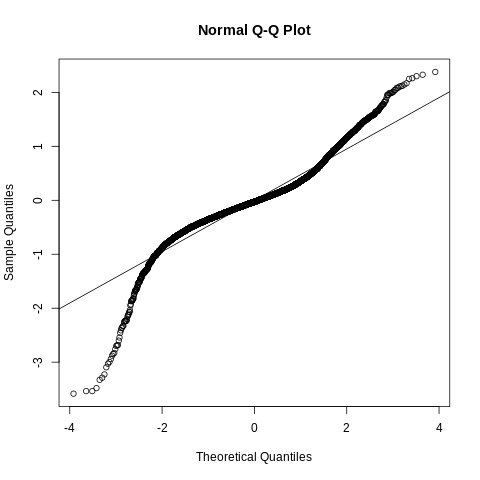

In [ ]:
%%R
qqnorm(residuals(fit.13c))
abline(0,sd(residuals(fit.13c)))

In [ ]:
%%R
confint(fit.13c)

                           2.5 %        97.5 %      Estimate
(Intercept)          3.526392701  3.7856608995  3.6560268001
fTempMeanCat0        0.015580045  0.1152691418  0.0654245932
fTempMeanCat2        0.055815269  0.1265499075  0.0911825885
fTempMeanCat3        0.063147981  0.1491464849  0.1061472328
fTempMeanCat4        0.057585776  0.1714472143  0.1145164952
fTempMeanCat5       -0.009963183  0.1845978179  0.0873173177
fTempMeanCat6       -0.090321863  0.2990245660  0.1043513515
fYear2018           -0.213879755 -0.0513511798 -0.1326154674
fYear2019           -0.175487376  0.0013007916 -0.0870932921
fYear2020           -0.156556645  0.0714720802 -0.0425422826
fMonth2             -0.009453557  0.1304751827  0.0605108128
fMonth3              0.046848617  0.2135457352  0.1301971759
fMonth4              0.015631260  0.1962302110  0.1059307352
fMonth5              0.229550276  0.4107475101  0.3201488930
fMonth6              0.325562113  0.5204022627  0.4229821878
fMonth7              0.2

In [ ]:
%%R
rm(fit.13c)
gc()

           used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells  2114402 113.0    5080777  271.4   4803047  256.6
Vcells 95338507 727.4  217707246 1661.0 217706410 1661.0


## Model Temperature mean multi

In [ ]:
%%R
##AMS_multiparous
fit.14a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS_multi, REML=FALSE)
url_model14a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMeanAMS_multi.R'
save(fit.14a, file= url_model14a)
summary(fit.14a)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS_multi

     AIC      BIC   logLik deviance df.resid 
144888.2 145272.4 -72407.1 144814.2   238451 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 7.005e-01 0.8369734       
              Day         6.261e-07 0.0007912 -0.73 
 Residual                 1.050e-01 0.3240363       
Number of obs: 238488, groups:  AnimalEartag, 510

Dispersion estimate for gaussian family (sigma^2): 0.105 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.653468   0.049212   74.24  < 2e-16 ***
fDimCat3             -0.121793   0.003158  -38.56  < 2e-16 ***
fDimCat4             -0.117892   0.003371  -34.97  < 2e-16 ***
fDimCat5             -0.146674   0.004166  -35.21  < 2e-16 ***
fDimCat6     

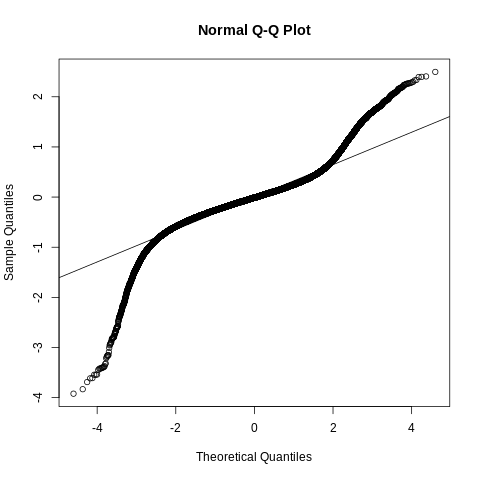

In [ ]:
%%R
qqnorm(residuals(fit.14a))
abline(0,sd(residuals(fit.14a)))

In [ ]:
%%R
confint(fit.14a)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.5570146031  3.7499219684  3.6534682858
fDimCat3             -0.1279832855 -0.1156025079 -0.1217928967
fDimCat4             -0.1244983572 -0.1112847137 -0.1178915354
fDimCat5             -0.1548400059 -0.1385086703 -0.1466743381
fDimCat6             -0.1557868504 -0.1340172321 -0.1449020412
fLactationNumberCat3  0.0987809624  0.1321246932  0.1154528278
fLactationNumberCat4  0.1620514670  0.2259232043  0.1939873357
fLactationNumberCat5  0.2469468661  0.3415845261  0.2942656961
fLactationNumberCat6  0.3010469926  0.4269021028  0.3639745477
fLactationNumberCat7  0.3715796214  0.5270983453  0.4493389834
fLactationNumberCat8  0.3834740284  0.5692508409  0.4763624347
fTempMeanCat0         0.0269619652  0.0434875744  0.0352247698
fTempMeanCat2         0.0023296440  0.0122324199  0.0072810320
fTempMeanCat3         0.0129681600  0.0247819557  0.0188750578
fTempMeanCat4        -0.0145820206  0.0008214461 -0.006

In [ ]:
%%R
rm(fit.14a)
gc()

            used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2341827 125.1    5080777  271.4   4803047  256.6
Vcells 105612998 805.8  217707246 1661.0 217706410 1661.0


In [ ]:
%%R
##CMS 
fit.14b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS_multi, REML=FALSE)
url_model14b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMeanCMS_multi.R'
save(fit.14b, file= url_model14b)
summary(fit.14b)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS_multi

      AIC       BIC    logLik  deviance  df.resid 
 370000.2  370432.5 -184961.1  369922.2    481037 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.679e-01 0.6065594       
              Day         5.903e-07 0.0007683 -0.73 
 Residual                 1.237e-01 0.3517443       
Number of obs: 481076, groups:  AnimalEartag, 1003

Dispersion estimate for gaussian family (sigma^2): 0.124 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.497209   0.038040   91.93  < 2e-16 ***
fDimCat3             -0.040071   0.002380  -16.84  < 2e-16 ***
fDimCat4             -0.043168   0.002441  -17.68  < 2e-16 ***
fDimCat5             -0.038018   0.002878  -13.21  < 2e-16 ***
fD

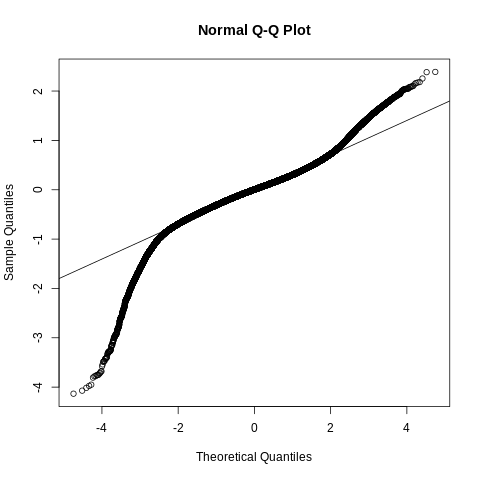

In [ ]:
%%R
qqnorm(residuals(fit.14b))
abline(0,sd(residuals(fit.14b)))

In [ ]:
%%R
confint(fit.14b)

                            2.5 %        97.5 %      Estimate
(Intercept)           3.422651100  3.5717659065  3.4972085034
fDimCat3             -0.044735294 -0.0354062249 -0.0400707595
fDimCat4             -0.047952075 -0.0383833837 -0.0431677295
fDimCat5             -0.043658246 -0.0323783979 -0.0380183221
fDimCat6             -0.068692475 -0.0542065401 -0.0614495074
fLactationNumberCat3  0.058177175  0.0792999379  0.0687385565
fLactationNumberCat4  0.086419555  0.1268840187  0.1066517866
fLactationNumberCat5  0.119772145  0.1798400013  0.1498060734
fLactationNumberCat6  0.154083447  0.2352249427  0.1946541948
fLactationNumberCat7  0.084625178  0.1877079456  0.1361665619
fLactationNumberCat8  0.081417533  0.2084225418  0.1449200374
fTempMeanCat0         0.014365394  0.0255627518  0.0199640729
fTempMeanCat2         0.003131510  0.0103373370  0.0067344237
fTempMeanCat3         0.004755338  0.0136507015  0.0092030199
fTempMeanCat4        -0.090681649 -0.0794544104 -0.0850680298
fTempMea

In [ ]:
%%R
rm(fit.14b)
gc()

            used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2584571 138.1    5080777  271.4   4807843  256.8
Vcells 117517940 896.6  217707246 1661.0 217706410 1661.0


In [ ]:
%%R
##DRY 
fit.14c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry_multi, REML=FALSE)
url_model14c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMeanDRY_multi.R'
save(fit.14c, file= url_model14c)
summary(fit.14c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry_multi

     AIC      BIC   logLik deviance df.resid 
 83591.8  83936.4 -41757.9  83515.8    64075 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.583e-01 0.5082311       
              Day         4.685e-07 0.0006845 -0.74 
 Residual                 1.924e-01 0.4386892       
Number of obs: 64113, groups:  AnimalEartag, 1573

Dispersion estimate for gaussian family (sigma^2): 0.192 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.442258   0.034334  100.26  < 2e-16 ***
fLactationNumberCat3 -0.137979   0.010154  -13.59  < 2e-16 ***
fLactationNumberCat4 -0.239687   0.015538  -15.43  < 2e-16 ***
fLactationNumberCat5 -0.356890   0.020287  -17.59  < 2e-16 ***
fLactationNumberCat6 -

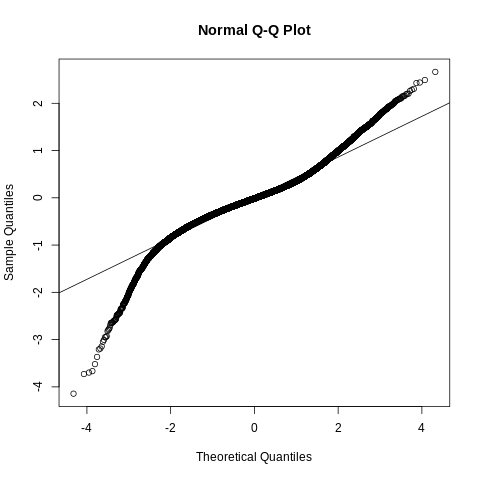

In [ ]:
%%R
qqnorm(residuals(fit.14c))
abline(0,sd(residuals(fit.14c)))

In [ ]:
%%R
confint(fit.14c)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.3749653284  3.5095515772  3.4422584528
fLactationNumberCat3 -0.1578808336 -0.1180778151 -0.1379793243
fLactationNumberCat4 -0.2701416824 -0.2092324606 -0.2396870715
fLactationNumberCat5 -0.3966507146 -0.3171289054 -0.3568898100
fLactationNumberCat6 -0.4957593100 -0.3959072489 -0.4458332795
fLactationNumberCat7 -0.5166804810 -0.3841116236 -0.4503960523
fLactationNumberCat8 -0.7344726012 -0.5514283696 -0.6429504854
fTempMeanCat0        -0.0136141472  0.0313236446  0.0088547487
fTempMeanCat2         0.0744317044  0.1015374283  0.0879845663
fTempMeanCat3         0.0882290526  0.1205092085  0.1043691306
fTempMeanCat4         0.0608568818  0.1009224317  0.0808896568
fTempMeanCat5        -0.0327591967  0.0307194941 -0.0010198513
fTempMeanCat6        -0.1962343534 -0.0766941092 -0.1364642313
fYear2018            -0.0683428097 -0.0267700441 -0.0475564269
fYear2019            -0.0650792239  0.0036814030 -0.030

In [ ]:
%%R
rm(fit.14c)
gc()

           used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells  2167761 115.8    5080777  271.4   4807843  256.8
Vcells 97887626 746.9  217707246 1661.0 217706410 1661.0


# Run models Walking grouped in 6 groups per 5

## Create sub datasets

In [ ]:
## load dataset
%%R 
url5 <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/df_joined_per5_walking.csv'

dataset_per5 <- read.csv(url5, header = TRUE, sep = ",")[ ,c('SensorValue','DimCat','LactationNumber','ThiMeanCat','TempMeanCat','ThiMaxCat','TempMinCat','ThiMinCat',
                                                       'ThiMean1daybeforeCat', 'TempMean1daybeforeCat', 'ThiMean2daysbeforeCat', 'TempMean2daysbeforeCat','CowLac',  
                                                        'TempMaxCat','Year', 'Month', 'HerdIdentifier','Day','AnimalEartag', 'Temp6Hrs16','Thi6Hrs60')]
## Change categorized data to factor and relevel 
dataset<-dataset_per5
dataset$fDimCat <- factor(dataset$DimCat)
dataset$fHerdIdentifier <- factor(dataset$HerdIdentifier)
dataset$fYear <- factor(dataset$Year)
dataset$fMonth <- factor(dataset$Month)
dataset$fThiMeanCat <- factor(dataset$ThiMeanCat)
dataset$fThiMaxCat <- factor(dataset$ThiMaxCat)
dataset$fThiMinCat <- factor(dataset$ThiMinCat)
dataset$fTempMeanCat <- factor(dataset$TempMeanCat)
dataset$fTempMaxCat <- factor(dataset$TempMaxCat)
dataset$fTempMinCat <- factor(dataset$TempMinCat)
dataset$fThiMean1daybeforeCat <- factor(dataset$ThiMean1daybeforeCat)
dataset$fThiMean2daysbeforeCat <- factor(dataset$ThiMean2daysbeforeCat)
dataset$fTempMean2daysbeforeCat <- factor(dataset$TempMean2daysbeforeCat)
dataset$fTempMean1daybeforeCat <- factor(dataset$TempMean1daybeforeCat)
dataset$fTemp6Hrs16 <- factor(dataset$Temp6Hrs16)
dataset$fThi6Hrs60 <- factor(dataset$Thi6Hrs60)
dataset$fLactationNumberCat <- factor(dataset$LactationNumber)
dataset$SensorValue<- log(dataset$SensorValue)
dataset <- within(dataset, fThiMeanCat <- relevel(fThiMeanCat, ref = "1"))
dataset <- within(dataset, fThiMinCat <- relevel(fThiMinCat, ref = "1"))
dataset <- within(dataset, fThiMaxCat <- relevel(fThiMaxCat, ref = "1"))
dataset <- within(dataset, fTempMeanCat <- relevel(fTempMeanCat, ref = "1"))
dataset <- within(dataset, fTempMinCat <- relevel(fTempMinCat, ref = "1"))
dataset <- within(dataset, fTempMaxCat <- relevel(fTempMaxCat, ref = "1"))
dataset <- within(dataset, fThiMean1daybeforeCat <- relevel(fThiMean1daybeforeCat, ref = "1"))
dataset <- within(dataset, fTempMean1day1beforeCat <- relevel(fTempMean1daybeforeCat, ref = "1"))
dataset <- within(dataset, fThiMean2daysbeforeCat <- relevel(fThiMean2daysbeforeCat, ref = "1"))
dataset <- within(dataset, fTempMean2daysbeforeCat <- relevel(fTempMean2daysbeforeCat, ref = "1"))

In [ ]:
%%R
dataset_milk <- filter(dataset, fDimCat==1|fDimCat==2|fDimCat==3|fDimCat==4|fDimCat==5|fDimCat==6)
dataset_dry <- filter(dataset, fDimCat==0)
dataset_AMS <- filter(dataset_milk, HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314)
dataset_CMS <- filter(dataset_milk, HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888)
dataset_dry_AMS <- filter(dataset_dry, HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314)
dataset_dry_CMS <- filter(dataset_dry, HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888)

In [ ]:
%%R
write.csv(dataset_AMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/dataset_per5_walking_AMS.csv', row.names = FALSE)
write.csv(dataset_CMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/dataset_per5_walking_CMS.csv', row.names = FALSE)
write.csv(dataset_dry, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/dataset_per5_walking_DRY.csv', row.names = FALSE)
write.csv(dataset_milk, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/dataset_per5_walking_milk.csv', row.names = FALSE)
write.csv(dataset_dry_AMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/dataset_per5_walking_DRY_AMS.csv', row.names = FALSE)
write.csv(dataset_dry_CMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/dataset_per5_walking_DRY_CMS.csv', row.names = FALSE)


## Descriptives lactating AMS/CMS, dry cow

In [ ]:
%%R
data_count_AMS_cowlac <- dataset_AMS %>%                              # Appwalking group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_AMS_cowlac

  count
1  1316


In [ ]:
%%R
data_count_AMS_cow <- dataset_AMS %>%                              # Appwalking group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_AMS_cow

  count
1   557


In [ ]:
%%R
data_count_CMS_cowlac <- dataset_CMS %>%                              # Appwalking group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_CMS_cowlac

  count
1  2817


In [ ]:
%%R
data_count_dry_CMS <- dataset_CMS %>%                              # Appwalking group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_dry_CMS

  count
1  1286


In [ ]:
%%R
data_count_dry_cowlac <- dataset_dry %>%                              # Appwalking group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_dry_cowlac

  count
1  3599


In [ ]:
%%R
data_count_dry_cow <- dataset_dry %>%                              # Appwalking group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_dry_cow

  count
1  1875


In [ ]:
%%R
table(dataset_AMS$ThiMeanCat)


     0      1      2      3      4      5 
  1713 172556  43942  48357  21783   5503 


In [ ]:
%%R
table(dataset_AMS$ThiMaxCat)


     0      1      2      3      4      5 
   110 123547  40899  42606  49299  37393 


In [ ]:
%%R
table(dataset_AMS$ThiMinCat)


     0      1      2      3      4      5 
 14831 128100  49957  44730  39045  17191 


In [ ]:
%%R
table(dataset_AMS$ThiMean1daybeforeCat)


     0      1      2      3      4      5 
  1719 172507  44034  48256  21858   5480 


In [ ]:
%%R
table(dataset_AMS$ThiMean2daysbeforeCat)


     0      1      2      3      4      5 
  1720 172657  44163  48091  21759   5464 


In [ ]:
%%R
table(dataset_AMS$TempMeanCat)


     0      1      2      3      4      5 
  9036 129382  62819  71837  18127   2653 


In [ ]:
%%R
table(dataset_AMS$TempMaxCat)


    0     1     2     3     4     5 
 2912 84220 67481 59150 53776 26315 


In [ ]:
%%R
table(dataset_AMS$TempMinCat)


    0     1     2     3     4     5 
31071 80733 84119 73604 23245  1082 


In [ ]:
%%R
table(dataset_AMS$TempMean1daybeforeCat)


     0      1      2      3      4      5 
  9031 129442  62839  71786  18112   2644 


In [ ]:
%%R
table(dataset_AMS$TempMean2daysbeforeCat)


     0      1      2      3      4      5 
  8984 129544  63084  71512  18093   2637 


In [ ]:
%%R
table(dataset_CMS$ThiMeanCat)


     0      1      2      3      4      5 
  8766 376706 108213 104966  47813  15090 


In [ ]:
%%R
table(dataset_CMS$ThiMaxCat)


     0      1      2      3      4      5 
  1158 267773  90614  93116 115194  93699 


In [ ]:
%%R
table(dataset_CMS$ThiMinCat)


     0      1      2      3      4      5 
 48295 297054 112022  97812  77148  29223 


In [ ]:
%%R
table(dataset_CMS$ThiMean1daybeforeCat)


     0      1      2      3      4      5 
  8765 376502 108336 104860  47916  15081 


In [ ]:
%%R
table(dataset_CMS$ThiMean2daysbeforeCat)


     0      1      2      3      4      5 
  8766 376510 108254 104851  47904  15081 


In [ ]:
%%R
table(dataset_CMS$TempMeanCat)


     0      1      2      3      4      5 
 25453 281722 146655 153035  46486   8203 


In [ ]:
%%R
table(dataset_CMS$TempMaxCat)


     0      1      2      3      4      5 
  8721 185449 136875 130515 128570  71424 


In [ ]:
%%R
table(dataset_CMS$TempMinCat)


     0      1      2      3      4      5 
 95553 176689 190341 157804  38024   3143 


In [ ]:
%%R
table(dataset_CMS$TempMean1daybeforeCat)


     0      1      2      3      4      5 
 25372 281704 146662 152940  46584   8198 


In [ ]:
%%R
table(dataset_CMS$TempMean2daysbeforeCat)


     0      1      2      3      4      5 
 25464 281535 146657 152843  46661   8206 


In [ ]:
%%R
table(dataset_dry$ThiMeanCat)


    0     1     2     3     4     5 
  919 39619 12596 13991  6359  1855 


In [ ]:
%%R
table(dataset_dry$ThiMaxCat)


    0     1     2     3     4     5 
  106 27713  9875 11470 14349 11826 


In [ ]:
%%R
table(dataset_dry$ThiMinCat)


    0     1     2     3     4     5 
 4815 30562 12751 12149 10801  4261 


In [ ]:
%%R
table(dataset_dry$ThiMean1daybeforeCat)


    0     1     2     3     4     5 
  937 39607 12546 14004  6384  1851 


In [ ]:
%%R
table(dataset_dry$ThiMean2daysbeforeCat)


    0     1     2     3     4     5 
  959 39574 12552 14008  6398  1827 


In [ ]:
%%R
table(dataset_dry$TempMeanCat)


    0     1     2     3     4     5 
 2702 28998 16613 20255  5776   995 


In [ ]:
%%R
table(dataset_dry$TempMaxCat)


    0     1     2     3     4     5 
  967 19118 14677 15859 15986  8732 


In [ ]:
%%R
table(dataset_dry$TempMinCat)


    0     1     2     3     4     5 
 9256 18536 20959 20594  5592   402 


In [ ]:
%%R
table(dataset_dry$TempMean1daybeforeCat)


    0     1     2     3     4     5 
 2717 28950 16646 20219  5805   992 


In [ ]:
%%R
table(dataset_dry$TempMean2daysbeforeCat)


    0     1     2     3     4     5 
 2731 28954 16627 20216  5811   979 


## Model THI mean

In [ ]:
%%R
##AMS
fit.1a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model1a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTHIMeanAMS.R'
save(fit.1a, file= url_model1a)
summary(fit.1a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167958.5 168350.4 -83942.2 167884.5   293817 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 5.222e-01 0.7226477       
              Day         6.292e-07 0.0007932 -0.63 
 Residual                 1.014e-01 0.3185122       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.571312   0.042680   83.68  < 2e-16 ***
fDimCat3             -0.124737   0.002938  -42.46  < 2e-16 ***
fDimCat4             -0.129595   0.003098  -41.83  < 2e-16 ***
fDimCat5             -0.152105   0.003803  -40.00  < 2e-16 ***
fDimCat6           

In [ ]:
%%R
confint(fit.1a)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.4876598992  3.6549633968  3.5713116480
fDimCat3             -0.1304951464 -0.1189782269 -0.1247366866
fDimCat4             -0.1356673644 -0.1235223449 -0.1295948546
fDimCat5             -0.1595582688 -0.1446514874 -0.1521048781
fDimCat6             -0.1580043713 -0.1381531790 -0.1480787752
fLactationNumberCat2  0.0972513125  0.1275953297  0.1124233211
fLactationNumberCat3  0.2227942813  0.2808228396  0.2518085605
fLactationNumberCat4  0.2944781448  0.3797079997  0.3370930722
fLactationNumberCat5  0.3847860960  0.4978113539  0.4412987249
fLactationNumberCat6  0.4357411279  0.5772595572  0.5065003425
fLactationNumberCat7  0.5058208738  0.6744570742  0.5901389740
fLactationNumberCat8  0.5101249366  0.7066751755  0.6084000561
fThiMeanCat0          0.0162050851  0.0472084096  0.0317067473
fThiMeanCat2          0.0137177999  0.0227707141  0.0182442570
fThiMeanCat3          0.0176921363  0.0281736700  0.022

In [ ]:
%%R
rm(fit.1a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2396734  128.0    6362260  339.8   6362260  339.8
Vcells 198348585 1513.3  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.1b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model1b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTHIMeanCMS.R'
save(fit.1b, file= url_model1b)
summary(fit.1b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 493532.0  493976.7 -246727.0  493454.0    661515 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.471e-01 0.5891369       
              Day         5.193e-07 0.0007206 -0.75 
 Residual                 1.211e-01 0.3479440       
Number of obs: 661554, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.677542   0.030940  118.86  < 2e-16 ***
fDimCat3             -0.055696   0.002023  -27.54  < 2e-16 ***
fDimCat4             -0.079966   0.002027  -39.45  < 2e-16 ***
fDimCat5             -0.090518   0.002296  -39.42  < 2e-16 ***
fDimCat6

In [ ]:
%%R
confint(fit.1b)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.6169002131  3.7381846812  3.6775424471
fDimCat3             -0.0596602321 -0.0517316759 -0.0556959540
fDimCat4             -0.0839390063 -0.0759923828 -0.0799656945
fDimCat5             -0.0950183801 -0.0860179878 -0.0905181839
fDimCat6             -0.1226798557 -0.1115676591 -0.1171237574
fLactationNumberCat2 -0.0323308120 -0.0163488543 -0.0243398332
fLactationNumberCat3 -0.0252129004  0.0040814202 -0.0105657401
fLactationNumberCat4 -0.0516981492 -0.0088610337 -0.0302795914
fLactationNumberCat5 -0.0810856361 -0.0242106617 -0.0526481489
fLactationNumberCat6 -0.1128654447 -0.0400330566 -0.0764492507
fLactationNumberCat7 -0.2452047061 -0.1546025351 -0.1999036206
fLactationNumberCat8 -0.3089724934 -0.1975255535 -0.2532490235
fThiMeanCat0          0.0158701701  0.0312205601  0.0235453651
fThiMeanCat2          0.0066686520  0.0128904727  0.0097795623
fThiMeanCat3          0.0064891498  0.0139648396  0.010

In [ ]:
%%R
rm(fit.1b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2764579  147.7    6362260  339.8   6362260  339.8
Vcells 216256231 1650.0  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.1c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model1c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTHIMeanDRY.R'
save(fit.1c, file= url_model1c)
summary(fit.1c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102143.2 102494.0 -51033.6 102067.2    75301 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.646e-01 0.5143599       
              Day         5.016e-07 0.0007082 -0.76 
 Residual                 2.029e-01 0.4504364       
Number of obs: 75339, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.617054   0.030777  117.53  < 2e-16 ***
fLactationNumberCat2 -0.182936   0.011160  -16.39  < 2e-16 ***
fLactationNumberCat3 -0.303562   0.014947  -20.31  < 2e-16 ***
fLactationNumberCat4 -0.381907   0.018021  -21.19  < 2e-16 ***
fLactationNumberCat5 -0.47843

In [ ]:
%%R
confint(fit.1c)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.5567332308  3.6773749226  3.6170540767
fLactationNumberCat2 -0.2048098733 -0.1610617594 -0.1829358163
fLactationNumberCat3 -0.3328580558 -0.2742653003 -0.3035616781
fLactationNumberCat4 -0.4172262198 -0.3465867878 -0.3819065038
fLactationNumberCat5 -0.5200782080 -0.4367879360 -0.4784330720
fLactationNumberCat6 -0.6190335607 -0.5180244074 -0.5685289841
fLactationNumberCat7 -0.6443102589 -0.5116353963 -0.5779728276
fLactationNumberCat8 -0.8702176441 -0.6873024406 -0.7787600424
fThiMeanCat0          0.0252313462  0.0899174359  0.0575743911
fThiMeanCat2          0.0684924956  0.0942496455  0.0813710705
fThiMeanCat3          0.0754466268  0.1054953961  0.0904710114
fThiMeanCat4          0.0551254308  0.0910503012  0.0730878660
fThiMeanCat5         -0.0338455467  0.0189309005 -0.0074573231
fYear2018            -0.0868646562 -0.0488056123 -0.0678351342
fYear2019            -0.0964980784 -0.0331923991 -0.064

In [ ]:
%%R
rm(fit.1c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2178509  116.4    6362260  339.8   6362260  339.8
Vcells 188661112 1439.4  443929596 3387.0 443929596 3387.0


## Model THI max

In [ ]:
%%R
##AMS
fit.2a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model2a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTHIMaxAMS.R'
save(fit.2a, file= url_model2a)
summary(fit.2a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167934.2 168326.1 -83930.1 167860.2   293817 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 5.199e-01 0.7210691       
              Day         6.286e-07 0.0007928 -0.63 
 Residual                 1.014e-01 0.3185027       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.569993   0.042543   83.91  < 2e-16 ***
fDimCat3             -0.124949   0.002938  -42.53  < 2e-16 ***
fDimCat4             -0.129535   0.003098  -41.81  < 2e-16 ***
fDimCat5             -0.152406   0.003802  -40.09  < 2e-16 ***
fDimCat6            

In [ ]:
%%R
confint(fit.2a)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.4866097589  3.6533757865  3.5699927727
fDimCat3             -0.1307067967 -0.1191903111 -0.1249485539
fDimCat4             -0.1356070537 -0.1234635992 -0.1295353265
fDimCat5             -0.1598576863 -0.1449547997 -0.1524062430
fDimCat6             -0.1585872971 -0.1387439403 -0.1486656187
fLactationNumberCat2  0.0963278140  0.1266591601  0.1114934871
fLactationNumberCat3  0.2208188113  0.2788185533  0.2498186823
fLactationNumberCat4  0.2915128545  0.3766950932  0.3341039738
fLactationNumberCat5  0.3805700661  0.4935273703  0.4370487182
fLactationNumberCat6  0.4305939321  0.5720219655  0.5013079488
fLactationNumberCat7  0.4995341957  0.6680587994  0.5837964975
fLactationNumberCat8  0.5030152154  0.6994368501  0.6012260327
fThiMaxCat0           0.0232360616  0.1429358848  0.0830859732
fThiMaxCat2          -0.0056116072  0.0029868971 -0.0013123551
fThiMaxCat3          -0.0027419873  0.0077452575  0.002

In [ ]:
%%R
rm(fit.2a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2396735  128.0    6362260  339.8   6362260  339.8
Vcells 198348604 1513.3  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.2b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model2b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTHIMaxCMS.R'
save(fit.2b, file= url_model2b)
summary(fit.2b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 493946.3  494391.0 -246934.1  493868.3    661515 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.367e-01 0.5802939       
              Day         5.104e-07 0.0007144 -0.75 
 Residual                 1.212e-01 0.3480725       
Number of obs: 661554, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.6735607  0.0305976  120.06  < 2e-16 ***
fDimCat3             -0.0557347  0.0020230  -27.55  < 2e-16 ***
fDimCat4             -0.0803456  0.0020255  -39.67  < 2e-16 ***
fDimCat5             -0.0913773  0.0022895  -39.91  < 2e-16 ***
fDim

In [ ]:
%%R
confint(fit.2b)

                            2.5 %        97.5 %      Estimate
(Intercept)           3.613590404  3.7335309552  3.6735606798
fDimCat3             -0.059699722 -0.0517696705 -0.0557346964
fDimCat4             -0.084315449 -0.0763757089 -0.0803455790
fDimCat5             -0.095864612 -0.0868900069 -0.0913773097
fDimCat6             -0.123983203 -0.1129228087 -0.1184530058
fLactationNumberCat2 -0.034726855 -0.0188319042 -0.0267793798
fLactationNumberCat3 -0.029808093 -0.0006999865 -0.0152540396
fLactationNumberCat4 -0.058621614 -0.0160746955 -0.0373481549
fLactationNumberCat5 -0.090513909 -0.0340352681 -0.0622745883
fLactationNumberCat6 -0.124805826 -0.0524725593 -0.0886391924
fLactationNumberCat7 -0.259475692 -0.1694510669 -0.2144633796
fLactationNumberCat8 -0.325214774 -0.2143921523 -0.2698034630
fThiMaxCat0          -0.021063478  0.0194381446 -0.0008126666
fThiMaxCat2           0.003820239  0.0102062815  0.0070132604
fThiMaxCat3           0.035807675  0.0435012115  0.0396544434
fThiMaxC

In [ ]:
%%R
rm(fit.2b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2764580  147.7    6362260  339.8   6362260  339.8
Vcells 216256250 1650.0  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.2c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model2c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTHIMaxDRY.R'
save(fit.2c, file= url_model2c)
summary(fit.2c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMaxCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102115.6 102466.3 -51019.8 102039.6    75301 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.629e-01 0.5126894       
              Day         4.979e-07 0.0007056 -0.76 
 Residual                 2.029e-01 0.4503889       
Number of obs: 75339, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.618126   0.030684  117.92  < 2e-16 ***
fLactationNumberCat2 -0.182933   0.011145  -16.41  < 2e-16 ***
fLactationNumberCat3 -0.304229   0.014924  -20.39  < 2e-16 ***
fLactationNumberCat4 -0.383011   0.017993  -21.29  < 2e-16 ***
fLactationNumberCat5 -0.478095

In [ ]:
%%R
confint(fit.2c)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.5579859625  3.6782657562  3.6181258593
fLactationNumberCat2 -0.2047778820 -0.1610888151 -0.1829333485
fLactationNumberCat3 -0.3334785226 -0.2749793459 -0.3042289343
fLactationNumberCat4 -0.4182755126 -0.3477455905 -0.3830105515
fLactationNumberCat5 -0.5196799481 -0.4365102434 -0.4780950957
fLactationNumberCat6 -0.6173997021 -0.5165242502 -0.5669619761
fLactationNumberCat7 -0.6423404580 -0.5098217986 -0.5760811283
fLactationNumberCat8 -0.8721999246 -0.6895079236 -0.7808539241
fThiMaxCat0          -0.1005222823  0.0754659081 -0.0125281871
fThiMaxCat2           0.0309784551  0.0577589678  0.0443687115
fThiMaxCat3           0.1002977464  0.1325018014  0.1163997739
fThiMaxCat4           0.1205752788  0.1546009622  0.1375881205
fThiMaxCat5           0.0978353358  0.1347243132  0.1162798245
fYear2018            -0.0902281841 -0.0522172690 -0.0712227265
fYear2019            -0.0999697242 -0.0368414383 -0.068

In [ ]:
%%R
rm(fit.2c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2178509  116.4    6362260  339.8   6362260  339.8
Vcells 188661115 1439.4  443929596 3387.0 443929596 3387.0


## Model THI min

In [ ]:
%%R
##AMS
fit.3a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model3a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTHIminAMS.R'
save(fit.3a, file= url_model3a)
summary(fit.3a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
168005.1 168396.9 -83965.5 167931.1   293817 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 5.252e-01 0.7246771       
              Day         6.282e-07 0.0007926 -0.63 
 Residual                 1.015e-01 0.3185357       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.567183   0.042783   83.38  < 2e-16 ***
fDimCat3             -0.124791   0.002938  -42.47  < 2e-16 ***
fDimCat4             -0.129559   0.003099  -41.81  < 2e-16 ***
fDimCat5             -0.151901   0.003804  -39.93  < 2e-16 ***
fDimCat6            

In [ ]:
%%R
confint(fit.3a)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.4833297911  3.6510369489  3.5671833700
fDimCat3             -0.1305498835 -0.1190317535 -0.1247908185
fDimCat4             -0.1356323408 -0.1234853734 -0.1295588571
fDimCat5             -0.1593561992 -0.1444454668 -0.1519008330
fDimCat6             -0.1576559281 -0.1377969320 -0.1477264301
fLactationNumberCat2  0.0996381525  0.1300070635  0.1148226080
fLactationNumberCat3  0.2268167443  0.2848932319  0.2558549881
fLactationNumberCat4  0.2993503036  0.3846428477  0.3419965757
fLactationNumberCat5  0.3902964428  0.5034001534  0.4468482981
fLactationNumberCat6  0.4415233094  0.5831328220  0.5123280657
fLactationNumberCat7  0.5114980080  0.6802359921  0.5958670001
fLactationNumberCat8  0.5152041908  0.7118634854  0.6135338381
fThiMinCat0           0.0149656632  0.0261145581  0.0205401107
fThiMinCat2           0.0005509752  0.0078077699  0.0041793725
fThiMinCat3          -0.0092252944 -0.0001349016 -0.004

In [ ]:
%%R
rm(fit.3a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2396737  128.0    6362260  339.8   6362260  339.8
Vcells 198348641 1513.3  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.3b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model3b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTHIMinCMS.R'
save(fit.3b, file= url_model3b)
summary(fit.3b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 496947.2  497391.9 -248434.6  496869.2    661515 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.433e-01 0.5859273       
              Day         5.240e-07 0.0007239 -0.75 
 Residual                 1.217e-01 0.3488518       
Number of obs: 661554, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.122 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.675382   0.030786  119.39  < 2e-16 ***
fDimCat3             -0.055504   0.002028  -27.37  < 2e-16 ***
fDimCat4             -0.080349   0.002031  -39.56  < 2e-16 ***
fDimCat5             -0.090812   0.002297  -39.53  < 2e-16 ***
fDimCat6 

In [ ]:
%%R
confint(fit.3b)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.6150428974  3.7357206869  3.6753817922
fDimCat3             -0.0594777730 -0.0515295716 -0.0555036723
fDimCat4             -0.0843293536 -0.0763686011 -0.0803489773
fDimCat5             -0.0953137414 -0.0863093005 -0.0908115209
fDimCat6             -0.1232485395 -0.1121441512 -0.1176963453
fLactationNumberCat2 -0.0329230869 -0.0169601031 -0.0249415950
fLactationNumberCat3 -0.0269979749  0.0022442096 -0.0123768827
fLactationNumberCat4 -0.0548360877 -0.0120876589 -0.0334618733
fLactationNumberCat5 -0.0860265450 -0.0292757398 -0.0576511424
fLactationNumberCat6 -0.1198014795 -0.0471205219 -0.0834610007
fLactationNumberCat7 -0.2552664674 -0.1648219768 -0.2100442221
fLactationNumberCat8 -0.3213586909 -0.2100469273 -0.2657028091
fThiMinCat0          -0.0072436602 -0.0003057787 -0.0037747194
fThiMinCat2          -0.0073923725 -0.0020319112 -0.0047121419
fThiMinCat3          -0.0285031947 -0.0220642017 -0.025

In [ ]:
%%R
rm(fit.3b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2764580  147.7    6362260  339.8   6362260  339.8
Vcells 216256253 1650.0  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.3c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model3c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTHIMinDRY.R'
save(fit.3c, file= url_model3c)
summary(fit.3c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMinCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102352.3 102703.0 -51138.1 102276.3    75301 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.670e-01 0.5167365       
              Day         5.079e-07 0.0007127 -0.76 
 Residual                 2.034e-01 0.4510219       
Number of obs: 75339, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.631157   0.030884  117.57  < 2e-16 ***
fLactationNumberCat2 -0.183214   0.011192  -16.37  < 2e-16 ***
fLactationNumberCat3 -0.304717   0.014991  -20.33  < 2e-16 ***
fLactationNumberCat4 -0.383043   0.018070  -21.20  < 2e-16 ***
fLactationNumberCat5 -0.476183

In [ ]:
%%R
confint(fit.3c)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.5706252207  3.6916888229  3.6311570218
fLactationNumberCat2 -0.2051498777 -0.1612788732 -0.1832143755
fLactationNumberCat3 -0.3340986930 -0.2753358749 -0.3047172839
fLactationNumberCat4 -0.4184600450 -0.3476256529 -0.3830428490
fLactationNumberCat5 -0.5179341937 -0.4344323579 -0.4761832758
fLactationNumberCat6 -0.6158900552 -0.5146439621 -0.5652670086
fLactationNumberCat7 -0.6432505305 -0.5102743903 -0.5767624604
fLactationNumberCat8 -0.8743828266 -0.6910383357 -0.7827105811
fThiMinCat0          -0.0253673615  0.0053880254 -0.0099896681
fThiMinCat2           0.0138782962  0.0354705757  0.0246744360
fThiMinCat3           0.0116617491  0.0375630229  0.0246123860
fThiMinCat4           0.0135106717  0.0422403370  0.0278755044
fThiMinCat5          -0.0249742019  0.0128428821 -0.0060656599
fYear2018            -0.0877196838 -0.0495563931 -0.0686380385
fYear2019            -0.0999713575 -0.0363796169 -0.068

In [ ]:
%%R
rm(fit.3c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2178509  116.4    6362260  339.8   6362260  339.8
Vcells 188661118 1439.4  443929596 3387.0 443929596 3387.0


## Model THI mean 1 day before

In [ ]:
%%R
##AMS
fit.4a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model4a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTHIMean1daybeforeAMS.R'
save(fit.4a, file= url_model4a)
summary(fit.4a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167792.7 168184.5 -83859.3 167718.7   293817 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 5.279e-01 0.7265995       
              Day         6.307e-07 0.0007942 -0.63 
 Residual                 1.014e-01 0.3184172       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             3.578344   0.043017   83.18  < 2e-16 ***
fDimCat3               -0.124505   0.002937  -42.39  < 2e-16 ***
fDimCat4               -0.129130   0.003098  -41.68  < 2e-16 ***
fDimCat5               -0.151306   0.003804  -39.78  < 2e-16 ***

In [ ]:
%%R
confint(fit.4a)

                              2.5 %        97.5 %      Estimate
(Intercept)             3.494031691  3.6626571357  3.5783444131
fDimCat3               -0.130261759 -0.1187476992 -0.1245047292
fDimCat4               -0.135202110 -0.1230577609 -0.1291299355
fDimCat5               -0.158761641 -0.1438510398 -0.1513063405
fDimCat6               -0.156578432 -0.1367170041 -0.1466477181
fLactationNumberCat2    0.099605301  0.1299645149  0.1147849077
fLactationNumberCat3    0.227526377  0.2855913558  0.2565588663
fLactationNumberCat4    0.301629011  0.3869201399  0.3442745756
fLactationNumberCat5    0.394414499  0.5075276354  0.4509710672
fLactationNumberCat6    0.447825822  0.5894591517  0.5186424866
fLactationNumberCat7    0.520311432  0.6890829905  0.6046972112
fLactationNumberCat8    0.526206502  0.7229053091  0.6245559057
fThiMean1daybeforeCat0  0.016168878  0.0469735278  0.0315712029
fThiMean1daybeforeCat2  0.007271859  0.0163418228  0.0118068409
fThiMean1daybeforeCat3 -0.009310989  0.0

In [ ]:
%%R
rm(fit.4a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2397174  128.1    6362260  339.8   6362260  339.8
Vcells 198353562 1513.4  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.4b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model4b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelThiMean1daybeforeCMS.R'
save(fit.4b, file= url_model4b)
summary(fit.4b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 493137.4  493582.1 -246529.7  493059.4    661421 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.440e-01 0.5864975       
              Day         5.166e-07 0.0007187 -0.75 
 Residual                 1.210e-01 0.3478615       
Number of obs: 661460, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             3.686959   0.030856  119.49  < 2e-16 ***
fDimCat3               -0.055630   0.002022  -27.51  < 2e-16 ***
fDimCat4               -0.079971   0.002027  -39.46  < 2e-16 ***
fDimCat5               -0.090663   0.002295  -39.51  

In [ ]:
%%R
confint(fit.4b)

                               2.5 %        97.5 %      Estimate
(Intercept)             3.6264823528  3.7474357764  3.6869590646
fDimCat3               -0.0595931617 -0.0516662203 -0.0556296910
fDimCat4               -0.0839432686 -0.0759993756 -0.0799713221
fDimCat5               -0.0951601365 -0.0861651023 -0.0906626194
fDimCat6               -0.1230047135 -0.1119017944 -0.1174532540
fLactationNumberCat2   -0.0327626603 -0.0167963362 -0.0247794982
fLactationNumberCat3   -0.0262011604  0.0030609933 -0.0115700835
fLactationNumberCat4   -0.0531995613 -0.0104106580 -0.0318051097
fLactationNumberCat5   -0.0829825859 -0.0261712670 -0.0545769264
fLactationNumberCat6   -0.1152825750 -0.0425285067 -0.0789055408
fLactationNumberCat7   -0.2482319985 -0.1577191378 -0.2029755681
fLactationNumberCat8   -0.3130240580 -0.2016752042 -0.2573496311
fThiMean1daybeforeCat0  0.0191375715  0.0344621546  0.0267998631
fThiMean1daybeforeCat2  0.0016268977  0.0078407854  0.0047338416
fThiMean1daybeforeCat3  0

In [ ]:
%%R
rm(fit.4b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2762879  147.6    6362260  339.8   6362260  339.8
Vcells 216566970 1652.3  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.4c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model4c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTHIMean1daybeforeDRY.R'
save(fit.4c, file= url_model4c)
summary(fit.4c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMean1daybeforeCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102210.6 102561.3 -51067.3 102134.6    75291 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.651e-01 0.5149029       
              Day         5.024e-07 0.0007088 -0.76 
 Residual                 2.031e-01 0.4506793       
Number of obs: 75329, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             3.622649   0.030796  117.63  < 2e-16 ***
fLactationNumberCat2   -0.182439   0.011168  -16.34  < 2e-16 ***
fLactationNumberCat3   -0.302877   0.014958  -20.25  < 2e-16 ***
fLactationNumberCat4   -0.381588   0.018032  -21.16  < 2e-16 ***
fLactatio

In [ ]:
%%R
confint(fit.4c)

                               2.5 %        97.5 %     Estimate
(Intercept)             3.5622902198  3.6830080679  3.622649144
fLactationNumberCat2   -0.2043280000 -0.1605507969 -0.182439398
fLactationNumberCat3   -0.3321943795 -0.2735592812 -0.302876830
fLactationNumberCat4   -0.4169302902 -0.3462461826 -0.381588236
fLactationNumberCat5   -0.5194041224 -0.4360693577 -0.477736740
fLactationNumberCat6   -0.6175358990 -0.5164807699 -0.567008334
fLactationNumberCat7   -0.6424558621 -0.5097271925 -0.576091527
fLactationNumberCat8   -0.8690133584 -0.6860237690 -0.777518564
fThiMean1daybeforeCat0 -0.0105179363  0.0535325874  0.021507326
fThiMean1daybeforeCat2  0.0404548778  0.0662876359  0.053371257
fThiMean1daybeforeCat3  0.0401847866  0.0704398892  0.055312338
fThiMean1daybeforeCat4  0.0046793715  0.0407842470  0.022731809
fThiMean1daybeforeCat5 -0.0864243654 -0.0334373512 -0.059930858
fYear2018              -0.0855283611 -0.0474356377 -0.066481999
fYear2019              -0.0976962088 -0.

In [ ]:
%%R
rm(fit.4c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2176895  116.3    6362260  339.8   6362260  339.8
Vcells 188682541 1439.6  443929596 3387.0 443929596 3387.0


##Model THI mean 2 days before

In [ ]:
%%R
##AMS
fit.5a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model5a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTHIMean2daysbeforeAMS.R'
save(fit.5a, file= url_model5a)
summary(fit.5a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167614.4 168006.3 -83770.2 167540.4   293817 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 5.275e-01 0.7262945       
              Day         6.315e-07 0.0007947 -0.63 
 Residual                 1.013e-01 0.3183201       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              3.577309   0.043006   83.18  < 2e-16 ***
fDimCat3                -0.124470   0.002936  -42.39  < 2e-16 ***
fDimCat4                -0.129100   0.003097  -41.68  < 2e-16 ***
fDimCat5                -0.151199   0.003803  -39.76  < 2e-

In [ ]:
%%R
confint(fit.5a)

                                2.5 %        97.5 %      Estimate
(Intercept)              3.4930184323  3.6616004758  3.5773094541
fDimCat3                -0.1302256053 -0.1187151191 -0.1244703622
fDimCat4                -0.1351699545 -0.1230293550 -0.1290996547
fDimCat5                -0.1586518096 -0.1437457863 -0.1511987980
fDimCat6                -0.1564553922 -0.1366005967 -0.1465279945
fLactationNumberCat2     0.0994866035  0.1298355239  0.1146610637
fLactationNumberCat3     0.2274229467  0.2854678889  0.2564454178
fLactationNumberCat4     0.3015666519  0.3868283687  0.3441975103
fLactationNumberCat5     0.3944354259  0.5075097535  0.4509725897
fLactationNumberCat6     0.4476818882  0.5892667505  0.5184743193
fLactationNumberCat7     0.5203717026  0.6890856199  0.6047286613
fLactationNumberCat8     0.5261177311  0.7227502434  0.6244339872
fThiMean2daysbeforeCat0  0.0366610717  0.0674485489  0.0520548103
fThiMean2daysbeforeCat2  0.0091172966  0.0182112374  0.0136642670
fThiMean2d

In [ ]:
%%R
rm(fit.5a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2395578  128.0    6362260  339.8   6362260  339.8
Vcells 198337788 1513.2  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.5b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model5b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelThiMean2daysbeforeCMS.R'
save(fit.5b, file= url_model5b)
summary(fit.5b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 493448.6  493893.3 -246685.3  493370.6    661327 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.435e-01 0.5860825       
              Day         5.161e-07 0.0007184 -0.75 
 Residual                 1.211e-01 0.3479650       
Number of obs: 661366, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              3.680645   0.030835  119.36  < 2e-16 ***
fDimCat3                -0.055632   0.002023  -27.50  < 2e-16 ***
fDimCat4                -0.080003   0.002027  -39.47  < 2e-16 ***
fDimCat5                -0.090811   0.002294  -3

In [ ]:
%%R
confint(fit.5b)

                                2.5 %        97.5 %      Estimate
(Intercept)              3.6202090993  3.7410812691  3.6806451842
fDimCat3                -0.0595971362 -0.0516676104 -0.0556323733
fDimCat4                -0.0839760825 -0.0760307638 -0.0800034232
fDimCat5                -0.0953080083 -0.0863138950 -0.0908109517
fDimCat6                -0.1232486726 -0.1121500131 -0.1176993428
fLactationNumberCat2    -0.0332848656 -0.0173262956 -0.0253055806
fLactationNumberCat3    -0.0270773407  0.0021657210 -0.0124558098
fLactationNumberCat4    -0.0543884164 -0.0116304384 -0.0330094274
fLactationNumberCat5    -0.0844438696 -0.0276755672 -0.0560597184
fLactationNumberCat6    -0.1170054760 -0.0443059605 -0.0806557182
fLactationNumberCat7    -0.2499705958 -0.1595203326 -0.2047454642
fLactationNumberCat8    -0.3147859129 -0.2035024681 -0.2591441905
fThiMean2daysbeforeCat0  0.0074810568  0.0228043255  0.0151426911
fThiMean2daysbeforeCat2  0.0057495556  0.0119600091  0.0088547824
fThiMean2d

In [ ]:
%%R
rm(fit.5b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2762809  147.6    6362260  339.8   6362260  339.8
Vcells 216562745 1652.3  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.5c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model5c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTHIMean2daysbeforeDRY.R'
save(fit.5c, file= url_model5c)
summary(fit.5c)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102202.3 102553.0 -51063.2 102126.3    75280 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.649e-01 0.5146880       
              Day         5.025e-07 0.0007089 -0.76 
 Residual                 2.031e-01 0.4507022       
Number of obs: 75318, groups:  AnimalEartag, 1874

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              3.624356   0.030816  117.61  < 2e-16 ***
fLactationNumberCat2    -0.182504   0.011167  -16.34  < 2e-16 ***
fLactationNumberCat3    -0.303140   0.014958  -20.27  < 2e-16 ***
fLactationNumberCat4    -0.381785   0.018031  -21.17  < 2e-16 ***
fLac

In [ ]:
%%R
confint(fit.5c)

                               2.5 %        97.5 %      Estimate
(Intercept)              3.563957075  3.6847550609  3.6243560680
fLactationNumberCat2    -0.204391662 -0.1606166835 -0.1825041730
fLactationNumberCat3    -0.332457216 -0.2738227440 -0.3031399798
fLactationNumberCat4    -0.417125049 -0.3464445019 -0.3817847752
fLactationNumberCat5    -0.519228891 -0.4358979014 -0.4775633960
fLactationNumberCat6    -0.617056729 -0.5160023803 -0.5665295546
fLactationNumberCat7    -0.642129989 -0.5093961225 -0.5757630557
fLactationNumberCat8    -0.869889989 -0.6868861938 -0.7783880916
fThiMean2daysbeforeCat0 -0.039792451  0.0237379740 -0.0080272387
fThiMean2daysbeforeCat2  0.043199081  0.0690755634  0.0561373223
fThiMean2daysbeforeCat3  0.029515624  0.0599196760  0.0447176500
fThiMean2daysbeforeCat4 -0.016391224  0.0198578960  0.0017333362
fThiMean2daysbeforeCat5 -0.075435425 -0.0220674648 -0.0487514447
fYear2018               -0.084487970 -0.0463816470 -0.0654348083
fYear2019               -

In [ ]:
%%R
rm(fit.5c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2176908  116.3    6362260  339.8   6362260  339.8
Vcells 188682219 1439.6  443929596 3387.0 443929596 3387.0


## Model Temp mean

In [ ]:
%%R
##AMS
fit.6a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model6a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTempMeanAMS.R'
save(fit.6a, file= url_model6a)
summary(fit.6a)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167927.9 168319.7 -83926.9 167853.9   293817 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 5.245e-01 0.7242479       
              Day         6.323e-07 0.0007952 -0.63 
 Residual                 1.014e-01 0.3184945       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.560004   0.042695   83.38  < 2e-16 ***
fDimCat3             -0.124888   0.002938  -42.51  < 2e-16 ***
fDimCat4             -0.129540   0.003098  -41.82  < 2e-16 ***
fDimCat5             -0.152076   0.003802  -40.00  < 2e-16 ***
fDimCat6           

In [ ]:
%%R
confint(fit.6a)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.4763226011  3.643685e+00  3.5600039298
fDimCat3             -0.1306458975 -1.191298e-01 -0.1248878423
fDimCat4             -0.1356120891 -1.234688e-01 -0.1295404215
fDimCat5             -0.1595280020 -1.446245e-01 -0.1520762285
fDimCat6             -0.1581929863 -1.383483e-01 -0.1482706481
fLactationNumberCat2  0.0979143459  1.282531e-01  0.1130837073
fLactationNumberCat3  0.2233168571  2.813293e-01  0.2523230946
fLactationNumberCat4  0.2945827102  3.797813e-01  0.3371819839
fLactationNumberCat5  0.3839032471  4.968789e-01  0.4403910934
fLactationNumberCat6  0.4334609066  5.749116e-01  0.5041862600
fLactationNumberCat7  0.5020191928  6.705706e-01  0.5862949114
fLactationNumberCat8  0.5044285741  7.008832e-01  0.6026558703
fTempMeanCat0         0.0274945141  4.163230e-02  0.0345634077
fTempMeanCat2        -0.0082595114 -3.313163e-05 -0.0041463215
fTempMeanCat3         0.0142951090  2.487156e-02  0.019

In [ ]:
%%R
rm(fit.6a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2395602  128.0    6362260  339.8   6362260  339.8
Vcells 198338019 1513.2  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.6b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model6b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTempMeanCMS.R'
save(fit.6b, file= url_model6b)
summary(fit.6b)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 492526.7  492971.4 -246224.3  492448.7    661515 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.406e-01 0.583598       
              Day         5.112e-07 0.000715 -0.75 
 Residual                 1.209e-01 0.347691       
Number of obs: 661554, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.682920   0.030769  119.70  < 2e-16 ***
fDimCat3             -0.055832   0.002021  -27.62  < 2e-16 ***
fDimCat4             -0.080029   0.002025  -39.52  < 2e-16 ***
fDimCat5             -0.090714   0.002293  -39.57  < 2e-16 ***
fDimCat6    

In [ ]:
%%R
confint(fit.6b)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.6226132799  3.7432258095  3.6829195447
fDimCat3             -0.0597934741 -0.0518709928 -0.0558322334
fDimCat4             -0.0839980196 -0.0760594918 -0.0800287557
fDimCat5             -0.0952075340 -0.0862201947 -0.0907138643
fDimCat6             -0.1231156248 -0.1120235777 -0.1175696012
fLactationNumberCat2 -0.0327726000 -0.0168193292 -0.0247959646
fLactationNumberCat3 -0.0260864023  0.0031470804 -0.0114696609
fLactationNumberCat4 -0.0533832172 -0.0106432402 -0.0320132287
fLactationNumberCat5 -0.0837585889 -0.0270182341 -0.0553884115
fLactationNumberCat6 -0.1168453344 -0.0441844062 -0.0805148703
fLactationNumberCat7 -0.2501067385 -0.1597077255 -0.2049072320
fLactationNumberCat8 -0.3149976375 -0.2037792788 -0.2593884582
fTempMeanCat0         0.0137363675  0.0231624911  0.0184494293
fTempMeanCat2         0.0078171225  0.0136109648  0.0107140436
fTempMeanCat3         0.0143420889  0.0215933780  0.017

In [ ]:
%%R
rm(fit.6b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763295  147.6    6362260  339.8   6362260  339.8
Vcells 216245569 1649.9  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.6c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model6c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTempMeanDRY.R'
save(fit.6c, file= url_model6c)
summary(fit.6c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102189.5 102540.3 -51056.8 102113.5    75301 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.642e-01 0.5139778       
              Day         5.006e-07 0.0007075 -0.76 
 Residual                 2.030e-01 0.4505909       
Number of obs: 75339, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.616433   0.030820  117.34  < 2e-16 ***
fLactationNumberCat2 -0.182112   0.011161  -16.32  < 2e-16 ***
fLactationNumberCat3 -0.302721   0.014946  -20.25  < 2e-16 ***
fLactationNumberCat4 -0.382242   0.018016  -21.22  < 2e-16 ***
fLactationNumberCat5 -0.4777

In [ ]:
%%R
confint(fit.6c)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.5560277481  3.6768383715  3.6164330598
fLactationNumberCat2 -0.2039861178 -0.1602373150 -0.1821117164
fLactationNumberCat3 -0.3320137219 -0.2734280100 -0.3027208660
fLactationNumberCat4 -0.4175532496 -0.3469298696 -0.3822415596
fLactationNumberCat5 -0.5193369255 -0.4360673161 -0.4777021208
fLactationNumberCat6 -0.6175186547 -0.5165410174 -0.5670298361
fLactationNumberCat7 -0.6430013529 -0.5103600620 -0.5766807075
fLactationNumberCat8 -0.8689037157 -0.6860335889 -0.7774686523
fTempMeanCat0        -0.0007910367  0.0401992013  0.0197040823
fTempMeanCat2         0.0507489773  0.0752278390  0.0629884081
fTempMeanCat3         0.0793116454  0.1097164593  0.0945140523
fTempMeanCat4         0.0471442558  0.0858010650  0.0664726604
fTempMeanCat5        -0.0491020402  0.0184761825 -0.0153129289
fYear2018            -0.0872784637 -0.0492407108 -0.0682595872
fYear2019            -0.0971745282 -0.0339062876 -0.065

In [ ]:
%%R
rm(fit.6c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2176942  116.3    6362260  339.8   6362260  339.8
Vcells 188645597 1439.3  443929596 3387.0 443929596 3387.0


## Model Temp max

In [ ]:
%%R
##AMS
fit.7a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model7a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTempMaxAMS.R'
save(fit.7a, file= url_model7a)
summary(fit.7a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167868.1 168260.0 -83897.1 167794.1   293817 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 5.200e-01 0.7211230       
              Day         6.279e-07 0.0007924 -0.63 
 Residual                 1.014e-01 0.3184648       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.569305   0.042530   83.92  < 2e-16 ***
fDimCat3             -0.125154   0.002938  -42.61  < 2e-16 ***
fDimCat4             -0.129732   0.003097  -41.88  < 2e-16 ***
fDimCat5             -0.152550   0.003801  -40.13  < 2e-16 ***
fDimCat6           

In [ ]:
%%R
confint(fit.7a)

                            2.5 %        97.5 %      Estimate
(Intercept)           3.485946332  3.6526627507  3.5693045416
fDimCat3             -0.130911631 -0.1193968050 -0.1251542181
fDimCat4             -0.135802739 -0.1236612010 -0.1297319699
fDimCat5             -0.160000315 -0.1451005710 -0.1525504430
fDimCat6             -0.158870809 -0.1390330596 -0.1489519342
fLactationNumberCat2  0.096391794  0.1267208766  0.1115563351
fLactationNumberCat3  0.220929905  0.2789193006  0.2499246029
fLactationNumberCat4  0.291440366  0.3766006993  0.3340205328
fLactationNumberCat5  0.380229014  0.4931523424  0.4366906780
fLactationNumberCat6  0.430225231  0.5716061012  0.5009156660
fLactationNumberCat7  0.499276883  0.6677444180  0.5835106504
fLactationNumberCat8  0.502579305  0.6989332690  0.6007562870
fTempMaxCat0          0.038696097  0.0624088984  0.0505524976
fTempMaxCat2         -0.012287856 -0.0044161402 -0.0083519982
fTempMaxCat3         -0.003495562  0.0073406710  0.0019225545
fTempMax

In [ ]:
%%R
rm(fit.7a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2395612  128.0    6362260  339.8   6362260  339.8
Vcells 198338052 1513.2  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.7b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model7b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTempMaxCMS.R'
save(fit.7b, file= url_model7b)
summary(fit.7b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 493197.2  493641.9 -246559.6  493119.2    661515 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.390e-01 0.5822107       
              Day         5.092e-07 0.0007136 -0.75 
 Residual                 1.210e-01 0.3478660       
Number of obs: 661554, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.670472   0.030670  119.68  < 2e-16 ***
fDimCat3             -0.055775   0.002022  -27.58  < 2e-16 ***
fDimCat4             -0.080003   0.002025  -39.50  < 2e-16 ***
fDimCat5             -0.090969   0.002291  -39.71  < 2e-16 ***
fDimCat6

In [ ]:
%%R
confint(fit.7b)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.6103594214  3.7305843308  3.6704718761
fDimCat3             -0.0597384498 -0.0518125049 -0.0557754773
fDimCat4             -0.0839727438 -0.0760339017 -0.0800033228
fDimCat5             -0.0954588931 -0.0864781774 -0.0909685353
fDimCat6             -0.1233961948 -0.1123205712 -0.1178583830
fLactationNumberCat2 -0.0337511557 -0.0178284569 -0.0257898063
fLactationNumberCat3 -0.0278243416  0.0013441167 -0.0132401124
fLactationNumberCat4 -0.0550883268 -0.0124483695 -0.0337683481
fLactationNumberCat5 -0.0852412274 -0.0286372858 -0.0569392566
fLactationNumberCat6 -0.1178972675 -0.0454088533 -0.0816530604
fLactationNumberCat7 -0.2512581133 -0.1610596042 -0.2061588588
fLactationNumberCat8 -0.3147408216 -0.2037387615 -0.2592397915
fTempMaxCat0          0.0046547025  0.0198444255  0.0122495640
fTempMaxCat2          0.0119067675  0.0177856256  0.0148461966
fTempMaxCat3          0.0380639476  0.0458627059  0.041

In [ ]:
%%R
rm(fit.7b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763305  147.6    6362260  339.8   6362260  339.8
Vcells 216245602 1649.9  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.7c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model7c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTempMaxDRY.R'
save(fit.7c, file= url_model7c)
summary(fit.7c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMaxCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102151.3 102502.0 -51037.6 102075.3    75301 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.638e-01 0.5135859       
              Day         4.987e-07 0.0007062 -0.76 
 Residual                 2.029e-01 0.4504910       
Number of obs: 75339, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.618620   0.030741  117.71  < 2e-16 ***
fLactationNumberCat2 -0.183676   0.011153  -16.47  < 2e-16 ***
fLactationNumberCat3 -0.305067   0.014935  -20.43  < 2e-16 ***
fLactationNumberCat4 -0.383825   0.018005  -21.32  < 2e-16 ***
fLactationNumberCat5 -0.47838

In [ ]:
%%R
confint(fit.7c)

                             2.5 %       97.5 %      Estimate
(Intercept)           3.5583680530  3.678871764  3.6186199086
fLactationNumberCat2 -0.2055355844 -0.161815779 -0.1836756816
fLactationNumberCat3 -0.3343392176 -0.275795714 -0.3050674655
fLactationNumberCat4 -0.4191129710 -0.348536179 -0.3838245750
fLactationNumberCat5 -0.5199944385 -0.436779155 -0.4783867968
fLactationNumberCat6 -0.6168546848 -0.515945111 -0.5663998978
fLactationNumberCat7 -0.6429421209 -0.510392884 -0.5766675024
fLactationNumberCat8 -0.8733992977 -0.690674730 -0.7820370140
fTempMaxCat0         -0.0109559522  0.050265953  0.0196550005
fTempMaxCat2          0.0098241204  0.034814294  0.0223192070
fTempMaxCat3          0.0833516183  0.116419040  0.0998853291
fTempMaxCat4          0.1115782053  0.147727154  0.1296526795
fTempMaxCat5          0.0791763960  0.119555155  0.0993657753
fYear2018            -0.0909817415 -0.052932080 -0.0719569106
fYear2019            -0.1009758455 -0.037804104 -0.0693899748
fYear202

In [ ]:
%%R
rm(fit.7c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2177384  116.3    6362260  339.8   6362260  339.8
Vcells 188650555 1439.3  443929596 3387.0 443929596 3387.0


## Model Temp min

In [ ]:
%%R
##AMS
fit.8a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model8a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTempminAMS.R'
save(fit.8a, file= url_model8a)
summary(fit.8a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167963.1 168354.9 -83944.5 167889.1   293817 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 5.284e-01 0.726909       
              Day         6.305e-07 0.000794 -0.63 
 Residual                 1.014e-01 0.318512       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.566152   0.042908   83.11  < 2e-16 ***
fDimCat3             -0.124796   0.002938  -42.48  < 2e-16 ***
fDimCat4             -0.129522   0.003099  -41.80  < 2e-16 ***
fDimCat5             -0.151858   0.003804  -39.93  < 2e-16 ***
fDimCat6             -0

In [ ]:
%%R
confint(fit.8a)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.4820543217  3.6502502467  3.5661522842
fDimCat3             -0.1305550396 -0.1190379497 -0.1247964946
fDimCat4             -0.1355953860 -0.1234492109 -0.1295222984
fDimCat5             -0.1593130661 -0.1444033377 -0.1518582019
fDimCat6             -0.1574131189 -0.1375557111 -0.1474844150
fLactationNumberCat2  0.1003410876  0.1307054956  0.1155232916
fLactationNumberCat3  0.2280135195  0.2860807563  0.2570471379
fLactationNumberCat4  0.3008675273  0.3861482558  0.3435078915
fLactationNumberCat5  0.3920360511  0.5051238101  0.4485799306
fLactationNumberCat6  0.4433043761  0.5848950571  0.5140997166
fLactationNumberCat7  0.5134444221  0.6821601278  0.5978022750
fLactationNumberCat8  0.5171291522  0.7137644054  0.6154467788
fTempMinCat0          0.0151928789  0.0237808571  0.0194868680
fTempMinCat2         -0.0012745893  0.0054028524  0.0020641315
fTempMinCat3         -0.0068135134  0.0025241329 -0.002

In [ ]:
%%R
rm(fit.8a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2396054  128.0    6362260  339.8   6362260  339.8
Vcells 198343010 1513.3  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.8b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model8b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTempMinCMS.R'
save(fit.8b, file= url_model8b)
summary(fit.8b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 496320.0  496764.7 -248121.0  496242.0    661515 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.424e-01 0.5851557       
              Day         5.207e-07 0.0007216 -0.75 
 Residual                 1.216e-01 0.3486879       
Number of obs: 661554, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.122 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.682514   0.030731  119.83  < 2e-16 ***
fDimCat3             -0.055596   0.002027  -27.43  < 2e-16 ***
fDimCat4             -0.080351   0.002030  -39.59  < 2e-16 ***
fDimCat5             -0.091007   0.002295  -39.66  < 2e-16 ***
fDimCat6

In [ ]:
%%R
confint(fit.8b)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.6222837229  3.7427452391  3.6825144810
fDimCat3             -0.0595680166 -0.0516237522 -0.0555958844
fDimCat4             -0.0843291379 -0.0763734703 -0.0803513041
fDimCat5             -0.0955050499 -0.0865091072 -0.0910070786
fDimCat6             -0.1235653656 -0.1124747615 -0.1180200636
fLactationNumberCat2 -0.0334646464 -0.0175240700 -0.0254943582
fLactationNumberCat3 -0.0280629374  0.0011340879 -0.0134644248
fLactationNumberCat4 -0.0563725462 -0.0136919918 -0.0350322690
fLactationNumberCat5 -0.0878673548 -0.0312079234 -0.0595376391
fLactationNumberCat6 -0.1219088914 -0.0493431578 -0.0856260246
fLactationNumberCat7 -0.2572607055 -0.1669522207 -0.2121064631
fLactationNumberCat8 -0.3232378082 -0.2120795274 -0.2676586678
fTempMinCat0         -0.0071427291 -0.0014836739 -0.0043132015
fTempMinCat2         -0.0010326275  0.0039521297  0.0014597511
fTempMinCat3         -0.0338924204 -0.0272995531 -0.030

In [ ]:
%%R
rm(fit.8b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763290  147.6    6362260  339.8   6362260  339.8
Vcells 216243910 1649.9  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.8c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model8c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTempMinDRY.R'
save(fit.8c, file= url_model8c)
summary(fit.8c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMinCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102331.3 102682.0 -51127.6 102255.3    75301 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.670e-01 0.5167466       
              Day         5.081e-07 0.0007128 -0.76 
 Residual                 2.034e-01 0.4509550       
Number of obs: 75339, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.630659   0.030941  117.34  < 2e-16 ***
fLactationNumberCat2 -0.182950   0.011189  -16.35  < 2e-16 ***
fLactationNumberCat3 -0.304350   0.014989  -20.30  < 2e-16 ***
fLactationNumberCat4 -0.382777   0.018069  -21.18  < 2e-16 ***
fLactationNumberCat5 -0.47627

In [ ]:
%%R
confint(fit.8c)

                             2.5 %        97.5 %     Estimate
(Intercept)           3.5700151663  3.6913032566  3.630659211
fLactationNumberCat2 -0.2048811513 -0.1610196803 -0.182950416
fLactationNumberCat3 -0.3337291382 -0.2749718396 -0.304350489
fLactationNumberCat4 -0.4181921138 -0.3473618699 -0.382776992
fLactationNumberCat5 -0.5180247123 -0.4345281068 -0.476276410
fLactationNumberCat6 -0.6158098639 -0.5145643340 -0.565187099
fLactationNumberCat7 -0.6428730514 -0.5098946157 -0.576383834
fLactationNumberCat8 -0.8742409819 -0.6908943618 -0.782567672
fTempMinCat0         -0.0244022218  0.0002530822 -0.012074570
fTempMinCat2          0.0140407885  0.0345020815  0.024271435
fTempMinCat3          0.0172278305  0.0440347812  0.030631306
fTempMinCat4         -0.0065760863  0.0296328862  0.011528400
fTempMinCat5         -0.1281985160 -0.0333874342 -0.080792975
fYear2018            -0.0882676341 -0.0501041278 -0.069185881
fYear2019            -0.1011414415 -0.0375445236 -0.069342983
fYear202

In [ ]:
%%R
rm(fit.8c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2177220  116.3    6362260  339.8   6362260  339.8
Vcells 188648779 1439.3  443929596 3387.0 443929596 3387.0


## Model Temp mean 1 day before

In [ ]:
%%R
##AMS
fit.9a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model9a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTempMean1daybeforeAMS.R'
save(fit.9a, file= url_model9a)
summary(fit.9a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167856.3 168248.2 -83891.2 167782.3   293817 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 5.285e-01 0.7269942       
              Day         6.318e-07 0.0007949 -0.63 
 Residual                 1.014e-01 0.3184510       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              3.602255   0.043072   83.63  < 2e-16 ***
fDimCat3                -0.124590   0.002938  -42.41  < 2e-16 ***
fDimCat4                -0.129149   0.003098  -41.69  < 2e-16 ***
fDimCat5                -0.151368   0.003803  -39.80  < 2e-

In [ ]:
%%R
confint(fit.9a)

                                2.5 %        97.5 %      Estimate
(Intercept)              3.5178344940  3.6866746543  3.6022545742
fDimCat3                -0.1303477748 -0.1188328155 -0.1245902951
fDimCat4                -0.1352207104 -0.1230765690 -0.1291486397
fDimCat5                -0.1588225266 -0.1439139814 -0.1513682540
fDimCat6                -0.1568714343 -0.1370155445 -0.1469434894
fLactationNumberCat2     0.0994486579  0.1298025456  0.1146256018
fLactationNumberCat3     0.2266487836  0.2846975482  0.2556731659
fLactationNumberCat4     0.3000283023  0.3852887851  0.3426585437
fLactationNumberCat5     0.3916956812  0.5047616078  0.4482286445
fLactationNumberCat6     0.4438393717  0.5854102250  0.5146247983
fLactationNumberCat7     0.5149114247  0.6836067490  0.5992590869
fLactationNumberCat8     0.5194374102  0.7160535675  0.6177454889
fTempMean1daybeforeCat1 -0.0331108533 -0.0190117135 -0.0260612834
fTempMean1daybeforeCat2 -0.0311007178 -0.0149607081 -0.0230307130
fTempMean1

In [ ]:
%%R
rm(fit.9a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2395890  128.0    6362260  339.8   6362260  339.8
Vcells 198341256 1513.3  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.9b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model9b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTempMean1daybeforeCMS.R'
save(fit.9b, file= url_model9b)
summary(fit.9b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 492318.4  492763.0 -246120.2  492240.4    661421 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.424e-01 0.5851415       
              Day         5.140e-07 0.0007169 -0.75 
 Residual                 1.209e-01 0.3476508       
Number of obs: 661460, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              3.710791   0.030852  120.28  < 2e-16 ***
fDimCat3                -0.055680   0.002021  -27.55  < 2e-16 ***
fDimCat4                -0.079933   0.002025  -39.47  < 2e-16 ***
fDimCat5                -0.090668   0.002293  -3

In [ ]:
%%R
confint(fit.9b)

                                2.5 %        97.5 %     Estimate
(Intercept)              3.6503217493  3.7712593462  3.710790548
fDimCat3                -0.0596409301 -0.0517188767 -0.055679903
fDimCat4                -0.0839020390 -0.0759639042 -0.079932972
fDimCat5                -0.0951610851 -0.0861740962 -0.090667591
fDimCat6                -0.1230997175 -0.1120081414 -0.117553929
fLactationNumberCat2    -0.0325391069 -0.0165850705 -0.024562089
fLactationNumberCat3    -0.0259117036  0.0033216969 -0.011295003
fLactationNumberCat4    -0.0535430591 -0.0108045473 -0.032173803
fLactationNumberCat5    -0.0844467621 -0.0277102722 -0.056078517
fLactationNumberCat6    -0.1181189625 -0.0454653173 -0.081792140
fLactationNumberCat7    -0.2518172156 -0.1614285541 -0.206622885
fLactationNumberCat8    -0.3171485602 -0.2059439276 -0.261546244
fTempMean1daybeforeCat1 -0.0321923126 -0.0227815441 -0.027486928
fTempMean1daybeforeCat2 -0.0195409376 -0.0086222749 -0.014081606
fTempMean1daybeforeCat3 -

In [ ]:
%%R
rm(fit.9b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763048  147.6    6362260  339.8   6362260  339.8
Vcells 216570376 1652.4  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.9c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model9c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTempMean1daybeforeDRY.R'
save(fit.9c, file= url_model9c)
summary(fit.9c)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102203.2 102553.9 -51063.6 102127.2    75291 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.648e-01 0.5146188       
              Day         5.015e-07 0.0007082 -0.76 
 Residual                 2.031e-01 0.4506630       
Number of obs: 75329, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              3.629412   0.031772  114.23  < 2e-16 ***
fLactationNumberCat2    -0.181963   0.011167  -16.30  < 2e-16 ***
fLactationNumberCat3    -0.302115   0.014956  -20.20  < 2e-16 ***
fLactationNumberCat4    -0.381753   0.018029  -21.17  < 2e-16 ***
fLac

In [ ]:
%%R
confint(fit.9c)

                                2.5 %        97.5 %      Estimate
(Intercept)              3.5671394810  3.6916843249  3.6294119029
fLactationNumberCat2    -0.2038500411 -0.1600768998 -0.1819634705
fLactationNumberCat3    -0.3314293384 -0.2728013502 -0.3021153443
fLactationNumberCat4    -0.4170890517 -0.3464162694 -0.3817526605
fLactationNumberCat5    -0.5193808833 -0.4360579174 -0.4777194004
fLactationNumberCat6    -0.6169709650 -0.5159338444 -0.5664524047
fLactationNumberCat7    -0.6417216977 -0.5090113344 -0.5753665160
fLactationNumberCat8    -0.8681531001 -0.6851915962 -0.7766723482
fTempMean1daybeforeCat1 -0.0295736779  0.0112685905 -0.0091525437
fTempMean1daybeforeCat2  0.0187888068  0.0659734145  0.0423811107
fTempMean1daybeforeCat3  0.0298512092  0.0805486560  0.0551999326
fTempMean1daybeforeCat4 -0.0165664552  0.0394368890  0.0114352169
fTempMean1daybeforeCat5 -0.1246640005 -0.0457765916 -0.0852202961
fYear2018               -0.0858241150 -0.0477512461 -0.0667876806
fYear2019 

In [ ]:
%%R
rm(fit.9c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2177212  116.3    6362260  339.8   6362260  339.8
Vcells 188686029 1439.6  443929596 3387.0 443929596 3387.0


## Model Temp mean 2 days before

In [ ]:
%%R
##AMS
fit.10a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model10a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTempMean2daysbeforeAMS.R'
save(fit.10a, file= url_model10a)
summary(fit.10a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167705.7 168097.6 -83815.9 167631.7   293817 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 5.270e-01 0.725979       
              Day         6.351e-07 0.000797 -0.63 
 Residual                 1.014e-01 0.318373       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               3.568081   0.042898   83.18  < 2e-16 ***
fDimCat3                 -0.124548   0.002937  -42.41  < 2e-16 ***
fDimCat4                 -0.129139   0.003097  -41.69  < 2e-16 ***
fDimCat5                 -0.151315   0.003802  -39.80  < 2

In [ ]:
%%R
confint(fit.10a)

                                 2.5 %        97.5 %      Estimate
(Intercept)               3.4840012857  3.6521599813  3.5680806335
fDimCat3                 -0.1303041729 -0.1187921440 -0.1245481585
fDimCat4                 -0.1352091813 -0.1230681302 -0.1291386558
fDimCat5                 -0.1587676332 -0.1438628550 -0.1513152441
fDimCat6                 -0.1569698895 -0.1371197316 -0.1470448106
fLactationNumberCat2      0.0988858583  0.1292313113  0.1140585848
fLactationNumberCat3      0.2256090530  0.2836408321  0.2546249426
fLactationNumberCat4      0.2986985710  0.3839332504  0.3413159107
fLactationNumberCat5      0.3902207373  0.5032522239  0.4467364806
fLactationNumberCat6      0.4420027047  0.5835303305  0.5127665176
fLactationNumberCat7      0.5134345139  0.6820785292  0.5977565216
fLactationNumberCat8      0.5184167896  0.7149738330  0.6166953113
fTempMean2daysbeforeCat0  0.0163206954  0.0304215451  0.0233711203
fTempMean2daysbeforeCat2 -0.0056431936  0.0026869750 -0.001478

In [ ]:
%%R
rm(fit.10a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2395895  128.0    6362260  339.8   6362260  339.8
Vcells 198341276 1513.3  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.10b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model10b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTempMean2daysbeforeCMS.R'
save(fit.10b, file= url_model10b)
summary(fit.10b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 492598.8  493043.5 -246260.4  492520.8    661327 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.425e-01 0.5851997       
              Day         5.154e-07 0.0007179 -0.75 
 Residual                 1.209e-01 0.3477436       
Number of obs: 661366, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               3.676987   0.030793  119.41  < 2e-16 ***
fDimCat3                 -0.055687   0.002022  -27.55  < 2e-16 ***
fDimCat4                 -0.080007   0.002025  -39.50  < 2e-16 ***
fDimCat5                 -0.090863   0.0022

In [ ]:
%%R
confint(fit.10b)

                                 2.5 %        97.5 %      Estimate
(Intercept)               3.6166333223  3.7373402325  3.6769867774
fDimCat3                 -0.0596496048 -0.0517251996 -0.0556874022
fDimCat4                 -0.0839771101 -0.0760376884 -0.0800073992
fDimCat5                 -0.0953565607 -0.0863703555 -0.0908634581
fDimCat6                 -0.1233425463 -0.1122545448 -0.1177985455
fLactationNumberCat2     -0.0327557989 -0.0168075005 -0.0247816497
fLactationNumberCat3     -0.0264822161  0.0027357870 -0.0118732145
fLactationNumberCat4     -0.0545183921 -0.0118057406 -0.0331620663
fLactationNumberCat5     -0.0859657585 -0.0292661457 -0.0576159521
fLactationNumberCat6     -0.1203660371 -0.0477601610 -0.0840630990
fLactationNumberCat7     -0.2548510357 -0.1645175267 -0.2096842812
fLactationNumberCat8     -0.3210963258 -0.2099490959 -0.2655227109
fTempMean2daysbeforeCat0  0.0235180677  0.0328924331  0.0282052504
fTempMean2daysbeforeCat2  0.0047986744  0.0106533354  0.007726

In [ ]:
%%R
rm(fit.10b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763549  147.6    6362260  339.8   6362260  339.8
Vcells 216570948 1652.4  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.10c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model10c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per5/ModelTempMean2daysbeforeDRY.R'
save(fit.10c, file= url_model10c)
summary(fit.10c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102235.9 102586.6 -51080.0 102159.9    75280 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.655e-01 0.5152458       
              Day         5.029e-07 0.0007091 -0.76 
 Residual                 2.032e-01 0.4507984       
Number of obs: 75318, groups:  AnimalEartag, 1874

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               3.625540   0.030885  117.39  < 2e-16 ***
fLactationNumberCat2     -0.182649   0.011174  -16.35  < 2e-16 ***
fLactationNumberCat3     -0.302936   0.014968  -20.24  < 2e-16 ***
fLactationNumberCat4     -0.382200   0.018042  -21.18  < 2e-16 *

In [ ]:
%%R
confint(fit.10c)

                                 2.5 %        97.5 %      Estimate
(Intercept)               3.5650060551  3.6860749305  3.6255404928
fLactationNumberCat2     -0.2045501281 -0.1607480851 -0.1826491066
fLactationNumberCat3     -0.3322727819 -0.2735983793 -0.3029355806
fLactationNumberCat4     -0.4175623010 -0.3468385957 -0.3822004483
fLactationNumberCat5     -0.5193284422 -0.4359508868 -0.4776396645
fLactationNumberCat6     -0.6166373242 -0.5155393789 -0.5660883515
fLactationNumberCat7     -0.6416126924 -0.5088278360 -0.5752202642
fLactationNumberCat8     -0.8698197578 -0.6867548915 -0.7782873247
fTempMean2daysbeforeCat0 -0.0283360841  0.0124474403 -0.0079443219
fTempMean2daysbeforeCat2  0.0184250587  0.0432910342  0.0308580465
fTempMean2daysbeforeCat3  0.0243666576  0.0553925776  0.0398796176
fTempMean2daysbeforeCat4 -0.0270015778  0.0121705725 -0.0074155027
fTempMean2daysbeforeCat5 -0.1282435596 -0.0600099391 -0.0941267493
fYear2018                -0.0848729766 -0.0467527805 -0.065812

In [ ]:
%%R
rm(fit.10c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2177211  116.3    6362260  339.8   6362260  339.8
Vcells 188685507 1439.6  443929596 3387.0 443929596 3387.0


# Run models Walking grouped in 8 groups per 3

## Create sub datasets

In [ ]:
## load dataset
%%R 
url3 <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/df_joined_per3_walking.csv'

dataset_per3 <- read.csv(url3, header = TRUE, sep = ",")[ ,c('SensorValue','DimCat','LactationNumber','ThiMeanCat','TempMeanCat','ThiMaxCat','TempMinCat','ThiMinCat',
                                                       'ThiMean1daybeforeCat', 'CowLac','TempMean1daybeforeCat', 'ThiMean2daysbeforeCat', 'TempMean2daysbeforeCat','CowLac',  
                                                        'TempMaxCat','Year', 'Month', 'HerdIdentifier','Day','AnimalEartag', 'Temp6Hrs16','Thi6Hrs60')]
## Change categorized data to factor and relevel 
dataset<-dataset_per3
dataset$fDimCat <- factor(dataset$DimCat)
dataset$fHerdIdentifier <- factor(dataset$HerdIdentifier)
dataset$fYear <- factor(dataset$Year)
dataset$fMonth <- factor(dataset$Month)
dataset$fThiMeanCat <- factor(dataset$ThiMeanCat)
dataset$fThiMaxCat <- factor(dataset$ThiMaxCat)
dataset$fThiMinCat <- factor(dataset$ThiMinCat)
dataset$fTempMeanCat <- factor(dataset$TempMeanCat)
dataset$fTempMaxCat <- factor(dataset$TempMaxCat)
dataset$fTempMinCat <- factor(dataset$TempMinCat)
dataset$fThiMean1daybeforeCat <- factor(dataset$ThiMean1daybeforeCat)
dataset$fThiMean2daysbeforeCat <- factor(dataset$ThiMean2daysbeforeCat)
dataset$fTempMean2daysbeforeCat <- factor(dataset$TempMean2daysbeforeCat)
dataset$fTempMean1daybeforeCat <- factor(dataset$TempMean1daybeforeCat)
dataset$fTemp6Hrs16 <- factor(dataset$Temp6Hrs16)
dataset$fThi6Hrs60 <- factor(dataset$Thi6Hrs60)
dataset$fLactationNumberCat <- factor(dataset$LactationNumber)
dataset$SensorValue<- log(dataset$SensorValue)
dataset <- within(dataset, fThiMeanCat <- relevel(fThiMeanCat, ref = "1"))
dataset <- within(dataset, fThiMinCat <- relevel(fThiMinCat, ref = "1"))
dataset <- within(dataset, fThiMaxCat <- relevel(fThiMaxCat, ref = "1"))
dataset <- within(dataset, fTempMeanCat <- relevel(fTempMeanCat, ref = "1"))
dataset <- within(dataset, fTempMinCat <- relevel(fTempMinCat, ref = "1"))
dataset <- within(dataset, fTempMaxCat <- relevel(fTempMaxCat, ref = "1"))
dataset <- within(dataset, fThiMean1daybeforeCat <- relevel(fThiMean1daybeforeCat, ref = "1"))
dataset <- within(dataset, fTempMean1day1beforeCat <- relevel(fTempMean1daybeforeCat, ref = "1"))
dataset <- within(dataset, fThiMean2daysbeforeCat <- relevel(fThiMean2daysbeforeCat, ref = "1"))
dataset <- within(dataset, fTempMean2daysbeforeCat <- relevel(fTempMean2daysbeforeCat, ref = "1"))

In [ ]:
%%R
dataset_milk <- filter(dataset, fDimCat==1|fDimCat==2|fDimCat==3|fDimCat==4|fDimCat==5|fDimCat==6)
dataset_dry <- filter(dataset, fDimCat==0)
dataset_AMS <- filter(dataset_milk, HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314)
dataset_CMS <- filter(dataset_milk, HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888)
dataset_dry_AMS <- filter(dataset_dry, HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314)
dataset_dry_CMS <- filter(dataset_dry, HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888)

In [ ]:
%%R
write.csv(dataset_AMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/dataset_per3_walking_AMS.csv', row.names = FALSE)
write.csv(dataset_CMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/dataset_per3_walking_CMS.csv', row.names = FALSE)
write.csv(dataset_dry, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/dataset_per3_walking_DRY.csv', row.names = FALSE)
write.csv(dataset_milk, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/dataset_per3_walking_milk.csv', row.names = FALSE)
write.csv(dataset_dry_AMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/dataset_per3_walking_DRY_AMS.csv', row.names = FALSE)
write.csv(dataset_dry_CMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/dataset_per3_walking_DRY_CMS.csv', row.names = FALSE)


## Descriptives lactating AMS/CMS, dry cow

In [ ]:
%%R
data_count_AMS_cowlac <- dataset_AMS %>%                              # Appwalking group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_AMS_cowlac

  count
1  1316


In [ ]:
%%R
data_count_AMS_cow <- dataset_AMS %>%                              # Appwalking group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_AMS_cow

  count
1   557


In [ ]:
%%R
data_count_CMS_cowlac <- dataset_CMS %>%                              # Appwalking group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_CMS_cowlac

  count
1  2817


In [ ]:
%%R
data_count_dry_CMS <- dataset_CMS %>%                              # Appwalking group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_dry_CMS

  count
1  1286


In [ ]:
%%R
data_count_dry_cowlac <- dataset_dry %>%                              # Appwalking group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_dry_cowlac

  count
1  3599


In [ ]:
%%R
data_count_dry_cow <- dataset_dry %>%                              # Appwalking group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_dry_cow

  count
1  1875


In [ ]:
%%R
table(dataset_AMS$ThiMeanCat)


     0      1      2      3      4      5      6      7 
  1713 186916  29582  29029  27074  11804   5084   2652 


In [ ]:
%%R
table(dataset_AMS$ThiMaxCat)


     0      1      2      3      4      5      6      7 
   110 141913  22533  24538  28329  29708  23044  23679 


In [ ]:
%%R
table(dataset_AMS$ThiMinCat)


    0     1     2     3     4     5     6     7 
47297 95634 31662 27842 24972 27956 21300 17191 


In [ ]:
%%R
table(dataset_AMS$ThiMean1daybeforeCat)


     0      1      2      3      4      5      6      7 
  1719 186837  29704  29023  27058  11797   5070   2646 


In [ ]:
%%R
table(dataset_AMS$ThiMean2daysbeforeCat)


     0      1      2      3      4      5      6      7 
  1720 187149  29671  28817  27016  11788   5055   2638 


In [ ]:
%%R
table(dataset_AMS$TempMeanCat)


     0      1      2      3      4      5      6      7 
  9036 167496  41919  43830  21930   6990   2080    573 


In [ ]:
%%R
table(dataset_AMS$TempMaxCat)


     0      1      2      3      4      5      6      7 
  2912 128168  34554  34350  38346  29209  15604  10711 


In [ ]:
%%R
table(dataset_AMS$TempMinCat)


    0     1     2     3     4     5     6     7 
31071 61184 53297 50371 45049 38744 13056  1082 


In [ ]:
%%R
table(dataset_AMS$TempMean1daybeforeCat)


     0      1      2      3      4      5      6      7 
  9031 156344  53132  43830  21897   6976   2069    575 


In [ ]:
%%R
table(dataset_AMS$TempMean2daysbeforeCat)


     0      1      2      3      4      5      6      7 
  8984 156535  53172  43711  21857   6958   2063    574 


In [ ]:
%%R
table(dataset_CMS$ThiMeanCat)


     0      1      2      3      4      5      6      7 
  8766 418251  66668  65266  56303  25097  13609   7594 


In [ ]:
%%R
table(dataset_CMS$ThiMaxCat)


     0      1      2      3      4      5      6      7 
  1158 303299  55088  53834  59915  70699  55968  61593 


In [ ]:
%%R
table(dataset_CMS$ThiMinCat)


     0      1      2      3      4      5      6      7 
137196 208153  66861  67140  59616  55134  38231  29223 


In [ ]:
%%R
table(dataset_CMS$ThiMean1daybeforeCat)


     0      1      2      3      4      5      6      7 
  8765 418146  66692  65226  56315  25120  13606   7590 


In [ ]:
%%R
table(dataset_CMS$ThiMean2daysbeforeCat)


     0      1      2      3      4      5      6      7 
  8766 418067  66697  65329  56126  25129  13659   7593 


In [ ]:
%%R
table(dataset_CMS$TempMeanCat)


     0      1      2      3      4      5      6      7 
 25453 366490 100363  92598  50001  18446   6120   2083 


In [ ]:
%%R
table(dataset_CMS$TempMaxCat)


     0      1      2      3      4      5      6      7 
  8721 272162  81282  72861  83004  72100  38538  32886 


In [ ]:
%%R
table(dataset_CMS$TempMinCat)


     0      1      2      3      4      5      6      7 
 95553 136777 117791 112462 102515  72942  20371   3143 


In [ ]:
%%R
table(dataset_CMS$TempMean1daybeforeCat)


     0      1      2      3      4      5      6      7 
 25372 339446 127404  92643  49959  18438   6114   2084 


In [ ]:
%%R
table(dataset_CMS$TempMean2daysbeforeCat)


     0      1      2      3      4      5      6      7 
 25464 339253 127438  92650  49856  18499   6113   2093 


In [ ]:
%%R
table(dataset_dry$ThiMeanCat)


    0     1     2     3     4     5     6     7 
  919 44065  8150  8508  7726  3415  1635   921 


In [ ]:
%%R
table(dataset_dry$ThiMaxCat)


    0     1     2     3     4     5     6     7 
  106 31680  5908  6546  7544  8734  7212  7609 


In [ ]:
%%R
table(dataset_dry$ThiMinCat)


    0     1     2     3     4     5     6     7 
13488 21889  7697  7585  7154  7761  5504  4261 


In [ ]:
%%R
table(dataset_dry$ThiMean1daybeforeCat)


    0     1     2     3     4     5     6     7 
  937 44085  8068  8557  7709  3427  1634   912 


In [ ]:
%%R
table(dataset_dry$ThiMean2daysbeforeCat)


    0     1     2     3     4     5     6     7 
  959 44018  8108  8570  7692  3435  1642   894 


In [ ]:
%%R
table(dataset_dry$TempMeanCat)


    0     1     2     3     4     5     6     7 
 2702 38503 11897 12410  6579  2253   726   269 


In [ ]:
%%R
table(dataset_dry$TempMaxCat)


    0     1     2     3     4     5     6     7 
  967 28293  8813  8997 10641  8896  4872  3860 


In [ ]:
%%R
table(dataset_dry$TempMinCat)


    0     1     2     3     4     5     6     7 
 9256 14299 12368 12828 12748 10329  3109   402 


In [ ]:
%%R
table(dataset_dry$TempMean1daybeforeCat)


    0     1     2     3     4     5     6     7 
 2717 35531 14813 12409  6628  2239   732   260 


In [ ]:
%%R
table(dataset_dry$TempMean2daysbeforeCat)


    0     1     2     3     4     5     6     7 
 2731 35530 14790 12401  6639  2248   729   250 


## Model THI mean

In [ ]:
%%R
##AMS
fit.1a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model1a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTHIMeanAMS.R'
save(fit.1a, file= url_model1a)
summary(fit.1a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167787.1 168200.1 -83854.5 167709.1   293815 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 5.228e-01 0.723060       
              Day         6.304e-07 0.000794 -0.63 
 Residual                 1.014e-01 0.318417       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.570863   0.042704   83.62  < 2e-16 ***
fDimCat3             -0.124740   0.002937  -42.47  < 2e-16 ***
fDimCat4             -0.129703   0.003097  -41.88  < 2e-16 ***
fDimCat5             -0.152119   0.003802  -40.01  < 2e-16 ***
fDimCat6             -0

In [ ]:
%%R
confint(fit.1a)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.4871659012  3.6545607009  3.5708633010
fDimCat3             -0.1304972789 -0.1189834602 -0.1247403696
fDimCat4             -0.1357741070 -0.1236326185 -0.1297033627
fDimCat5             -0.1595700356 -0.1446673445 -0.1521186900
fDimCat6             -0.1580441705 -0.1381981887 -0.1481211796
fLactationNumberCat2  0.0971117807  0.1274483920  0.1122800863
fLactationNumberCat3  0.2225568151  0.2805711595  0.2515639873
fLactationNumberCat4  0.2943727131  0.3795819066  0.3369773098
fLactationNumberCat5  0.3848193104  0.4978179715  0.4413186409
fLactationNumberCat6  0.4361884033  0.5776740515  0.5069312274
fLactationNumberCat7  0.5064550024  0.6750531188  0.5907540606
fLactationNumberCat8  0.5111918742  0.7076988385  0.6094453563
fThiMeanCat0          0.0163201417  0.0473141433  0.0318171425
fThiMeanCat2          0.0350145976  0.0446868920  0.0398507448
fThiMeanCat3          0.0195941485  0.0302919101  0.024

In [ ]:
%%R
rm(fit.1a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2395805  128.0    6362260  339.8   6362260  339.8
Vcells 212842666 1623.9  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.1b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model1b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTHIMeanCMS.R'
save(fit.1b, file= url_model1b)
summary(fit.1b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 493479.9  493947.4 -246698.9  493397.9    661513 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.433e-01 0.5859232       
              Day         5.160e-07 0.0007183 -0.75 
 Residual                 1.211e-01 0.3479343       
Number of obs: 661554, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.679138   0.030854  119.24  < 2e-16 ***
fDimCat3             -0.055763   0.002023  -27.57  < 2e-16 ***
fDimCat4             -0.080064   0.002027  -39.50  < 2e-16 ***
fDimCat5             -0.090781   0.002295  -39.56  < 2e-16 ***
fDimCat6

In [ ]:
%%R
confint(fit.1b)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.6186656256  3.7396103917  3.6791380086
fDimCat3             -0.0597268640 -0.0517987916 -0.0557628278
fDimCat4             -0.0840365410 -0.0760917471 -0.0800641440
fDimCat5             -0.0952784375 -0.0862829091 -0.0907806733
fDimCat6             -0.1229762267 -0.1118725766 -0.1174244016
fLactationNumberCat2 -0.0323735667 -0.0164060003 -0.0243897835
fLactationNumberCat3 -0.0255546855  0.0037100603 -0.0109223126
fLactationNumberCat4 -0.0525879206 -0.0097957524 -0.0311918365
fLactationNumberCat5 -0.0826268943 -0.0258121163 -0.0542195053
fLactationNumberCat6 -0.1153819245 -0.0426239642 -0.0790029444
fLactationNumberCat7 -0.2485743092 -0.1580573373 -0.2033158233
fLactationNumberCat8 -0.3133920249 -0.2020367218 -0.2577143733
fThiMeanCat0          0.0162409124  0.0315908716  0.0239158920
fThiMeanCat2          0.0245135839  0.0312769275  0.0278952557
fThiMeanCat3          0.0231313141  0.0307903719  0.026

In [ ]:
%%R
rm(fit.1b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763648  147.6    6362260  339.8   6362260  339.8
Vcells 231485839 1766.1  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.1c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model1c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTHIMeanDRY.R'
save(fit.1c, file= url_model1c)
summary(fit.1c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102241.6 102610.8 -51080.8 102161.6    75299 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.663e-01 0.5160783       
              Day         5.047e-07 0.0007104 -0.76 
 Residual                 2.031e-01 0.4506960       
Number of obs: 75339, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.619391   0.030825  117.42  < 2e-16 ***
fLactationNumberCat2 -0.182680   0.011178  -16.34  < 2e-16 ***
fLactationNumberCat3 -0.303476   0.014973  -20.27  < 2e-16 ***
fLactationNumberCat4 -0.382170   0.018050  -21.17  < 2e-16 ***
fLactationNumberCat5 -0.47684

In [ ]:
%%R
confint(fit.1c)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.5589738986  3.6798072489  3.6193905738
fLactationNumberCat2 -0.2045884721 -0.1607720989 -0.1826802855
fLactationNumberCat3 -0.3328230868 -0.2741285771 -0.3034758320
fLactationNumberCat4 -0.4175468747 -0.3467936256 -0.3821702501
fLactationNumberCat5 -0.5185468548 -0.4351393344 -0.4768430946
fLactationNumberCat6 -0.6177856561 -0.5166516548 -0.5672186555
fLactationNumberCat7 -0.6438411061 -0.5110199613 -0.5774305337
fLactationNumberCat8 -0.8697048674 -0.6865871989 -0.7781460332
fThiMeanCat0          0.0253587139  0.0900833094  0.0577210117
fThiMeanCat2          0.0444142392  0.0712837645  0.0578490019
fThiMeanCat3          0.0467466706  0.0765969415  0.0616718061
fThiMeanCat4          0.0423195267  0.0738992885  0.0581094076
fThiMeanCat5          0.0248871790  0.0650402872  0.0449637331
fThiMeanCat6         -0.0147706739  0.0374948600  0.0113620931
fThiMeanCat7         -0.0842119484 -0.0166838987 -0.050

In [ ]:
%%R
rm(fit.1c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2177576  116.3    6362260  339.8   6362260  339.8
Vcells 202718429 1546.7  443929596 3387.0 443929596 3387.0


## Model THI max

In [ ]:
%%R
##AMS
fit.2a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model2a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTHIMaxAMS.R'
save(fit.2a, file= url_model2a)
summary(fit.2a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167920.9 168334.0 -83921.5 167842.9   293815 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 5.218e-01 0.7223609       
              Day         6.309e-07 0.0007943 -0.63 
 Residual                 1.014e-01 0.3184908       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.5718807  0.0426310   83.79  < 2e-16 ***
fDimCat3             -0.1249551  0.0029378  -42.53  < 2e-16 ***
fDimCat4             -0.1294877  0.0030980  -41.80  < 2e-16 ***
fDimCat5             -0.1522372  0.0038022  -40.04  < 2e-16 ***
fDimCat6       

In [ ]:
%%R
confint(fit.2a)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.4883254599  3.6554358997  3.5718806798
fDimCat3             -0.1307131849 -0.1191971076 -0.1249551462
fDimCat4             -0.1355595621 -0.1234157710 -0.1294876666
fDimCat5             -0.1596893083 -0.1447850302 -0.1522371692
fDimCat6             -0.1582581227 -0.1384114832 -0.1483348029
fLactationNumberCat2  0.0966086266  0.1269442344  0.1117764305
fLactationNumberCat3  0.2216097458  0.2796193618  0.2506145538
fLactationNumberCat4  0.2929831045  0.3781827264  0.3355829154
fLactationNumberCat5  0.3827476512  0.4957310943  0.4392393727
fLactationNumberCat6  0.4335430750  0.5750069008  0.5042749879
fLactationNumberCat7  0.5033464666  0.6719162795  0.5876313730
fLactationNumberCat8  0.5074093008  0.7038833883  0.6056463445
fThiMaxCat0           0.0240195797  0.1437150331  0.0838673064
fThiMaxCat2          -0.0063384257  0.0039349892 -0.0012017183
fThiMaxCat3          -0.0072396500  0.0037072331 -0.001

In [ ]:
%%R
rm(fit.2a)
gc()

            used (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2396250  128    6362260  339.8   6362260  339.8
Vcells 212848081 1624  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.2b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model2b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTHIMaxCMS.R'
save(fit.2b, file= url_model2b)
summary(fit.2b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 493887.0  494354.5 -246902.5  493805.0    661513 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.371e-01 0.5806390       
              Day         5.105e-07 0.0007145 -0.75 
 Residual                 1.211e-01 0.3480531       
Number of obs: 661554, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.680957   0.030607  120.26  < 2e-16 ***
fDimCat3             -0.055716   0.002023  -27.54  < 2e-16 ***
fDimCat4             -0.080209   0.002026  -39.60  < 2e-16 ***
fDimCat5             -0.091122   0.002290  -39.79  < 2e-16 ***
fDimCat6 

In [ ]:
%%R
confint(fit.2b)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.6209684019  3.7409465222  3.6809574620
fDimCat3             -0.0596807028 -0.0517508983 -0.0557158005
fDimCat4             -0.0841798123 -0.0762391736 -0.0802094930
fDimCat5             -0.0956108932 -0.0866330813 -0.0911219873
fDimCat6             -0.1236787277 -0.1126122618 -0.1181454948
fLactationNumberCat2 -0.0348671904 -0.0189640809 -0.0269156356
fLactationNumberCat3 -0.0297143070 -0.0005860322 -0.0151501696
fLactationNumberCat4 -0.0577991948 -0.0152180034 -0.0365085991
fLactationNumberCat5 -0.0883846790 -0.0318553460 -0.0601200125
fLactationNumberCat6 -0.1213741974 -0.0489726734 -0.0851734354
fLactationNumberCat7 -0.2548443654 -0.1647364152 -0.2097903903
fLactationNumberCat8 -0.3187749710 -0.2078585298 -0.2633167504
fThiMaxCat0          -0.0214866178  0.0190123899 -0.0012371140
fThiMaxCat2          -0.0056198562  0.0016517305 -0.0019840629
fThiMaxCat3           0.0247498783  0.0327900484  0.028

In [ ]:
%%R
rm(fit.2b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763505  147.6    6362260  339.8   6362260  339.8
Vcells 231485780 1766.1  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.2c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model2c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTHIMaxDRY.R'
save(fit.2c, file= url_model2c)
summary(fit.2c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMaxCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102086.1 102455.2 -51003.0 102006.1    75299 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.627e-01 0.5125516       
              Day         4.966e-07 0.0007047 -0.76 
 Residual                 2.028e-01 0.4502963       
Number of obs: 75339, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.620503   0.030673  118.04  < 2e-16 ***
fLactationNumberCat2 -0.183298   0.011142  -16.45  < 2e-16 ***
fLactationNumberCat3 -0.303903   0.014920  -20.37  < 2e-16 ***
fLactationNumberCat4 -0.383022   0.017988  -21.29  < 2e-16 ***
fLactationNumberCat5 -0.478636

In [ ]:
%%R
confint(fit.2c)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.5603857053  3.6806197545  3.6205027299
fLactationNumberCat2 -0.2051359872 -0.1614595199 -0.1832977535
fLactationNumberCat3 -0.3331447074 -0.2746608068 -0.3039027571
fLactationNumberCat4 -0.4182778953 -0.3477668010 -0.3830223482
fLactationNumberCat5 -0.5202088053 -0.4370641381 -0.4786364717
fLactationNumberCat6 -0.6179486569 -0.5171102782 -0.5675294676
fLactationNumberCat7 -0.6411058906 -0.5086415324 -0.5748737115
fLactationNumberCat8 -0.8700183070 -0.6874069709 -0.7787126390
fThiMaxCat0          -0.1007576571  0.0751939479 -0.0127818546
fThiMaxCat2           0.0275749468  0.0577388248  0.0426568858
fThiMaxCat3           0.0743598534  0.1068754077  0.0906176305
fThiMaxCat4           0.1180371036  0.1524596471  0.1352483753
fThiMaxCat5           0.1101572591  0.1447723099  0.1274647845
fThiMaxCat6           0.1201189210  0.1572023524  0.1386606367
fThiMaxCat7           0.0782452031  0.1163004591  0.097

In [ ]:
%%R
rm(fit.2c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2177585  116.3    6362260  339.8   6362260  339.8
Vcells 202718466 1546.7  443929596 3387.0 443929596 3387.0


## Model THI min

In [ ]:
%%R
##AMS
fit.3a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model3a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTHIminAMS.R'
save(fit.3a, file= url_model3a)
summary(fit.3a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167978.1 168391.1 -83950.0 167900.1   293815 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 5.266e-01 0.725678       
              Day         6.288e-07 0.000793 -0.63 
 Residual                 1.015e-01 0.318517       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.569537   0.042862   83.28  < 2e-16 ***
fDimCat3             -0.124671   0.002938  -42.43  < 2e-16 ***
fDimCat4             -0.129470   0.003099  -41.78  < 2e-16 ***
fDimCat5             -0.151780   0.003804  -39.90  < 2e-16 ***
fDimCat6             -0.

In [ ]:
%%R
confint(fit.3a)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.4855296706  3.653545e+00  3.5695372784
fDimCat3             -0.1304299428 -1.189124e-01 -0.1246711563
fDimCat4             -0.1355432616 -1.233963e-01 -0.1294697657
fDimCat5             -0.1592358681 -1.443244e-01 -0.1517801160
fDimCat6             -0.1574545436 -1.375940e-01 -0.1475242956
fLactationNumberCat2  0.0995416919  1.299120e-01  0.1147268670
fLactationNumberCat3  0.2267769435  2.848576e-01  0.2558172948
fLactationNumberCat4  0.2995857229  3.848864e-01  0.3422360772
fLactationNumberCat5  0.3910371928  5.041530e-01  0.4475951038
fLactationNumberCat6  0.4428531517  5.844776e-01  0.5136653604
fLactationNumberCat7  0.5132379570  6.819923e-01  0.5976151155
fLactationNumberCat8  0.5174182497  7.140922e-01  0.6157552365
fThiMinCat0           0.0107239725  1.811643e-02  0.0144202010
fThiMinCat2          -0.0003539343  8.060891e-03  0.0038534785
fThiMinCat3           0.0039170097  1.333492e-02  0.008

In [ ]:
%%R
rm(fit.3a)
gc()

            used (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2396264  128    6362260  339.8   6362260  339.8
Vcells 212848123 1624  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.3b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model3b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTHIMinCMS.R'
save(fit.3b, file= url_model3b)
summary(fit.3b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 496906.1  497373.6 -248412.1  496824.1    661513 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.448e-01 0.5871603       
              Day         5.237e-07 0.0007237 -0.75 
 Residual                 1.217e-01 0.3488407       
Number of obs: 661554, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.122 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.674e+00  3.085e-02  119.10  < 2e-16 ***
fDimCat3             -5.544e-02  2.028e-03  -27.34  < 2e-16 ***
fDimCat4             -8.024e-02  2.031e-03  -39.51  < 2e-16 ***
fDimCat5             -9.072e-02  2.298e-03  -39.48  < 2e-16 ***
fDim

In [ ]:
%%R
confint(fit.3b)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.6139524751  3.7348840827  3.674418e+00
fDimCat3             -0.0594175251 -0.0514694906 -5.544351e-02
fDimCat4             -0.0842220116 -0.0762606737 -8.024134e-02
fDimCat5             -0.0952223245 -0.0862158465 -9.071909e-02
fDimCat6             -0.1230612200 -0.1119525192 -1.175069e-01
fLactationNumberCat2 -0.0325672104 -0.0165978397 -2.458253e-02
fLactationNumberCat3 -0.0264962557  0.0027607725 -1.186774e-02
fLactationNumberCat4 -0.0543587401 -0.0115855141 -3.297213e-02
fLactationNumberCat5 -0.0857104684 -0.0289248877 -5.731768e-02
fLactationNumberCat6 -0.1198190563 -0.0470952162 -8.345714e-02
fLactationNumberCat7 -0.2555062881 -0.1650136240 -2.102600e-01
fLactationNumberCat8 -0.3216110777 -0.2102480754 -2.659296e-01
fThiMinCat0          -0.0023724062  0.0025907970  1.091954e-04
fThiMinCat2          -0.0032312372  0.0031424811 -4.437805e-05
fThiMinCat3          -0.0150169810 -0.0082653881 -1.164

In [ ]:
%%R
rm(fit.3b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763795  147.7    6362260  339.8   6362260  339.8
Vcells 231487564 1766.2  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.3c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model3c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTHIMinDRY.R'
save(fit.3c, file= url_model3c)
summary(fit.3c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMinCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102344.2 102713.4 -51132.1 102264.2    75299 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.669e-01 0.516664       
              Day         5.084e-07 0.000713 -0.76 
 Residual                 2.034e-01 0.450985       
Number of obs: 75339, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.634980   0.030923  117.55  < 2e-16 ***
fLactationNumberCat2 -0.183055   0.011188  -16.36  < 2e-16 ***
fLactationNumberCat3 -0.304669   0.014987  -20.33  < 2e-16 ***
fLactationNumberCat4 -0.382793   0.018067  -21.19  < 2e-16 ***
fLactationNumberCat5 -0.475775   0

In [ ]:
%%R
confint(fit.3c)

                             2.5 %        97.5 %    Estimate
(Intercept)           3.5743712546  3.6955890935  3.63498017
fLactationNumberCat2 -0.2049834663 -0.1611274585 -0.18305546
fLactationNumberCat3 -0.3340422708 -0.2752951841 -0.30466873
fLactationNumberCat4 -0.4182031506 -0.3473835041 -0.38279333
fLactationNumberCat5 -0.5175178469 -0.4340323460 -0.47577510
fLactationNumberCat6 -0.6154999182 -0.5142654163 -0.56488267
fLactationNumberCat7 -0.6431838068 -0.5102171933 -0.57670050
fLactationNumberCat8 -0.8738230321 -0.6904920440 -0.78215754
fThiMinCat0          -0.0239097588 -0.0025597443 -0.01323475
fThiMinCat2           0.0056667365  0.0308328564  0.01824980
fThiMinCat3           0.0205668698  0.0477511803  0.03415903
fThiMinCat4           0.0014545263  0.0311813286  0.01631793
fThiMinCat5           0.0013678500  0.0320284207  0.01669814
fThiMinCat6           0.0079943547  0.0419851084  0.02498973
fThiMinCat7          -0.0297095892  0.0084302388 -0.01063968
fYear2018            -0.

In [ ]:
%%R
rm(fit.3c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2177728  116.4    6362260  339.8   6362260  339.8
Vcells 202720159 1546.7  443929596 3387.0 443929596 3387.0


## Model THI mean 1 day before

In [ ]:
%%R
##AMS
fit.4a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model4a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTHIMean1daybeforeAMS.R'
save(fit.4a, file= url_model4a)
summary(fit.4a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167666.8 168079.9 -83794.4 167588.8   293815 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 5.282e-01 0.7268014       
              Day         6.309e-07 0.0007943 -0.63 
 Residual                 1.013e-01 0.3183443       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             3.579102   0.043049   83.14  < 2e-16 ***
fDimCat3               -0.124466   0.002937  -42.38  < 2e-16 ***
fDimCat4               -0.129175   0.003097  -41.70  < 2e-16 ***
fDimCat5               -0.151248   0.003803  -39.77  < 2e-16 ***

In [ ]:
%%R
confint(fit.4a)

                               2.5 %        97.5 %      Estimate
(Intercept)             3.494728e+00  3.6634764383  3.5791020336
fDimCat3               -1.302219e-01 -0.1187102011 -0.1244660653
fDimCat4               -1.352453e-01 -0.1231036958 -0.1291745065
fDimCat5               -1.587022e-01 -0.1437946134 -0.1512483913
fDimCat6               -1.564780e-01 -0.1366203581 -0.1465491933
fLactationNumberCat2    9.955572e-02  0.1299091791  0.1147324477
fLactationNumberCat3    2.274417e-01  0.2854964435  0.2564690819
fLactationNumberCat4    3.017791e-01  0.3870560094  0.3444175559
fLactationNumberCat5    3.948474e-01  0.5079433643  0.4513953921
fLactationNumberCat6    4.487269e-01  0.5903399537  0.5195334178
fLactationNumberCat7    5.214140e-01  0.6901631387  0.6057885729
fLactationNumberCat8    5.280950e-01  0.7247687521  0.6264318545
fThiMean1daybeforeCat0  1.639501e-02  0.0471925637  0.0317937869
fThiMean1daybeforeCat2  1.578537e-02  0.0254260894  0.0206057303
fThiMean1daybeforeCat3 -1

In [ ]:
%%R
rm(fit.4a)
gc()

            used (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2396392  128    6362260  339.8   6362260  339.8
Vcells 212849785 1624  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.4b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model4b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelThiMean1daybeforeCMS.R'
save(fit.4b, file= url_model4b)
summary(fit.4b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 492675.2  493142.7 -246296.6  492593.2    661419 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.445e-01 0.5869433       
              Day         5.150e-07 0.0007176 -0.75 
 Residual                 1.209e-01 0.3477411       
Number of obs: 661460, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             3.680074   0.030860  119.25  < 2e-16 ***
fDimCat3               -0.055597   0.002022  -27.50  < 2e-16 ***
fDimCat4               -0.079849   0.002026  -39.42  < 2e-16 ***
fDimCat5               -0.090678   0.002294  -39.53  

In [ ]:
%%R
confint(fit.4b)

                              2.5 %        97.5 %      Estimate
(Intercept)             3.619589972  3.7405587984  3.6800743850
fDimCat3               -0.059559405 -0.0516352317 -0.0555973183
fDimCat4               -0.083819613 -0.0758785576 -0.0798490852
fDimCat5               -0.095173983 -0.0861824449 -0.0906782137
fDimCat6               -0.122958962 -0.1118603537 -0.1174096581
fLactationNumberCat2   -0.032195701 -0.0162339884 -0.0242148445
fLactationNumberCat3   -0.025443953  0.0038084523 -0.0108177506
fLactationNumberCat4   -0.052634904 -0.0098626520 -0.0312487782
fLactationNumberCat5   -0.082730062 -0.0259442850 -0.0543371735
fLactationNumberCat6   -0.116025891 -0.0433087974 -0.0796673442
fLactationNumberCat7   -0.249921466 -0.1594585989 -0.2046900323
fLactationNumberCat8   -0.315012415 -0.2037259029 -0.2593691589
fThiMean1daybeforeCat0  0.019241855  0.0345611020  0.0269014783
fThiMean1daybeforeCat2  0.001276161  0.0080353418  0.0046557515
fThiMean1daybeforeCat3  0.045699916  0.0

In [ ]:
%%R
rm(fit.4b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763529  147.6    6362260  339.8   6362260  339.8
Vcells 231813580 1768.6  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.4c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model4c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTHIMean1daybeforeDRY.R'
save(fit.4c, file= url_model4c)
summary(fit.4c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMean1daybeforeCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102274.8 102644.0 -51097.4 102194.8    75289 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.668e-01 0.5165053       
              Day         5.054e-07 0.0007109 -0.76 
 Residual                 2.032e-01 0.4508324       
Number of obs: 75329, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             3.624786   0.030845  117.52  < 2e-16 ***
fLactationNumberCat2   -0.182445   0.011183  -16.31  < 2e-16 ***
fLactationNumberCat3   -0.302899   0.014983  -20.22  < 2e-16 ***
fLactationNumberCat4   -0.381760   0.018060  -21.14  < 2e-16 ***
fLactatio

In [ ]:
%%R
confint(fit.4c)

                               2.5 %        97.5 %      Estimate
(Intercept)             3.5643315636  3.6852401989  3.6247858813
fLactationNumberCat2   -0.2043643319 -0.1605259869 -0.1824451594
fLactationNumberCat3   -0.3322639374 -0.2735335601 -0.3028987487
fLactationNumberCat4   -0.4171576865 -0.3463632546 -0.3817604705
fLactationNumberCat5   -0.5185764758 -0.4351234669 -0.4768499713
fLactationNumberCat6   -0.6170634842 -0.5158780860 -0.5664707851
fLactationNumberCat7   -0.6422611046 -0.5093795018 -0.5758203032
fLactationNumberCat8   -0.8690264342 -0.6858235491 -0.7774249916
fThiMean1daybeforeCat0 -0.0104932566  0.0535804676  0.0215436055
fThiMean1daybeforeCat2  0.0174854873  0.0445194146  0.0310024510
fThiMean1daybeforeCat3  0.0191336533  0.0492252816  0.0341794674
fThiMean1daybeforeCat4  0.0070890877  0.0387933818  0.0229412348
fThiMean1daybeforeCat5 -0.0244283590  0.0159437655 -0.0042422967
fThiMean1daybeforeCat6 -0.0521515069  0.0003573911 -0.0258970579
fThiMean1daybeforeCat7 -0

In [ ]:
%%R
rm(fit.4c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2177693  116.4    6362260  339.8   6362260  339.8
Vcells 202757129 1547.0  443929596 3387.0 443929596 3387.0


##Model THI mean 2 days before

In [ ]:
%%R
##AMS
fit.5a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model5a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTHIMean2daysbeforeAMS.R'
save(fit.5a, file= url_model5a)
summary(fit.5a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167532.6 167945.6 -83727.3 167454.6   293815 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 5.288e-01 0.7271820       
              Day         6.316e-07 0.0007947 -0.63 
 Residual                 1.013e-01 0.3182702       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              3.581072   0.043050   83.18  < 2e-16 ***
fDimCat3                -0.124436   0.002936  -42.38  < 2e-16 ***
fDimCat4                -0.129161   0.003097  -41.71  < 2e-16 ***
fDimCat5                -0.151199   0.003802  -39.77  < 2e-

In [ ]:
%%R
confint(fit.5a)

                                2.5 %        97.5 %      Estimate
(Intercept)              3.4966962468  3.6654477263  3.5810719866
fDimCat3                -0.1301907863 -0.1186816940 -0.1244362401
fDimCat4                -0.1352298299 -0.1230914769 -0.1291606534
fDimCat5                -0.1586505992 -0.1437477414 -0.1511991703
fDimCat6                -0.1564898468 -0.1366398210 -0.1465648339
fLactationNumberCat2     0.0994183521  0.1297601451  0.1145892486
fLactationNumberCat3     0.2272161235  0.2852464139  0.2562312687
fLactationNumberCat4     0.3014771615  0.3867164188  0.3440967902
fLactationNumberCat5     0.3945076624  0.5075527300  0.4510301962
fLactationNumberCat6     0.4482432991  0.5897917603  0.5190175297
fLactationNumberCat7     0.5210463469  0.6897187118  0.6053825293
fLactationNumberCat8     0.5275674400  0.7241542191  0.6258608295
fThiMean2daysbeforeCat0  0.0366566647  0.0674392479  0.0520479563
fThiMean2daysbeforeCat2  0.0196158940  0.0292404666  0.0244281803
fThiMean2d

In [ ]:
%%R
rm(fit.5a)
gc()

            used (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2396375  128    6362260  339.8   6362260  339.8
Vcells 212849563 1624  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.5b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model5b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelThiMean2daysbeforeCMS.R'
save(fit.5b, file= url_model5b)
summary(fit.5b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 492877.7  493345.2 -246397.8  492795.7    661325 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.429e-01 0.5855647       
              Day         5.143e-07 0.0007171 -0.75 
 Residual                 1.210e-01 0.3478146       
Number of obs: 661366, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              3.675591   0.030838  119.19  < 2e-16 ***
fDimCat3                -0.055594   0.002022  -27.49  < 2e-16 ***
fDimCat4                -0.079899   0.002026  -39.44  < 2e-16 ***
fDimCat5                -0.090940   0.002293  -3

In [ ]:
%%R
confint(fit.5b)

                                2.5 %       97.5 %      Estimate
(Intercept)              3.6151506371  3.736031822  3.6755912295
fDimCat3                -0.0595569428 -0.051630887 -0.0555939150
fDimCat4                -0.0838698965 -0.075928233 -0.0798990649
fDimCat5                -0.0954344328 -0.086444888 -0.0909396604
fDimCat6                -0.1232635731 -0.112170486 -0.1177170293
fLactationNumberCat2    -0.0330321126 -0.017081403 -0.0250567578
fLactationNumberCat3    -0.0269403743  0.002287968 -0.0123262029
fLactationNumberCat4    -0.0546140863 -0.011878313 -0.0332461999
fLactationNumberCat5    -0.0849817549 -0.028243806 -0.0566127804
fLactationNumberCat6    -0.1184486305 -0.045788668 -0.0821186492
fLactationNumberCat7    -0.2522902644 -0.161889323 -0.2070897940
fLactationNumberCat8    -0.3168865165 -0.205662362 -0.2612744391
fThiMean2daysbeforeCat0  0.0078360044  0.023152620  0.0154943121
fThiMean2daysbeforeCat2  0.0240436176  0.030791915  0.0274177662
fThiMean2daysbeforeCat3  

In [ ]:
%%R
rm(fit.5b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763872  147.7    6362260  339.8   6362260  339.8
Vcells 231814322 1768.7  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.5c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model5c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTHIMean2daysbeforeDRY.R'
save(fit.5c, file= url_model5c)
summary(fit.5c)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102238.9 102608.1 -51079.5 102158.9    75278 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.662e-01 0.5159138       
              Day         5.049e-07 0.0007105 -0.76 
 Residual                 2.032e-01 0.4507765       
Number of obs: 75318, groups:  AnimalEartag, 1874

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              3.626135   0.030854  117.53  < 2e-16 ***
fLactationNumberCat2    -0.182285   0.011179  -16.31  < 2e-16 ***
fLactationNumberCat3    -0.302767   0.014977  -20.22  < 2e-16 ***
fLactationNumberCat4    -0.381670   0.018053  -21.14  < 2e-16 ***
fLac

In [ ]:
%%R
confint(fit.5c)

                                2.5 %        97.5 %      Estimate
(Intercept)              3.5656621085  3.6866076026  3.6261348555
fLactationNumberCat2    -0.2041959563 -0.1603750288 -0.1822854926
fLactationNumberCat3    -0.3321203378 -0.2734128865 -0.3027666121
fLactationNumberCat4    -0.4170527625 -0.3462870819 -0.3816699222
fLactationNumberCat5    -0.5184089394 -0.4349852786 -0.4766971090
fLactationNumberCat6    -0.6167438645 -0.5155853447 -0.5661646046
fLactationNumberCat7    -0.6415211816 -0.5086655357 -0.5750933586
fLactationNumberCat8    -0.8689047791 -0.6857297032 -0.7773172412
fThiMean2daysbeforeCat0 -0.0398150934  0.0237270349 -0.0080440292
fThiMean2daysbeforeCat2  0.0259876597  0.0529933210  0.0394904903
fThiMean2daysbeforeCat3  0.0129287610  0.0431188659  0.0280238135
fThiMean2daysbeforeCat4 -0.0048221591  0.0270437911  0.0111108160
fThiMean2daysbeforeCat5 -0.0365242480  0.0038410365 -0.0163416057
fThiMean2daysbeforeCat6 -0.0739487762 -0.0213687017 -0.0476587389
fThiMean2d

In [ ]:
%%R
rm(fit.5c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2177687  116.4    6362260  339.8   6362260  339.8
Vcells 202756550 1547.0  443929596 3387.0 443929596 3387.0


## Model Temp mean

In [ ]:
%%R
##AMS
fit.6a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model6a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTempMeanAMS.R'
save(fit.6a, file= url_model6a)
summary(fit.6a)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167853.5 168266.5 -83887.7 167775.5   293815 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 5.244e-01 0.7241564       
              Day         6.326e-07 0.0007954 -0.63 
 Residual                 1.014e-01 0.3184524       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.564402   0.042709   83.46  < 2e-16 ***
fDimCat3             -0.124804   0.002938  -42.49  < 2e-16 ***
fDimCat4             -0.129456   0.003098  -41.79  < 2e-16 ***
fDimCat5             -0.151973   0.003802  -39.97  < 2e-16 ***
fDimCat6           

In [ ]:
%%R
confint(fit.6a)

                             2.5 %        97.5 %     Estimate
(Intercept)           3.4806941774  3.6481093720  3.564401775
fDimCat3             -0.1305611963 -0.1190463554 -0.124803776
fDimCat4             -0.1355266738 -0.1233843473 -0.129455511
fDimCat5             -0.1594244726 -0.1445219094 -0.151973191
fDimCat6             -0.1580113325 -0.1381675107 -0.148089422
fLactationNumberCat2  0.0978895727  0.1282269353  0.113058254
fLactationNumberCat3  0.2234697790  0.2814807956  0.252475287
fLactationNumberCat4  0.2948381136  0.3800354510  0.337436782
fLactationNumberCat5  0.3843417857  0.4973172567  0.440829521
fLactationNumberCat6  0.4340380660  0.5754887162  0.504763391
fLactationNumberCat7  0.5028254279  0.6713781560  0.587101792
fLactationNumberCat8  0.5054836123  0.7019397009  0.603711657
fTempMeanCat0         0.0274014772  0.0415327611  0.034467119
fTempMeanCat2         0.0103003820  0.0194534127  0.014876897
fTempMeanCat3         0.0261601288  0.0366324499  0.031396289
fTempMea

In [ ]:
%%R
rm(fit.6a)
gc()

            used (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2396380  128    6362260  339.8   6362260  339.8
Vcells 212849579 1624  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.6b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model6b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTempMeanCMS.R'
save(fit.6b, file= url_model6b)
summary(fit.6b)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 492850.1  493317.6 -246384.1  492768.1    661513 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.411e-01 0.5840230       
              Day         5.104e-07 0.0007144 -0.75 
 Residual                 1.209e-01 0.3477781       
Number of obs: 661554, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.675305   0.030816  119.26  < 2e-16 ***
fDimCat3             -0.055726   0.002022  -27.56  < 2e-16 ***
fDimCat4             -0.079992   0.002026  -39.49  < 2e-16 ***
fDimCat5             -0.090703   0.002294  -39.54  < 2e-16 ***
fDimCat6

In [ ]:
%%R
confint(fit.6b)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.6149055679  3.7357038239  3.6753046959
fDimCat3             -0.0596880445 -0.0517634578 -0.0557257511
fDimCat4             -0.0839629616 -0.0760218864 -0.0799924240
fDimCat5             -0.0951981579 -0.0862070226 -0.0907025903
fDimCat6             -0.1231328683 -0.1120345995 -0.1175837339
fLactationNumberCat2 -0.0325500359 -0.0165861742 -0.0245681051
fLactationNumberCat3 -0.0259556050  0.0032985029 -0.0113285510
fLactationNumberCat4 -0.0533929313 -0.0106227023 -0.0320078168
fLactationNumberCat5 -0.0841456831 -0.0273663212 -0.0557560021
fLactationNumberCat6 -0.1174004469 -0.0446928446 -0.0810466457
fLactationNumberCat7 -0.2509284277 -0.1604773562 -0.2057028920
fLactationNumberCat8 -0.3162580376 -0.2049833097 -0.2606206736
fTempMeanCat0         0.0132815671  0.0227067030  0.0179941351
fTempMeanCat2         0.0159600666  0.0223624821  0.0191612743
fTempMeanCat3         0.0199924880  0.0275845353  0.023

In [ ]:
%%R
rm(fit.6b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2764225  147.7    6362260  339.8   6362260  339.8
Vcells 231492788 1766.2  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.6c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model6c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTempMeanDRY.R'
save(fit.6c, file= url_model6c)
summary(fit.6c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102158.9 102528.1 -51039.5 102078.9    75299 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.647e-01 0.5144713       
              Day         5.010e-07 0.0007078 -0.76 
 Residual                 2.029e-01 0.4504734       
Number of obs: 75339, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.618895   0.030832  117.37  < 2e-16 ***
fLactationNumberCat2 -0.182372   0.011165  -16.33  < 2e-16 ***
fLactationNumberCat3 -0.302990   0.014952  -20.26  < 2e-16 ***
fLactationNumberCat4 -0.381273   0.018025  -21.15  < 2e-16 ***
fLactationNumberCat5 -0.4780

In [ ]:
%%R
confint(fit.6c)

                             2.5 %       97.5 %      Estimate
(Intercept)           3.5584650521  3.679324265  3.6188946588
fLactationNumberCat2 -0.2042538623 -0.160489728 -0.1823717950
fLactationNumberCat3 -0.3322956162 -0.273683949 -0.3029897827
fLactationNumberCat4 -0.4166020442 -0.345944532 -0.3812732878
fLactationNumberCat5 -0.5196693660 -0.436361218 -0.4780152921
fLactationNumberCat6 -0.6189535945 -0.517927964 -0.5684407793
fLactationNumberCat7 -0.6442529286 -0.511560400 -0.5779066644
fLactationNumberCat8 -0.8711534782 -0.688219350 -0.7796864139
fTempMeanCat0        -0.0029661588  0.038005199  0.0175195199
fTempMeanCat2         0.0621049091  0.088232757  0.0751688329
fTempMeanCat3         0.0784914555  0.108710192  0.0936008236
fTempMeanCat4         0.0508378702  0.085597994  0.0682179322
fTempMeanCat5         0.0248434613  0.072488803  0.0486661320
fTempMeanCat6        -0.0218444692  0.053678584  0.0159170572
fTempMeanCat7        -0.1834589325 -0.067945371 -0.1257021517
fYear201

In [ ]:
%%R
rm(fit.6c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2178147  116.4    6362260  339.8   6362260  339.8
Vcells 202725369 1546.7  443929596 3387.0 443929596 3387.0


## Model Temp max

In [ ]:
%%R
##AMS
fit.7a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model7a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTempMaxAMS.R'
save(fit.7a, file= url_model7a)
summary(fit.7a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167865.9 168279.0 -83894.0 167787.9   293815 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 5.204e-01 0.721363       
              Day         6.272e-07 0.000792 -0.63 
 Residual                 1.014e-01 0.318461       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.568506   0.042546   83.87  < 2e-16 ***
fDimCat3             -0.125185   0.002938  -42.62  < 2e-16 ***
fDimCat4             -0.129813   0.003097  -41.91  < 2e-16 ***
fDimCat5             -0.152609   0.003801  -40.15  < 2e-16 ***
fDimCat6             -0

In [ ]:
%%R
confint(fit.7a)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.4851173913  3.6518941914  3.5685057914
fDimCat3             -0.1309424600 -0.1194275566 -0.1251850083
fDimCat4             -0.1358842762 -0.1237426274 -0.1298134518
fDimCat5             -0.1600588810 -0.1451582036 -0.1526085423
fDimCat6             -0.1588346346 -0.1389943525 -0.1489144936
fLactationNumberCat2  0.0966128886  0.1269408134  0.1117768510
fLactationNumberCat3  0.2213070681  0.2792995054  0.2503032868
fLactationNumberCat4  0.2922141616  0.3773858971  0.3348000293
fLactationNumberCat5  0.3814229993  0.4943663510  0.4378946751
fLactationNumberCat6  0.4317679848  0.5731792372  0.5024736110
fLactationNumberCat7  0.5009893395  0.6694948201  0.5852420798
fLactationNumberCat8  0.5047978815  0.7011974878  0.6029976847
fTempMaxCat0          0.0409241193  0.0645556159  0.0527398676
fTempMaxCat2         -0.0062098495  0.0027328019 -0.0017385238
fTempMaxCat3          0.0016858154  0.0122458684  0.006

In [ ]:
%%R
rm(fit.7a)
gc()

            used (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2396368  128    6362260  339.8   6362260  339.8
Vcells 212849372 1624  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.7b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model7b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTempMaxCMS.R'
save(fit.7b, file= url_model7b)
summary(fit.7b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 491953.3  492420.8 -245935.7  491871.3    661513 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.365e-01 0.5801121       
              Day         5.081e-07 0.0007128 -0.75 
 Residual                 1.208e-01 0.3475428       
Number of obs: 661554, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.676580   0.030621  120.07  < 2e-16 ***
fDimCat3             -0.055849   0.002020  -27.65  < 2e-16 ***
fDimCat4             -0.080005   0.002023  -39.54  < 2e-16 ***
fDimCat5             -0.091005   0.002289  -39.76  < 2e-16 ***
fDimCat6

In [ ]:
%%R
confint(fit.7b)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.6165642628  3.7365956995  3.6765799811
fDimCat3             -0.0598080573 -0.0518894259 -0.0558487416
fDimCat4             -0.0839708502 -0.0760393171 -0.0800050836
fDimCat5             -0.0954909452 -0.0865184795 -0.0910047123
fDimCat6             -0.1233432613 -0.1122777774 -0.1178105194
fLactationNumberCat2 -0.0343071547 -0.0184007095 -0.0263539321
fLactationNumberCat3 -0.0283065399  0.0008351011 -0.0137357194
fLactationNumberCat4 -0.0553374049 -0.0127324713 -0.0340349381
fLactationNumberCat5 -0.0845751816 -0.0280117624 -0.0562934720
fLactationNumberCat6 -0.1165004354 -0.0440569860 -0.0802787107
fLactationNumberCat7 -0.2488160503 -0.1586676860 -0.2037418682
fLactationNumberCat8 -0.3111195410 -0.2001780795 -0.2556488102
fTempMaxCat0          0.0009139645  0.0160269757  0.0084704701
fTempMaxCat2         -0.0058783090  0.0007360687 -0.0025711202
fTempMaxCat3          0.0307704621  0.0386075649  0.034

In [ ]:
%%R
rm(fit.7b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2764213  147.7    6362260  339.8   6362260  339.8
Vcells 231492581 1766.2  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.7c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model7c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTempMaxDRY.R'
save(fit.7c, file= url_model7c)
summary(fit.7c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMaxCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102091.2 102460.4 -51005.6 102011.2    75299 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.628e-01 0.5126652       
              Day         4.962e-07 0.0007044 -0.76 
 Residual                 2.028e-01 0.4503157       
Number of obs: 75339, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.618010   0.030694  117.88  < 2e-16 ***
fLactationNumberCat2 -0.183008   0.011143  -16.42  < 2e-16 ***
fLactationNumberCat3 -0.303709   0.014920  -20.36  < 2e-16 ***
fLactationNumberCat4 -0.382610   0.017988  -21.27  < 2e-16 ***
fLactationNumberCat5 -0.47811

In [ ]:
%%R
confint(fit.7c)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.5578517388  3.6781681816  3.6180099602
fLactationNumberCat2 -0.2048487032 -0.1611678525 -0.1830082778
fLactationNumberCat3 -0.3329530836 -0.2744658024 -0.3037094430
fLactationNumberCat4 -0.4178662711 -0.3473532125 -0.3826097418
fLactationNumberCat5 -0.5196908190 -0.4365462154 -0.4781185172
fLactationNumberCat6 -0.6173387862 -0.5165114457 -0.5669251160
fLactationNumberCat7 -0.6407055190 -0.5082615540 -0.5744835365
fLactationNumberCat8 -0.8697476984 -0.6871685221 -0.7784581102
fTempMaxCat0         -0.0132302338  0.0478448098  0.0173072880
fTempMaxCat2          0.0299417625  0.0576145006  0.0437781315
fTempMaxCat3          0.0961674968  0.1285979083  0.1123827026
fTempMaxCat4          0.1108954073  0.1452608483  0.1280781278
fTempMaxCat5          0.1165984394  0.1523897743  0.1344941069
fTempMaxCat6          0.1037026897  0.1447119270  0.1242073083
fTempMaxCat7          0.0536774534  0.0985234001  0.076

In [ ]:
%%R
rm(fit.7c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2178141  116.4    6362260  339.8   6362260  339.8
Vcells 202725171 1546.7  443929596 3387.0 443929596 3387.0


## Model Temp min

In [ ]:
%%R
##AMS
fit.8a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model8a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTempminAMS.R'
save(fit.8a, file= url_model8a)
summary(fit.8a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
168018.3 168431.4 -83970.2 167940.3   293815 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 5.274e-01 0.726195       
              Day         6.305e-07 0.000794 -0.63 
 Residual                 1.015e-01 0.318548       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.5637731  0.0429004   83.07  < 2e-16 ***
fDimCat3             -0.1247536  0.0029385  -42.45  < 2e-16 ***
fDimCat4             -0.1293645  0.0030990  -41.74  < 2e-16 ***
fDimCat5             -0.1517155  0.0038043  -39.88  < 2e-16 ***
fDimCat6          

In [ ]:
%%R
confint(fit.8a)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.4796898155  3.6478563886  3.5637731020
fDimCat3             -0.1305129963 -0.1189942772 -0.1247536367
fDimCat4             -0.1354384488 -0.1232905189 -0.1293644838
fDimCat5             -0.1591718197 -0.1442590832 -0.1517154514
fDimCat6             -0.1572978899 -0.1374356565 -0.1473667732
fLactationNumberCat2  0.0998964177  0.1302714206  0.1150839192
fLactationNumberCat3  0.2273454189  0.2854334210  0.2563894199
fLactationNumberCat4  0.3002002705  0.3855099813  0.3428551259
fLactationNumberCat5  0.3914082097  0.5045338033  0.4479710065
fLactationNumberCat6  0.4429336703  0.5845696655  0.5137516679
fLactationNumberCat7  0.5131184334  0.6818868537  0.5975026436
fLactationNumberCat8  0.5168540587  0.7135469801  0.6152005194
fTempMinCat0          0.0141843810  0.0231137957  0.0186490884
fTempMinCat2         -0.0036567842  0.0038941748  0.0001186953
fTempMinCat3         -0.0043914779  0.0039466100 -0.000

In [ ]:
%%R
rm(fit.8a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2396810  128.1    6362260  339.8   6362260  339.8
Vcells 212854813 1624.0  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.8b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model8b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTempMinCMS.R'
save(fit.8b, file= url_model8b)
summary(fit.8b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 495930.2  496397.7 -247924.1  495848.2    661513 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.453e-01 0.5876334       
              Day         5.258e-07 0.0007251 -0.75 
 Residual                 1.215e-01 0.3485858       
Number of obs: 661554, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.122 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.671423   0.030877  118.90  < 2e-16 ***
fDimCat3             -0.055529   0.002026  -27.41  < 2e-16 ***
fDimCat4             -0.080104   0.002030  -39.46  < 2e-16 ***
fDimCat5             -0.090594   0.002297  -39.43  < 2e-16 ***
fDimCat6

In [ ]:
%%R
confint(fit.8b)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.6109043712  3.7319407236  3.6714225474
fDimCat3             -0.0594999451 -0.0515573659 -0.0555286555
fDimCat4             -0.0840824576 -0.0761249537 -0.0801037057
fDimCat5             -0.0950969172 -0.0860910962 -0.0905940067
fDimCat6             -0.1228214568 -0.1117094927 -0.1172654748
fLactationNumberCat2 -0.0323534783 -0.0163756145 -0.0243645464
fLactationNumberCat3 -0.0256691977  0.0036082915 -0.0110304531
fLactationNumberCat4 -0.0526760975 -0.0098692554 -0.0312726765
fLactationNumberCat5 -0.0826664496 -0.0258336297 -0.0542500396
fLactationNumberCat6 -0.1153761206 -0.0425910488 -0.0789835847
fLactationNumberCat7 -0.2495332005 -0.1589709437 -0.2042520721
fLactationNumberCat8 -0.3139859719 -0.2025544716 -0.2582702217
fTempMinCat0         -0.0064084532 -0.0004928176 -0.0034506354
fTempMinCat2          0.0032100381  0.0087860732  0.0059980557
fTempMinCat3         -0.0076521670 -0.0014641243 -0.004

In [ ]:
%%R
rm(fit.8b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2764201  147.7    6362260  339.8   6362260  339.8
Vcells 231492385 1766.2  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.8c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model8c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTempMinDRY.R'
save(fit.8c, file= url_model8c)
summary(fit.8c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMinCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102315.3 102684.5 -51117.7 102235.3    75299 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.668e-01 0.5164798       
              Day         5.080e-07 0.0007127 -0.76 
 Residual                 2.033e-01 0.4508971       
Number of obs: 75339, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.624722   0.030975  117.02  < 2e-16 ***
fLactationNumberCat2 -0.183086   0.011186  -16.37  < 2e-16 ***
fLactationNumberCat3 -0.304466   0.014985  -20.32  < 2e-16 ***
fLactationNumberCat4 -0.382962   0.018064  -21.20  < 2e-16 ***
fLactationNumberCat5 -0.47664

In [ ]:
%%R
confint(fit.8c)

                             2.5 %        97.5 %      Estimate
(Intercept)           3.5640116440  3.6854323559  3.6247220000
fLactationNumberCat2 -0.2050105194 -0.1611611167 -0.1830858181
fLactationNumberCat3 -0.3338350929 -0.2750960036 -0.3044655483
fLactationNumberCat4 -0.4183666114 -0.3475577896 -0.3829622005
fLactationNumberCat5 -0.5183773495 -0.4349038770 -0.4766406132
fLactationNumberCat6 -0.6160753193 -0.5148537009 -0.5654645101
fLactationNumberCat7 -0.6432563976 -0.5103059341 -0.5767811658
fLactationNumberCat8 -0.8736737943 -0.6903623756 -0.7820180850
fTempMinCat0         -0.0193941812  0.0061297923 -0.0066321944
fTempMinCat2          0.0129127122  0.0357144847  0.0243135985
fTempMinCat3          0.0279007575  0.0532743443  0.0405875509
fTempMinCat4          0.0257954715  0.0554495031  0.0406224873
fTempMinCat5          0.0260587292  0.0585366268  0.0422976780
fTempMinCat6         -0.0057014565  0.0384956059  0.0163970747
fTempMinCat7         -0.1167282310 -0.0213104954 -0.069

In [ ]:
%%R
rm(fit.8c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2178129  116.4    6362260  339.8   6362260  339.8
Vcells 202724975 1546.7  443929596 3387.0 443929596 3387.0


## Model Temp mean 1 day before

In [ ]:
%%R
##AMS
fit.9a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model9a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTempMean1daybeforeAMS.R'
save(fit.9a, file= url_model9a)
summary(fit.9a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167784.2 168197.2 -83853.1 167706.2   293815 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 5.285e-01 0.726964       
              Day         6.305e-07 0.000794 -0.63 
 Residual                 1.014e-01 0.318411       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              3.603261   0.043077   83.65  < 2e-16 ***
fDimCat3                -0.124544   0.002937  -42.40  < 2e-16 ***
fDimCat4                -0.129076   0.003098  -41.67  < 2e-16 ***
fDimCat5                -0.151296   0.003803  -39.78  < 2e-16 *

In [ ]:
%%R
confint(fit.9a)

                                2.5 %        97.5 %     Estimate
(Intercept)              3.5188308547  3.6876904103  3.603260632
fDimCat3                -0.1303008238 -0.1187870004 -0.124543912
fDimCat4                -0.1351480179 -0.1230049207 -0.129076469
fDimCat5                -0.1587498187 -0.1438426162 -0.151296217
fDimCat6                -0.1568359279 -0.1369815523 -0.146908740
fLactationNumberCat2     0.0994983332  0.1298513116  0.114674822
fLactationNumberCat3     0.2267873934  0.2848346738  0.255811034
fLactationNumberCat4     0.3000438294  0.3853015476  0.342672688
fLactationNumberCat5     0.3916616315  0.5047236653  0.448192648
fLactationNumberCat6     0.4434761794  0.5850402791  0.514258229
fLactationNumberCat7     0.5146223200  0.6833098936  0.598966107
fLactationNumberCat8     0.5191433014  0.7157497842  0.617446543
fTempMean1daybeforeCat1 -0.0328827497 -0.0187909820 -0.025836866
fTempMean1daybeforeCat2 -0.0253790231 -0.0087370034 -0.017058013
fTempMean1daybeforeCat3 -

In [ ]:
%%R
rm(fit.9a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2396793  128.1    6362260  339.8   6362260  339.8
Vcells 212854601 1624.0  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.9b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model9b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTempMean1daybeforeCMS.R'
save(fit.9b, file= url_model9b)
summary(fit.9b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 491760.5  492228.0 -245839.3  491678.5    661419 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.437e-01 0.5862397       
              Day         5.136e-07 0.0007167 -0.75 
 Residual                 1.208e-01 0.3475004       
Number of obs: 661460, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              3.711827   0.030885  120.18  < 2e-16 ***
fDimCat3                -0.055654   0.002020  -27.55  < 2e-16 ***
fDimCat4                -0.079894   0.002024  -39.47  < 2e-16 ***
fDimCat5                -0.090648   0.002292  -3

In [ ]:
%%R
confint(fit.9b)

                                2.5 %        97.5 %      Estimate
(Intercept)              3.6512930956  3.7723609380  3.7118270168
fDimCat3                -0.0596131095 -0.0516943479 -0.0556537287
fDimCat4                -0.0838621205 -0.0759266813 -0.0798944009
fDimCat5                -0.0951408958 -0.0861557000 -0.0906482979
fDimCat6                -0.1230697561 -0.1119783988 -0.1175240775
fLactationNumberCat2    -0.0321617861 -0.0162051562 -0.0241834712
fLactationNumberCat3    -0.0255475824  0.0036918812 -0.0109278506
fLactationNumberCat4    -0.0532145171 -0.0104672269 -0.0318408720
fLactationNumberCat5    -0.0843721275 -0.0276255337 -0.0559988306
fLactationNumberCat6    -0.1184753387 -0.0458129711 -0.0821441549
fLactationNumberCat7    -0.2525765500 -0.1621839831 -0.2073802665
fLactationNumberCat8    -0.3182214980 -0.2070213223 -0.2626214102
fTempMean1daybeforeCat1 -0.0316059493 -0.0222030666 -0.0269045079
fTempMean1daybeforeCat2 -0.0268634816 -0.0156809882 -0.0212722349
fTempMean1

In [ ]:
%%R
rm(fit.9b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2764232  147.7    6362260  339.8   6362260  339.8
Vcells 231820351 1768.7  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.9c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model9c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTempMean1daybeforeDRY.R'
save(fit.9c, file= url_model9c)
summary(fit.9c)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102114.5 102483.7 -51017.3 102034.5    75289 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.648e-01 0.5145390       
              Day         5.018e-07 0.0007084 -0.76 
 Residual                 2.028e-01 0.4503714       
Number of obs: 75329, groups:  AnimalEartag, 1875

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              3.627415   0.031769  114.18  < 2e-16 ***
fLactationNumberCat2    -0.181315   0.011164  -16.24  < 2e-16 ***
fLactationNumberCat3    -0.301534   0.014954  -20.16  < 2e-16 ***
fLactationNumberCat4    -0.380752   0.018027  -21.12  < 2e-16 ***
fLac

In [ ]:
%%R
confint(fit.9c)

                                2.5 %        97.5 %      Estimate
(Intercept)              3.5651478877  3.6896812698  3.6274145788
fLactationNumberCat2    -0.2031956468 -0.1594336024 -0.1813146246
fLactationNumberCat3    -0.3308426574 -0.2722248563 -0.3015337568
fLactationNumberCat4    -0.4160848861 -0.3454188707 -0.3807518784
fLactationNumberCat5    -0.5199149717 -0.4365944592 -0.4782547154
fLactationNumberCat6    -0.6179473008 -0.5169025157 -0.5674249082
fLactationNumberCat7    -0.6424451197 -0.5097258301 -0.5760854749
fLactationNumberCat8    -0.8696366349 -0.6866612364 -0.7781489356
fTempMean1daybeforeCat1 -0.0276009175  0.0132045338 -0.0071981918
fTempMean1daybeforeCat2  0.0359641125  0.0840774052  0.0600207588
fTempMean1daybeforeCat3  0.0415932202  0.0930444796  0.0673188499
fTempMean1daybeforeCat4  0.0095512037  0.0636821139  0.0366166588
fTempMean1daybeforeCat5 -0.0115424417  0.0517868338  0.0201221961
fTempMean1daybeforeCat6 -0.0454014696  0.0405896724 -0.0024058986
fTempMean1

In [ ]:
%%R
rm(fit.9c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2178244  116.4    6362260  339.8   6362260  339.8
Vcells 202763834 1547.0  443929596 3387.0 443929596 3387.0


## Model Temp mean 2 days before

In [ ]:
%%R
##AMS
fit.10a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model10a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTempMean2daysbeforeAMS.R'
save(fit.10a, file= url_model10a)
summary(fit.10a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
167630.4 168043.4 -83776.2 167552.4   293815 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 5.291e-01 0.7273637       
              Day         6.330e-07 0.0007956 -0.63 
 Residual                 1.013e-01 0.3183267       
Number of obs: 293854, groups:  AnimalEartag, 557

Dispersion estimate for gaussian family (sigma^2): 0.101 

Conditional model:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               3.575947   0.043023   83.12  < 2e-16 ***
fDimCat3                 -0.124464   0.002937  -42.39  < 2e-16 ***
fDimCat4                 -0.128989   0.003097  -41.65  < 2e-16 ***
fDimCat5                 -0.151109   0.003803  -39.74 

In [ ]:
%%R
confint(fit.10a)

                                 2.5 %        97.5 %      Estimate
(Intercept)               3.4916229068  3.6602713471  3.5759471270
fDimCat3                 -0.1302193864 -0.1187085093 -0.1244639479
fDimCat4                 -0.1350594104 -0.1229186556 -0.1289890330
fDimCat5                 -0.1585622742 -0.1436566386 -0.1511094564
fDimCat6                 -0.1565118516 -0.1366584850 -0.1465851683
fLactationNumberCat2      0.0997626362  0.1301134623  0.1149380493
fLactationNumberCat3      0.2274279282  0.2854726563  0.2564502923
fLactationNumberCat4      0.3011328404  0.3863889945  0.3437609175
fLactationNumberCat5      0.3933637692  0.5064261680  0.4498949686
fLactationNumberCat6      0.4456823835  0.5872485221  0.5164654528
fLactationNumberCat7      0.5175897727  0.6862798134  0.6019347930
fLactationNumberCat8      0.5225630681  0.7191711453  0.6208671067
fTempMean2daysbeforeCat0  0.0161222462  0.0302156073  0.0231689267
fTempMean2daysbeforeCat2  0.0078345883  0.0167368124  0.012285

In [ ]:
%%R
rm(fit.10a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2396926  128.1    6362260  339.8   6362260  339.8
Vcells 212856283 1624.0  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##CMS 
fit.10b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model10b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTempMean2daysbeforeCMS.R'
save(fit.10b, file= url_model10b)
summary(fit.10b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

      AIC       BIC    logLik  deviance  df.resid 
 491741.8  492209.2 -245829.9  491659.8    661325 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 3.487e-01 0.5904960       
              Day         5.239e-07 0.0007238 -0.75 
 Residual                 1.208e-01 0.3475085       
Number of obs: 661366, groups:  AnimalEartag, 1286

Dispersion estimate for gaussian family (sigma^2): 0.121 

Conditional model:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               3.650385   0.031134  117.25  < 2e-16 ***
fDimCat3                 -0.055602   0.002020  -27.52  < 2e-16 ***
fDimCat4                 -0.079625   0.002026  -39.30  < 2e-16 ***
fDimCat5                 -0.090020   0.0022

In [ ]:
%%R
confint(fit.10b)

                                 2.5 %        97.5 %      Estimate
(Intercept)               3.5893634331  3.7114060097  3.6503847214
fDimCat3                 -0.0595618198 -0.0516416461 -0.0556017330
fDimCat4                 -0.0835951698 -0.0756540244 -0.0796245971
fDimCat5                 -0.0945209025 -0.0855192108 -0.0900200566
fDimCat6                 -0.1220842192 -0.1109599170 -0.1165220681
fLactationNumberCat2     -0.0304069893 -0.0143933407 -0.0224001650
fLactationNumberCat3     -0.0220016995  0.0073580583 -0.0073218206
fLactationNumberCat4     -0.0477734758 -0.0048385351 -0.0263060055
fLactationNumberCat5     -0.0770906552 -0.0200865680 -0.0485886116
fLactationNumberCat6     -0.1092889392 -0.0362991029 -0.0727940211
fLactationNumberCat7     -0.2417464088 -0.1509702135 -0.1963583112
fLactationNumberCat8     -0.3063562371 -0.1947362774 -0.2505462573
fTempMean2daysbeforeCat0  0.0231928561  0.0325573276  0.0278750918
fTempMean2daysbeforeCat2  0.0092191544  0.0153062288  0.012262

In [ ]:
%%R
rm(fit.10b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2764423  147.7    6362260  339.8   6362260  339.8
Vcells 231821042 1768.7  443929596 3387.0 443929596 3387.0


In [ ]:
%%R
##DRY 
fit.10c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model10c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/per3/ModelTempMean2daysbeforeDRY.R'
save(fit.10c, file= url_model10c)
summary(fit.10c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

     AIC      BIC   logLik deviance df.resid 
102122.8 102492.0 -51021.4 102042.8    75278 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev.  Corr  
 AnimalEartag (Intercept) 2.649e-01 0.5146745       
              Day         5.016e-07 0.0007082 -0.76 
 Residual                 2.029e-01 0.4504456       
Number of obs: 75318, groups:  AnimalEartag, 1874

Dispersion estimate for gaussian family (sigma^2): 0.203 

Conditional model:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               3.623590   0.030865  117.40  < 2e-16 ***
fLactationNumberCat2     -0.181812   0.011166  -16.28  < 2e-16 ***
fLactationNumberCat3     -0.302042   0.014958  -20.19  < 2e-16 ***
fLactationNumberCat4     -0.380809   0.018031  -21.12  < 2e-16 *

In [ ]:
%%R
confint(fit.10c)

                                 2.5 %        97.5 %      Estimate
(Intercept)               3.5630951392  3.6840853774  3.6235902583
fLactationNumberCat2     -0.2036968470 -0.1599268463 -0.1818118466
fLactationNumberCat3     -0.3313586160 -0.2727255607 -0.3020420884
fLactationNumberCat4     -0.4161498596 -0.3454678781 -0.3808088689
fLactationNumberCat5     -0.5200047180 -0.4366703961 -0.4783375571
fLactationNumberCat6     -0.6175913438 -0.5165330841 -0.5670622140
fLactationNumberCat7     -0.6423393564 -0.5096069969 -0.5759731767
fLactationNumberCat8     -0.8704648073 -0.6874728515 -0.7789688294
fTempMean2daysbeforeCat0 -0.0295081914  0.0112321814 -0.0091380050
fTempMean2daysbeforeCat2  0.0422053218  0.0678829931  0.0550441574
fTempMean2daysbeforeCat3  0.0454783572  0.0770294463  0.0612539018
fTempMean2daysbeforeCat4 -0.0017719853  0.0341076656  0.0161678401
fTempMean2daysbeforeCat5 -0.0185554925  0.0300417809  0.0057431442
fTempMean2daysbeforeCat6 -0.0473028404  0.0286757123 -0.009313

In [ ]:
%%R
rm(fit.10c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2178226  116.4    6362260  339.8   6362260  339.8
Vcells 202763068 1547.0  443929596 3387.0 443929596 3387.0


#Walking time figures

### THI mean figures results

In [ ]:
%%R
url_model1a <- "/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMeanAMS.R"
model1a<- load(file= url_model1a)
url_model1b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMeanCMS.R'
model<- load(file= url_model1b)
url_model1c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTHIMeanDRY.R'
model<- load(file= url_model1c)

In [ ]:
%%R
##LSMs for dry cows
LSMsD<-emmeans::lsmeans(fit.1c, ~ fThiMeanCat, glhargs=list())
dfD<-LSMsD%>%
  as.data.frame()
dfD$lsmean <-exp(dfD$lsmean)
dfD$lower.CL <-exp(dfD$lower.CL)
dfD$upper.CL <-exp(dfD$upper.CL)

## LSMSs for AMS
LSMsA<-emmeans::lsmeans(fit.1a, ~ fThiMeanCat, glhargs=list())
dfA<-LSMsA%>%
  as.data.frame()
dfA$lsmean <-exp(dfA$lsmean)
dfA$lower.CL <-exp(dfA$lower.CL)
dfA$upper.CL <-exp(dfA$upper.CL)

## LSMs for CMS
LSMsC<-emmeans::lsmeans(fit.1b, ~ fThiMeanCat, glhargs=list())
dfC<-LSMsC%>%
  as.data.frame()
dfC$lsmean <-exp(dfC$lsmean)
dfC$lower.CL <-exp(dfC$lower.CL)
dfC$upper.CL <-exp(dfC$upper.CL)

R[write to console]: Error in loadNamespace(x) : there is no package called ‘plyr’

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In fitTMB(TMBStruc) :
R[write to console]: 
 
R[write to console]:  Model convergence problem; iteration limit reached without convergence (10). See vignette('troubleshooting')




Error in loadNamespace(x) : there is no package called ‘plyr’


RInterpreterError: ignored

In [ ]:
%%R
THImean<- c("< 30","30-56","56-60","60-64","64-68","68-72",">= 72")
df1 <- data.frame(THImean)
finaldfD<-cbind(df1,dfD)
finaldfD<- subset(finaldfD, select = -c(fThiMeanCat))
finaldfC<-cbind(df1,dfC)
finaldfC<- subset(finaldfC, select = -c(fThiMeanCat))
finaldfA<-cbind(df1,dfA)
finaldfA<- subset(finaldfA, select = -c(fThiMeanCat))

In [ ]:
%%R
finaldf<-finaldfD

finaldf$THImean <-factor(finaldf$THImean, levels=c("< 30","30-56","56-60","60-64","64-68","68-72",">= 72"))
p <-ggplot(finaldf)+ geom_bar( aes(x=THImean , y=lsmean, fill=THImean ), stat="identity",,alpha=0.7)+
geom_errorbar( aes(x=THImean, ymin=lower.CL, ymax=upper.CL), width=0.4, colour="orange", alpha=0.9, size=1.3)
p + coord_cartesian(ylim=c(20,50))+ scale_fill_brewer(palette= "Oranges")+ theme(legend.position= "none")+ 
labs(x = "THI daily mean")+ labs(y = "Walking time")+labs(title = "A")+ theme(plot.title = element_text(hjust = 0))

In [ ]:
%%R
finaldf<-finaldfC

finaldf$THImean <-factor(finaldf$THImean, levels=c("< 30","30-56","56-60","60-64","64-68","68-72",">= 72"))
p <-ggplot(finaldf)+ geom_bar( aes(x=THImean , y=lsmean, fill=THImean ), stat="identity",,alpha=0.7)+
geom_errorbar( aes(x=THImean, ymin=lower.CL, ymax=upper.CL), width=0.4, colour="orange", alpha=0.9, size=1.3)
p + coord_cartesian(ylim=c(20,50))+ scale_fill_brewer(palette= "Oranges")+ theme(legend.position= "none")+ 
labs(x = "THI daily mean")+ labs(y = "Walking time (min/day)")+labs(title = "Walking time lactating cows milked with CMS")


In [ ]:
%%R
finaldf<-finaldfA
finaldf$THImean <-factor(finaldf$THImean, levels=c("< 30","30-56","56-60","60-64","64-68","68-72",">= 72"))
p <-ggplot(finaldf)+ geom_bar( aes(x=THImean , y=lsmean, fill=THImean ), stat="identity",,alpha=0.7)+
geom_errorbar( aes(x=THImean, ymin=lower.CL, ymax=upper.CL), width=0.4, colour="orange", alpha=0.9, size=1.3)
p + coord_cartesian(ylim=c(20,50))+ scale_fill_brewer(palette= "Oranges")+ theme(legend.position= "none")+ 
labs(x = "THI daily mean")+ labs(y = "Walking time (min/day)")+labs(title = "Walking time lactating cows milked with AMS")


In [ ]:
%%R
LSMsAL<-emmeans::lsmeans(fit.1a, ~ fThiMeanCat, glhargs=list())
print(LSMsAL)

In [ ]:
%%R
LSMsCL<-emmeans::lsmeans(fit.1b, ~ fThiMeanCat, glhargs=list())
print(LSMsCL)

In [ ]:
%%R
LSMsDL<-emmeans::lsmeans(fit.1c, ~ fThiMeanCat, glhargs=list())
print(LSMsDL)

## Temperature mean figures results

In [ ]:
%%R
url_model6a <- "/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMeanAMS.R"
model<- load(file= url_model6a)
url_model6b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMeanCMS.R'
model<- load(file= url_model6b)
url_model6c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/walking/models/ModelTempMeanDRY.R'
model<- load(file= url_model6c)

In [ ]:
%%R
##LSMs for dry cows
LSMsD<-emmeans::lsmeans(fit.6c, ~ fTempMeanCat, glhargs=list())
dfD<-LSMsD%>%
  as.data.frame()
dfD$lsmean <-exp(dfD$lsmean)
dfD$lower.CL <-exp(dfD$lower.CL)
dfD$upper.CL <-exp(dfD$upper.CL)

## LSMSs for AMS
LSMsA<-emmeans::lsmeans(fit.6a, ~ fTempMeanCat, glhargs=list())
dfA<-LSMsA%>%
  as.data.frame()
dfA$lsmean <-exp(dfA$lsmean)
dfA$lower.CL <-exp(dfA$lower.CL)
dfA$upper.CL <-exp(dfA$upper.CL)

## LSMs for CMS
LSMsC<-emmeans::lsmeans(fit.6b, ~ fTempMeanCat, glhargs=list())
dfC<-LSMsC%>%
  as.data.frame()
dfC$lsmean <-exp(dfC$lsmean)
dfC$lower.CL <-exp(dfC$lower.CL)
dfC$upper.CL <-exp(dfC$upper.CL)

In [ ]:
%%R
TempMean<- c("< 0","0-12","12-16","16-20","20-24","24-28",">= 28")
df1 <- data.frame(TempMean)
finaldfD<-cbind(df1,dfD)
finaldfD<- subset(finaldfD, select = -c(fTempMeanCat))
finaldfC<-cbind(df1,dfC)
finaldfC<- subset(finaldfC, select = -c(fTempMeanCat))
finaldfA<-cbind(df1,dfA)
finaldfA<- subset(finaldfA, select = -c(fTempMeanCat))


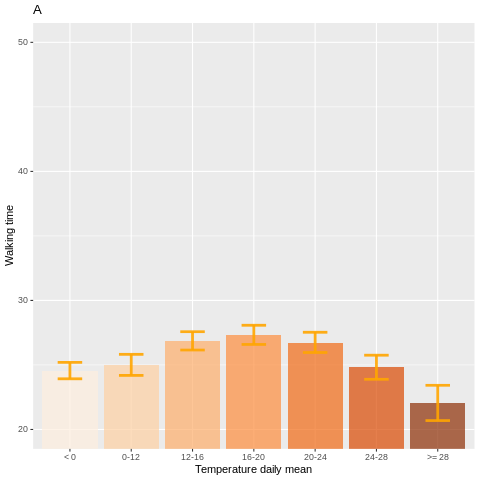

In [ ]:
%%R
finaldf<-finaldfD

finaldf$TempMean <-factor(finaldf$TempMean, levels=c("< 0","0-12","12-16","16-20","20-24","24-28",">= 28"))
p <-ggplot(finaldf)+ geom_bar( aes(x=TempMean , y=lsmean, fill=TempMean ), stat="identity",,alpha=0.7)+
geom_errorbar( aes(x=TempMean, ymin=lower.CL, ymax=upper.CL), width=0.4, colour="orange", alpha=0.9, size=1.3)
p + coord_cartesian(ylim=c(20,50))+ scale_fill_brewer(palette= "Oranges")+ theme(legend.position= "none")+ 
labs(x = "Temperature daily mean")+ labs(y = "Walking time")+labs(title = "A")+ theme(plot.title = element_text(hjust = 0))

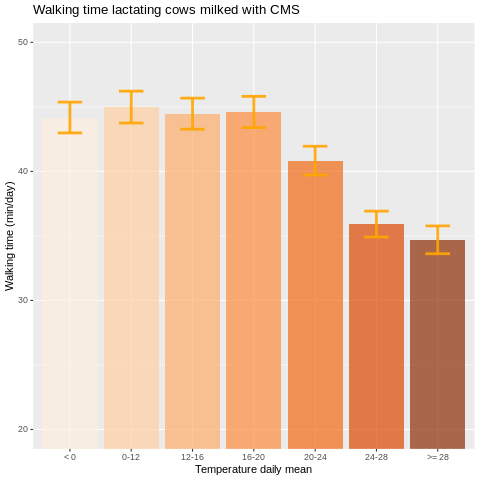

In [ ]:
%%R
finaldf<-finaldfC

finaldf$TempMean <-factor(finaldf$TempMean, levels=c("< 0","0-12","12-16","16-20","20-24","24-28",">= 28"))
p <-ggplot(finaldf)+ geom_bar( aes(x=TempMean , y=lsmean, fill=TempMean ), stat="identity",,alpha=0.7)+
geom_errorbar( aes(x=TempMean, ymin=lower.CL, ymax=upper.CL), width=0.4, colour="orange", alpha=0.9, size=1.3)
p + coord_cartesian(ylim=c(20,50))+ scale_fill_brewer(palette= "Oranges")+ theme(legend.position= "none")+ 
labs(x = "Temperature daily mean")+ labs(y = "Walking time (min/day)")+labs(title = "Walking time lactating cows milked with CMS")


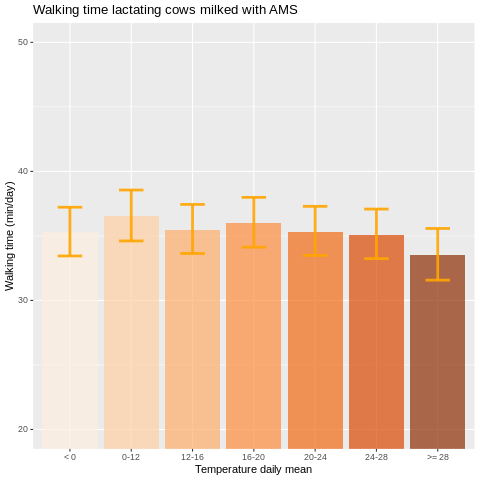

In [ ]:
%%R
finaldf<-finaldfA
finaldf$TempMean <-factor(finaldf$TempMean, levels=c("< 0","0-12","12-16","16-20","20-24","24-28",">= 28"))
p <-ggplot(finaldf)+ geom_bar( aes(x=TempMean , y=lsmean, fill=TempMean ), stat="identity",,alpha=0.7)+
geom_errorbar( aes(x=TempMean, ymin=lower.CL, ymax=upper.CL), width=0.4, colour="orange", alpha=0.9, size=1.3)
p + coord_cartesian(ylim=c(20,50))+ scale_fill_brewer(palette= "Oranges")+ theme(legend.position= "none")+ 
labs(x = "Temperature daily mean")+ labs(y = "Walking time (min/day)")+labs(title = "Walking time lactating cows milked with AMS")


In [ ]:
%%R
LSMsAL<-emmeans::lsmeans(fit.6a, ~ fTempMeanCat, glhargs=list())
print(LSMsAL)

 fTempMeanCat lsmean     SE     df lower.CL upper.CL
 1              3.56 0.0273 293816     3.51     3.62
 0              3.60 0.0275 293816     3.54     3.65
 2              3.57 0.0273 293816     3.52     3.62
 3              3.58 0.0273 293816     3.53     3.64
 4              3.56 0.0274 293816     3.51     3.62
 5              3.56 0.0279 293816     3.50     3.61
 6              3.51 0.0305 293816     3.45     3.57

Results are averaged over the levels of: fDimCat, fLactationNumberCat, fYear, fMonth, fHerdIdentifier 
Confidence level used: 0.95 


In [ ]:
%%R
LSMsCL<-emmeans::lsmeans(fit.6b, ~ fTempMeanCat, glhargs=list())
print(LSMsCL)

 fTempMeanCat lsmean     SE     df lower.CL upper.CL
 1              3.79 0.0138 661514     3.76     3.81
 0              3.81 0.0140 661514     3.78     3.83
 2              3.79 0.0138 661514     3.77     3.82
 3              3.80 0.0139 661514     3.77     3.82
 4              3.71 0.0139 661514     3.68     3.74
 5              3.58 0.0143 661514     3.55     3.61
 6              3.55 0.0159 661514     3.52     3.58

Results are averaged over the levels of: fDimCat, fLactationNumberCat, fYear, fMonth, fHerdIdentifier 
Confidence level used: 0.95 


In [ ]:
%%R
LSMsDL<-emmeans::lsmeans(fit.6c, ~ fTempMeanCat, glhargs=list())
print(LSMsDL)

 fTempMeanCat lsmean     SE    df lower.CL upper.CL
 1              3.20 0.0132 75300     3.18     3.23
 0              3.22 0.0167 75300     3.19     3.25
 2              3.29 0.0135 75300     3.26     3.32
 3              3.31 0.0139 75300     3.28     3.33
 4              3.29 0.0150 75300     3.26     3.32
 5              3.21 0.0192 75300     3.17     3.25
 6              3.09 0.0316 75300     3.03     3.15

Results are averaged over the levels of: fLactationNumberCat, fYear, fMonth, fHerdIdentifier 
Confidence level used: 0.95 
